# Baseball Analytics

**Carl Klein**

**May 1, 2024**

In this paper, we'll be performing an analysis on baseball statistics from a dataset containing 50 years of baseball statistics [6](https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012).

---

## Table of Contents <a id="toc"></a>
- [Part I - Initial Findings](#part-i)
- [Part II - Theoretical Bases](#part-ii)
- [Part III - Data Cleaning](#part-iii)
- [Part IV - Functions](#part-iv)
- [Part V - Generalized Linear Models](#part-v)
- [Part VI - Multiple Linear Regression Models](#part-vi)
- [Part VII - Pythagorean Theorem of Basebal](#part-vii)
- [Part VIII - Conclusion](#part-viii)

---

# I - Initial Findings <a id="part-i"></a>

In [202]:
# import libraries
library(tidyverse, quietly = T)
library(caret, quietly = T)
library(corrplot, quietly = T)
library(reshape2, quietly = T)
library(gridExtra, quietly = T)
library(leaps, quietly = T)
library('ggpubr', quietly = T)
library(car, quietly = T)
library(DescTools, quietly = T)

In [108]:
# read in dataset
# from https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012
df <- read_csv('data/baseball.csv', show_col_types = F)

In [109]:
# raw dataset information
head(df)
summary(df)
dim(df)

Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NA,NA,162,0.317,0.415
ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4,5,162,0.306,0.378
BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5,4,162,0.315,0.403
BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NA,NA,162,0.331,0.428
CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NA,NA,162,0.335,0.424
CHW,AL,2012,748,676,85,0.318,0.422,0.255,0,NA,NA,162,0.319,0.405


     Team              League               Year            RS        
 Length:1232        Length:1232        Min.   :1962   Min.   : 463.0  
 Class :character   Class :character   1st Qu.:1977   1st Qu.: 652.0  
 Mode  :character   Mode  :character   Median :1989   Median : 711.0  
                                       Mean   :1989   Mean   : 715.1  
                                       3rd Qu.:2002   3rd Qu.: 775.0  
                                       Max.   :2012   Max.   :1009.0  
                                                                      
       RA               W              OBP              SLG        
 Min.   : 472.0   Min.   : 40.0   Min.   :0.2770   Min.   :0.3010  
 1st Qu.: 649.8   1st Qu.: 73.0   1st Qu.:0.3170   1st Qu.:0.3750  
 Median : 709.0   Median : 81.0   Median :0.3260   Median :0.3960  
 Mean   : 715.1   Mean   : 80.9   Mean   :0.3263   Mean   :0.3973  
 3rd Qu.: 774.2   3rd Qu.: 89.0   3rd Qu.:0.3370   3rd Qu.:0.4210  
 Max.   :1103.0   Max.  

[1] 1232   15

In [110]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
col_na

,Nulls
,<int>
Team,0
League,0
Year,0
RS,0
RA,0
W,0
OBP,0
SLG,0
BA,0


In [111]:
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
break_na

Year,n
<dbl>,<int>
1962,20
1963,20
1964,20
1965,20
1966,20
1967,20
1968,20
1969,24
1970,24


Playoffs and winning the series are great achievements, but often a team's achievements are also frequently measured in:

- **Run Differential** (most telling): subtracting the number of runs allowed from the number of runs scored [1](https://www.samford.edu/sports-analytics/fans/2022/MLB-Winning-Percentage-Breakdown-Which-Statistics-Help-Teams-Win-More-Games)
    - positve: a strong team which outscores its opponents
    - negative: a team that is struggling to keep up with it's opponents
- **Winning Percentage**: total wins divided by total games [1](https://www.samford.edu/sports-analytics/fans/2022/MLB-Winning-Percentage-Breakdown-Which-Statistics-Help-Teams-Win-More-Games)
- **On-Base Percentage**: how frequently a batter reaches base per plate appearence [2](https://sarahesult.medium.com/common-mlb-statistics-which-stats-determine-a-teams-win-percentage-a6e0a83aa07c)
- **Slugging Percentage**: total number of bases a team accumulates per at-bat [2](https://sarahesult.medium.com/common-mlb-statistics-which-stats-determine-a-teams-win-percentage-a6e0a83aa07c)
    - total bases: sum of the number of singles (1), doubles (2), triples (3), and home runs (4)

As we were exploring the data, we came across some limitations and issues which slightly altered the trajectory of the initial research questions we were planning to pursue.

The metrics Opponent On-Base Percentage (`OOBP`) and Opponent Slugging Percentage (`OSLG`) weren't captured before the 1999 season.

This gave us two ways to proceed:

- drop the rows and use 1999-2012 seasons
- drop the columns and use all seasons

Baseball tactics and training has changed significantly through the years, especially over a 50 year stretch the dataset offers. So, while we may have more observations to train models using all the seasons available, we may obtain a more accurate model by focusing on the current years.

This gave us some potential research questions.

1. Are more closely related seasons (in time) better indicators of each other?
2. Which features are pertinent for a model? Do we even need `OOBP` and `OSLG`?

There are some slight issues preventing us from using other features or predicting certain events.

1. We don't have data from points throughout the season, so we don't have the capability to predict where a team might finish given their status during the season.
2. Not immediately due to volatiltiy of the players or coaches from one season to the next, but to historical changes within franchises (creation, dissolution, name changes, city changes, etc.), it can be difficult to track a team from one season to the next.

> Due to this, we ultimately ended up dropping the `Team` and `Year` columns. Additionally, we dropped the `League` column to allow for more flexibility in our models as there are an equal number of teams which make the playoffs from each league each season.

An exciting metric discovery we made was finding **The Pythagorean Theorem of Baseball**, which incidentally could be explored through statistics available in our dataset.

The theorem is simply stated as the following:

Let

$R_s$: Runs Scored

$R_a$: Runs Allowed

$W_p$: Winning Percentage

Then, there were two formulas presented:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

[Table of Contents](#toc)

[Conclusion](#part-viii)

---

# II - Theoretical Bases <a id="part-ii"></a>

## Research Questions

With everything presented, our overarching goals are:

1. Create a model to predict whether or not a team made the playoffs.
2. Create a model to predict whether or not a team won the series.
3. Create a model to predict other variables previously as features, seen as important metrics:
    - Winning Percentage
    - On-Base Percentage
    - Slugging Percentage
4. Create a model which predicts the best exponents in the Pythagorean Theorem of Baseball.
5. Explore the break between seasons which tracked `OOBP` and `OSLG`.

## Formulas

### SSE (Sum Squared Error)

$$SSE = \sum\limits_{i=1}^{n} (y_i - \hat{y_i})^2$$

$SSE$ is a measure of how much variation is left unexplained by the model, where:

- $y_i$: actual/observed value
- $\hat{y_i}$: predicted value

### SST (Total Sum of Squares)

$$SST = \sum\limits_{i=1}^{n} (\hat{y_i} - \bar{y})^2$$

$SST$ represents the total amount of variation in observed values (what we would get if we used the mean of the data as our model), where:

- $\hat{y_i}$: predicted value
- $\bar{y_i}$: mean of the actual/observed values

### $R^2$

$$R^2 = 1 - \frac{SSE}{SST}$$

$R^2$ is the proportion of variance that can be explained by the model, and can be used as an indicator of goodness of fit for simple linear regression (SLR) models.

### $R^2_a$ (Adjusted $R^2$)

$$R^2_a = 1 - \frac{SSE/(n-p-1)}{SST/(n-1)}$$

$R^2_a$ is a better indicator of goodness for multiple linear regression (MLR) models over the normal $R^2$ as it penalizes for having too many features that are not reducing $SSE$, where:

- n: number of observations
- p: number of features

### MSPE (Mean Squared Prediction Error)

$$MSPE = \frac{1}{n}\sum^n_{i=1} (y_i - \hat{y_i})^2 $$

$MSPE$ quantifies the discrepancy between the predicted values and the observed value, and can help to evalute the performance of a model.

## Hypothesis Tests

### t-test

- $H_0$: $\beta_j = c$
- $H_A$: $\beta_j \neq c$

$c \in \mathbb{R}$

We'll assume $c=0$ for our purposes (which is the default returned by the `summary()`).

Used in finding if a feature has an effect on the response. In the case of a small enough p-value, we can reject the null hypothesis in favor of the alternative hypothesis which means there is statistical evidence that the associated feature (variable) has an effect on the response variable.

### Chi-squared Test

- $H_0$: the model is not useful (the model with no predictors, null model, is as good as the model with predictors - i.e. the predictors do not improve the model fit)
- $H_A$: the model is useful (the model with predictors provides a better fit)

Compares the null deviance to the residual deviance in generalized linear models. A small enough p-value suggests strong evidence against the null hypothesis that the model with no predictors (null model) is as good as the model with predictors (full model). In other words, the predictors significantly improve the model fit.

### Partial F-test

Given a full model ($\Omega$) and a reduced model ($\omega$),

- $H_0$: $\beta_j = 0$, $\forall j \notin \omega$ but in $\Omega$ (the reduced model is sufficient)
- $H_A$: $\beta_j \neq 0$ for at least one of $j \notin \omega$ but in $\Omega$ (the reduced model is not sufficient)

When there is a small enough p-value, this suggests that the reduced is not sufficient. Used in testing reduced models against full models.

### Full F-test

- $H_0$: $y_i = \beta_0 + \epsilon_i$ (i.e. $\beta_1 = \beta_2 = \dots = \beta_p = 0$)
- $H_A$: $\beta_k \neq 0$ for at least one value in $k \in \{1, \dots, p\}$

The null hypothesis essentially states that there is no useful linear relationship between the response and any of the predictors. A small enough p-value suggests strong evidence against the null hypothesis, or in other words the model is better than the most reduced model possible. Useful in multiple linear regression (MLR) where the individual t-tests suggesting evidence against the null hypothesis may result in type I errors.

## Models

### Generalized Linear Model (GLM)

A GLM has three components:

- Random Component
- Systematic Component
- Link Function

In our case, we'll be using $GLM$ for logistic regression.

### Multiple Linear Regression (MLR)

$y = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p$

### Simple Linear Regression (SLR)

$y = \beta_0 + \beta_1 x_1$

[Table of Contents](#toc)

[Conclusion](#part-viii)

---

# III - Data Cleaning <a id="part-iii"></a>

In [112]:
# create new dataframe to perform cleaning on
df_cleaned <- df

- `RankSeason`: null values are only null where a team failed to make the playoffs (make binomial - replace null values with 0 and, rank season where already numerical as 1)
- `RankPlayoffs`: null values are only null where a team failed to win the championship (make binomial - replace null values with 0, rank playoffs of 1 retained with 1)

In [113]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [114]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [115]:
# cleaned dataset information
head(df_cleaned)
summary(df_cleaned)
dim(df_cleaned)

Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,Champion,WP,RD
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NA,NA,162,0.317,0.415,0,0.5000000,46
ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4,5,162,0.306,0.378,0,0.5802469,100
BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5,4,162,0.315,0.403,0,0.5740741,7
BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NA,NA,162,0.331,0.428,0,0.4259259,-72
CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NA,NA,162,0.335,0.424,0,0.3765432,-146
CHW,AL,2012,748,676,85,0.318,0.422,0.255,0,NA,NA,162,0.319,0.405,0,0.5246914,72


     Team           League        Year            RS               RA        
 Length:1232        AL:616   Min.   :1962   Min.   : 463.0   Min.   : 472.0  
 Class :character   NL:616   1st Qu.:1977   1st Qu.: 652.0   1st Qu.: 649.8  
 Mode  :character            Median :1989   Median : 711.0   Median : 709.0  
                             Mean   :1989   Mean   : 715.1   Mean   : 715.1  
                             3rd Qu.:2002   3rd Qu.: 775.0   3rd Qu.: 774.2  
                             Max.   :2012   Max.   :1009.0   Max.   :1103.0  
                                                                             
       W              OBP              SLG               BA        
 Min.   : 40.0   Min.   :0.2770   Min.   :0.3010   Min.   :0.2140  
 1st Qu.: 73.0   1st Qu.:0.3170   1st Qu.:0.3750   1st Qu.:0.2510  
 Median : 81.0   Median :0.3260   Median :0.3960   Median :0.2600  
 Mean   : 80.9   Mean   :0.3263   Mean   :0.3973   Mean   :0.2593  
 3rd Qu.: 89.0   3rd Qu.:0.3370   3r

[1] 1232   18

[Table of Contents](#toc)

[Conclusion](#part-viii)

---

# IV - Functions <a id="part-iv"></a>

In [116]:
# single calculation mspe function
model_mspe <- function(test_data, response_var, glmod, threshold=0.5) {
    # gather observations respective to response variable
    obs <- test_data[[response_var]]
    # get probabilities given input
    pred_probs <- predict(glmod, test_data, 'response')
    # turn probabilities into values given the threshold (default=0.5)
    pred <- ifelse(pred_probs > 0.5, 1, 0)
    # calculate mean squared prediction error (mspe)
    mspe <- mean((obs - pred)^2)
    return(mspe)
}

In [117]:
# function for returning mspe form a regsubset output
mspe_loop <- function(train_set, test_set, regsubset_summary, response) {
    # observed values from test set
    obs <- test_set[[response]]
    # initialize mspe tracking list
    mspe_results <- c()
    loop_size <- dim(regsubset_summary$which)[1]
    for (model in 1:loop_size) {
        # create model
        true_cols <- names(which(regsubset_summary$which[model,]))
        # remove intercept feature
        true_cols <- true_cols[true_cols != '(Intercept)']
        formula <- paste(unlist(true_cols), collapse = '+')
        formula <- paste('~', formula, '')
        formula <- paste(response, formula, '')
        lmod <- lm(data = train_set, as.formula(formula))
        # calculate MSPE
        preds <- lmod %>% predict(test_set)
        mspe <- mean((obs - preds)^2)
        mspe_results <- c(mspe_results, mspe)
    }
    return(mspe_results)
}

In [118]:
# function for making dataframe long with respect to response variable
create_long_df <- function(df, response) {
    df_long <- pivot_longer(df,
                            cols = names(df %>% select(-all_of(response))),
                            names_to = 'feature_names',
                            values_to = 'feature_values')
    return(df_long)
}

In [119]:
# create function for faceted plots
plot_long_facets <- function(df_long, subset_type, response) {
    title_text <- paste(subset_type, response)
    ggplot(df_long, aes(x=feature_values, y=!!sym(response))) +
        geom_point() +
        facet_wrap(~ feature_names, scales = 'free_x') +
        ggtitle(title_text) +
        xlab('Feature')
}

In [120]:
# function for plotting GLM results
plot_glm <- function(full_data, train_data, test_data, response_var, subset_type, threshold=0.5) {
    # backwards selection results table
    bs_results <- backwards_glm(train_data=train_data, test_data=test_data, response_var=response_var)
    
    # long df for plotting facets
    df_long <- create_long_df(full_data, response_var)
    
    # facets plot
    facets_plot <- plot_long_facets(df_long, subset_type=subset_type, response=response_var)
    
    # AIC plot
    x <- 1:dim(bs_results)[1]
    AIC_plot <- ggplot(data=bs_results, aes(x=x, y=AIC)) +
        geom_line() +
        geom_point(aes(x=which.min(AIC), y=min(AIC)), color='red', size=3) +
        xlab('Model') +
        theme(aspect.ratio=1)
    
    # MSPE plot
    MSPE_plot <- ggplot(data=bs_results, aes(x=x, y=MSPE)) +
        geom_line() +
        geom_point(aes(x=which.min(MSPE), y=min(MSPE)), color='red', size=3) +
        xlab('Model') +
        theme(aspect.ratio=1)
    
    # combine AIC and MSPE into single plot
    metrics_plot <- ggarrange(AIC_plot, MSPE_plot,
                              labels = c('AIC', 'MSPE'))
    
    # print results
    print(bs_results)
    print(facets_plot)
    print(metrics_plot)
}

In [121]:
# backwards selection to return several important metrics
backwards_glm <- function(train_data, test_data, response_var, threshold=0.5) {
    # full model
    formula <- paste(response_var, '~ .', '')
    glmod_full <- glm(data = train_data, as.formula(formula), family = binomial)
    # pvals
    pvals <- summary(glmod_full)$coefficients[, 4]
    # feature consideration
    features <- names(pvals)
    features <- features[features != '(Intercept)']
    
    # using deviance
    # null deviance - residual deviance, null residual df - residual deviance df
    # null hypothesis: the model is not useful
    # alternative hypothesis: the model is useful
    dev = 1 - pchisq(glmod_full$null.deviance - glmod_full$deviance,
                     glmod_full$df.null - glmod_full$df.residual)
    
    # dataframe
    results_df <- data.frame(t(sapply(pvals, 'c')),
                             AIC=AIC(glmod_full),
                             DevDiffX2 = dev,
                             Ftest = NA,
                             MSPE=model_mspe(test_data=test_data,
                                             response_var=response_var,
                                             glmod=glmod_full))
    
    # set glmod_full to glmod for following loop
    glmod <- glmod_full
    
    # go until last feature remains
    while (length(features) > 1) {
        # remove value with max pvalue (intercept is removed in case)
        remove_feature <- names(which.max(unlist(pvals)))
        # create text formula for update() function
        formula <- paste('.~.-', remove_feature)
        # update glm with as.formula() function
        glmod <- update(glmod, as.formula(formula))
        # pvals
        pvals <- summary(glmod)$coefficients[, 4]
        dev = 1 - pchisq(glmod$null.deviance - glmod$deviance,
                         glmod$df.null - glmod$df.residual)
        # new row for dataframe
        new_df <- data.frame(t(sapply(pvals, 'c')),
                             AIC=AIC(glmod), 
                             DevDiffX2 = dev,
                             Ftest=anova(glmod_full, glmod, test='Chisq')[2,5],
                             MSPE=model_mspe(test_data=test_data,
                                             response_var=response_var,
                                             glmod=glmod))
        # update feature consideration
        features <- names(pvals)
        # remove intercept from features to be considered for removal
        features <- na.omit(features[features != '(Intercept)'])
        # update dataframe
        results_df <- bind_rows(results_df, new_df)
    }
    
    # round all numbers, rename intercept column
    results_df <- results_df %>%
        mutate_if(is.numeric, round, digits=3) %>%
        rename(Int. = X.Intercept.)

    # return ending backwards selection dataframe
    return(results_df)
}

In [122]:
# create function mlr the plotting
plot_mlr <- function(full_set, train_set, test_set, response, subset_type) {
    # faceted plots
    # 1) build long dataframe with respect to variabe
    # 2) create plots
    df_long <- create_long_df(df=full_set, response=response)
    faceted_plots <- plot_long_facets(df_long=df_long,
                                      subset_type=subset_type,
                                      response=response)
    print(faceted_plots)
    
    # regsubsets builds models with forward selection
    formula <- paste(response, '~.', '')
    reg_lm <- regsubsets(data=train_set, as.formula(formula))
    rs <- summary(reg_lm)
    print(rs$which)
    
    # compute dimensions from dataset
    n <- dim(train_set)[1]
    m <- dim(train_set)[2]
    x <- 1:(m-1)

    # compute metrics
    AIC <- 2*(2:m) + n*log(rs$rss/n)
    BIC <- log(n)*(2:m) + n*log(rs$rss/n)
    R2Adj <- rs$adjr2
    mspe <- mspe_loop(train_set=train_set,
                      test_set=test_set,
                      regsubset_summary=rs,
                      response=response)

    # turn metrics into dataframes
    AIC_df <- data.frame(AIC = AIC)
    BIC_df <- data.frame(BIC = BIC)
    R2Adj_df <- data.frame(R2Adj = R2Adj)
    mspe_df <- data.frame(MSPE = mspe)
    
    # AIC Plot
    AIC_plot <- ggplot(data = AIC_df, aes(x=x, y=AIC)) +
        geom_line() +
        geom_point(aes(x=which.min(AIC), y=min(AIC)), color='red', size=3) +
        xlab('Model')

    # BIC Plot
    BIC_plot <- ggplot(data = BIC_df, aes(x=x, y=BIC)) +
        geom_line() +
        geom_point(aes(x=which.min(BIC), y=min(BIC)), color='red', size=3) +
        xlab('Model')

    # Adjusted R2 Plot
    R2Adj_plot <- ggplot(data = R2Adj_df, aes(x=x, y=R2Adj)) +
        geom_line() +
        geom_point(aes(x=which.max(R2Adj), y=max(R2Adj)), color='red', size=3) +
        xlab('Model')

    # MSPE Plot
    MSPE_plot <- ggplot(data = mspe_df, aes(x=x, y=MSPE)) +
        geom_line() +
        geom_point(aes(x=which.min(mspe), y=min(mspe)), color='red', size=3) +
        xlab('Model')
    
    # combine plots
    combined_plot <- ggarrange(AIC_plot, BIC_plot, R2Adj_plot, MSPE_plot,
                           labels = c('AIC', 'BIC', 'R2Adj', 'MSPE'))
    
    print(combined_plot)
}

In [123]:
# inverse logit function for glm logistic / binomial to return predicted values
ilogit <- function(eta) {
    ilogit <- exp(eta) / (1 + exp(eta))
    return(ilogit)
}

In [195]:
# diagnostics
diagnostics_plots <- function(df, model, response_var, type='linear') {
    if (type=='linear') {
        # default plots
        plot(model)
        # predicted vs observed
        plot(predict(model), df[[response_var]],
             main='Predicted vs Observed',
             xlab='Predicted', ylab='Observed')
        # successive residuals
        df_diagnostics = data.frame(yhat = fitted(model),
                                    r = resid(model),
                                    y = df[[response_var]])
        n = dim(df)[1]; 
        x = head(df_diagnostics$r, n-1)
        y = tail(df_diagnostics$r, n-1)
        srp = data.frame(x,y)
        ggplot(srp, aes(x = x, y = y)) + 
            geom_point() + 
            geom_vline(xintercept = 0) + 
            geom_hline(yintercept = 0) + 
            xlab(expression(hat(epsilon)[i])) +
            ylab(expression(hat(epsilon)[i+1])) + 
            ggtitle("Successive Residual Plot") + 
            theme_bw() + 
            theme(plot.title = element_text(hjust = 0.5))
    } else  if (type=='response') {
        # default plots
        plot(model)
        # predicted vs observed
        plot(predict(model, type='response'), df[[response_var]],
             main='Predicted vs Observed',
             xlab='Predicted', ylab='Observed')
        # contingency table
        df_diagnostics <- df
        predicted_value <- predict(model, df, type='response')
        df_diagnostics$Predicted <- ifelse(predicted_value > 0.5, 1, 0)
        contingency_table <- table(df_diagnostics[[response_var]],
                                   df_diagnostics$Predicted,
                                   dnn=c(response_var, 'Predicted'))
        accuracy <- sum(diag(contingency_table)) / sum(contingency_table)
        print(accuracy)
        print(contingency_table)
        # successive residuals
        df_diagnostics = data.frame(yhat = fitted(model),
                                    r = resid(model),
                                    y = df[[response_var]])
        n = dim(df)[1]; 
        x = head(df_diagnostics$r, n-1)
        y = tail(df_diagnostics$r, n-1)
        srp = data.frame(x,y)
        ggplot(srp, aes(x = x, y = y)) + 
            geom_point() + 
            geom_vline(xintercept = 0) + 
            geom_hline(yintercept = 0) + 
            xlab(expression(hat(epsilon)[i])) +
            ylab(expression(hat(epsilon)[i+1])) + 
            ggtitle("Successive Residual Plot") + 
            theme_bw() + 
            theme(plot.title = element_text(hjust = 0.5))
    } else {
        print('Please use either type: linear or type: response')
    }
}

[Table of Contents](#toc)

[Conclusion](#part-viii)

---

# V - Generalized Linear Models <a id="part-v"></a>

## GLM Data Preparation

In [125]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
# print(col_na)
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
# print(break_na)
# summarize break_na
summary(break_na)
season_break <- max(break_na)
# print(season_break)

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

In [126]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [127]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [128]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [129]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [130]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [131]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

In [132]:
# decision to drop league
# full dataset for modeling
df_full_playoffs <- df_full %>% select(-c(Year, League, Champion))
df_full_champion <- df_full %>% select(-c(Year, League, Playoffs))
# recent dataset for modeling
df_recent_playoffs <- df_recent %>% select(-c(Year, League, Champion))
df_recent_champion <- df_recent %>% select(-c(Year, League, Playoffs))

In [133]:
# train/test split for full data
set.seed(42)
n = floor(0.8 * nrow(df_full)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_full)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_full_playoffs = df_full_playoffs[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full_playoffs = df_full_playoffs[-index, ] #set the testing set to be the remaining rows
# champions
train_full_champion = df_full_champion[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full_champion = df_full_champion[-index, ] #set the testing set to be the remaining rows

In [134]:
# train/test split for recent data
set.seed(42)
n = floor(0.8 * nrow(df_recent)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_recent)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_recent_playoffs = df_recent_playoffs[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent_playoffs = df_recent_playoffs[-index, ] #set the testing set to be the remaining rows
# champions
train_recent_champion = df_recent_champion[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent_champion = df_recent_champion[-index, ] #set the testing set to be the remaining rows

## GLM Data Modeling

### Model Analysis

**The table printout:**

- Columns used in backwards selection reports the p-value from each `t-test` for each feature retained each round, and reports how statistically significant the feature is for a model:
    - OBP
    - SLG
    - BA
    - WP
    - RD
    - OOBP (recent data only)
    - OSLG (recent data only)
- AIC (Akaike Information Criterion) `AIC` reports the AIC for each round, which evalutes how well a model fits the data, and is moreso only meaningful when comparing between models.
- DevDiffX2: `chi-squared test` reports a p-value on how useful a model by comparing the *null deviance* to the *residual deviance*.
- F-test: `partial-f-test` reports if a reduced model is sufficient (compared to the full model).
- MSPE (mean squared prediction error): `MSPE` is a measure of accuracy, comparing predictions to observations.

**The plots:**

The faceted plots show the binomial result compared to each feature in the dataset, while the AIC and MSPE plots are shown for aiding in model selection.

### Full Dataset - Playoffs

  Int.   OBP   SLG    BA WP    RD     AIC DevDiffX2 Ftest  MSPE
1    0 0.267 0.009 0.524  0 0.753 420.491         0    NA 0.077
2    0 0.280 0.009 0.522  0    NA 418.590         0 0.753 0.073
3    0 0.383 0.011    NA  0    NA 417.000         0 0.775 0.073
4    0    NA 0.000    NA  0    NA 415.762         0 0.736 0.073
5    0    NA    NA    NA  0    NA 435.896         0 0.000 0.057


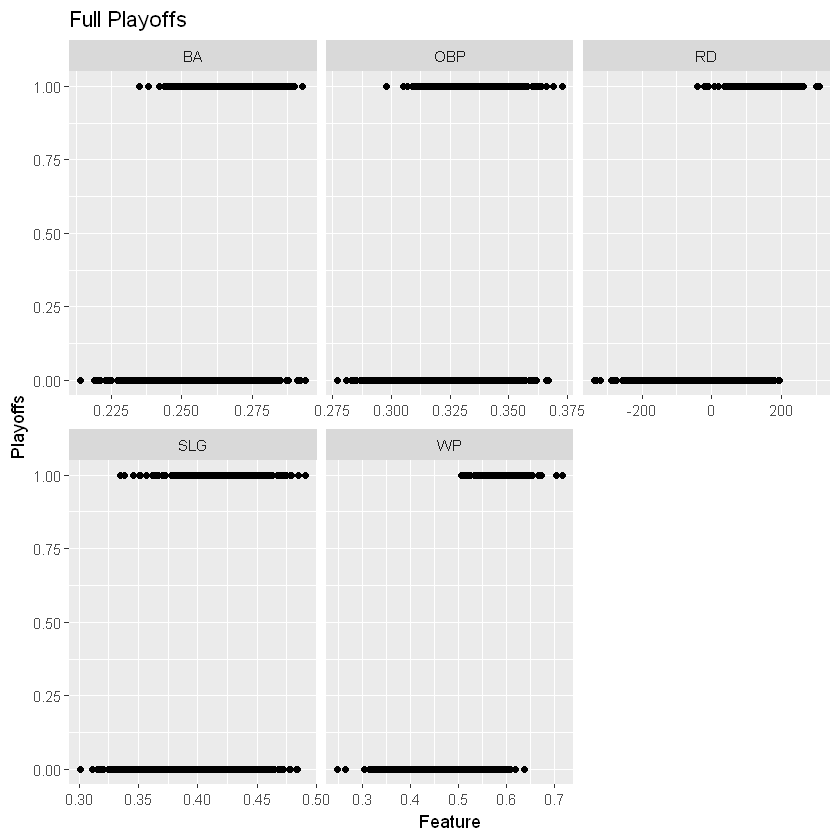

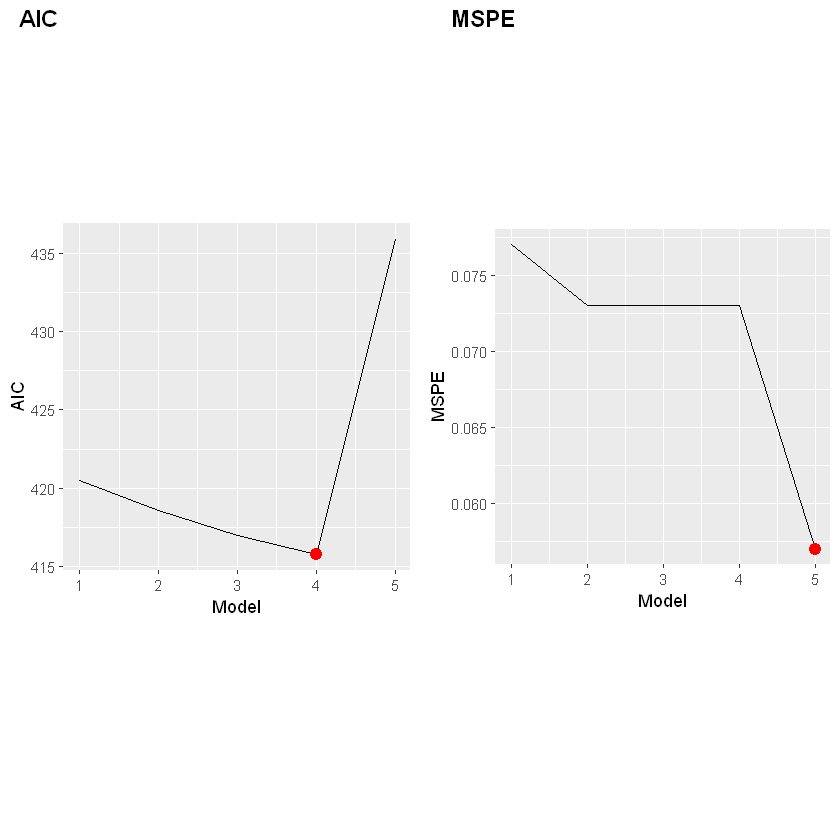

In [135]:
# full dataset - playoffs
plot_glm(df_full_playoffs, train_full_playoffs, test_full_playoffs, 'Playoffs', 'Full')

- AIC reports Model 4 as the best model (minimum) and has a rapid incline to Model 5
- MSPE reports Model 5 as the best model (minimum), but Model 4 still has a reasonable MSPE
- However, the F-test for Model 5 indicates that the model is not sufficient

Therefore, it's reasonable to use Model 4 as our *best* model, with the features:

- SLG
- WP

In [136]:
# best model to predict playoffs with a full dataset
glmod_full_playoffs <- glm(data=train_full_playoffs, Playoffs~SLG+WP, family=binomial)
summary(glmod_full_playoffs)


Call:
glm(formula = Playoffs ~ SLG + WP, family = binomial, data = train_full_playoffs)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -39.916      3.254 -12.268  < 2e-16 ***
SLG           19.388      4.245   4.567 4.95e-06 ***
WP            56.429      4.572  12.343  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 988.56  on 984  degrees of freedom
Residual deviance: 409.76  on 982  degrees of freedom
AIC: 415.76

Number of Fisher Scoring iterations: 7


### Full Dataset - Champion

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


  Int.   OBP   SLG    BA WP  RD     AIC DevDiffX2 Ftest  MSPE
1    0 0.340 0.156 0.101  0 0.7 113.492         0    NA 0.036
2    0 0.298 0.162 0.111  0  NA 111.640         0 0.700 0.036
3    0    NA 0.072 0.212  0  NA 110.744         0 0.535 0.036
4    0    NA 0.174    NA  0  NA 110.300         0 0.422 0.032
5    0    NA    NA    NA  0  NA 110.236         0 0.315 0.032


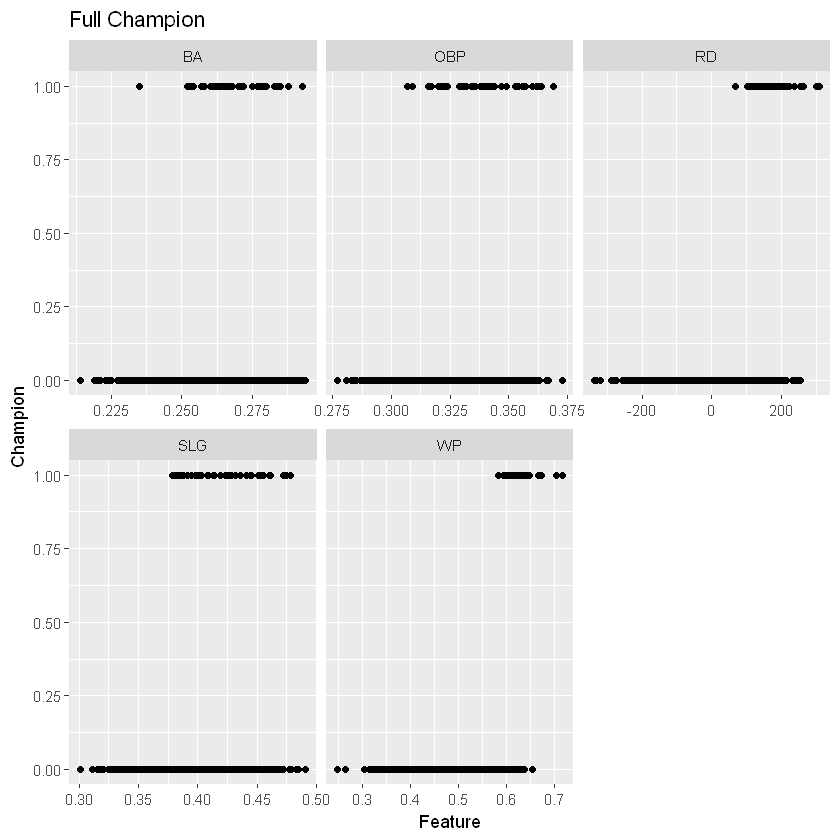

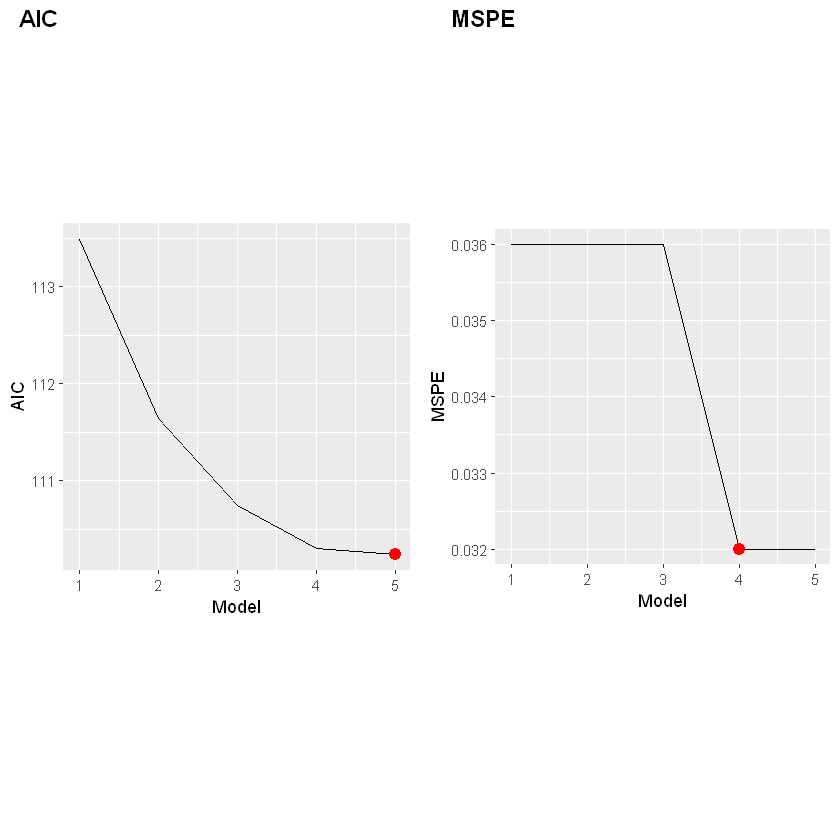

In [137]:
# full dataset - champions
plot_glm(df_full_champion,
         train_full_champion,
         test_full_champion,
         'Champion', 'Full')

- AIC reports Model 5 as the best model (minimum)
- MSPE reports Model 4 as the best model (minimum), however it was reported as the first minimum while Model 5 has the same MSPE
- The F-test for Model 5 confirms the reduced model is sufficient

Therefore, it's reasonable to use Model 5 as our *best* model, with the feature:

- WP

In [138]:
# best model to predict champion with a full dataset
glmod_full_champion <- glm(data=train_full_champion, Champion~WP, family=binomial)
summary(glmod_full_champion)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = Champion ~ WP, family = binomial, data = train_full_champion)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -56.631      7.983  -7.094 1.30e-12 ***
WP            91.247     13.092   6.969 3.18e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 328.30  on 984  degrees of freedom
Residual deviance: 106.24  on 983  degrees of freedom
AIC: 110.24

Number of Fisher Scoring iterations: 10


### Recent Dataset - Playoffs

  Int.   OBP   SLG   BA WP    RD  OOBP  OSLG     AIC DevDiffX2 Ftest  MSPE
1    0 0.398 0.208 0.67  0 0.313 0.636 0.608 127.333         0    NA 0.071
2    0 0.465 0.144   NA  0 0.321 0.546 0.639 125.515         0 0.670 0.083
3    0 0.328 0.160   NA  0 0.203 0.462    NA 123.734         0 0.818 0.083
4    0 0.116 0.228   NA  0 0.072    NA    NA 122.279         0 0.814 0.071
5    0 0.290    NA   NA  0 0.069    NA    NA 121.804         0 0.650 0.083
6    0    NA    NA   NA  0 0.115    NA    NA 120.944         0 0.607 0.071
7    0    NA    NA   NA  0    NA    NA    NA 121.513         0 0.403 0.071


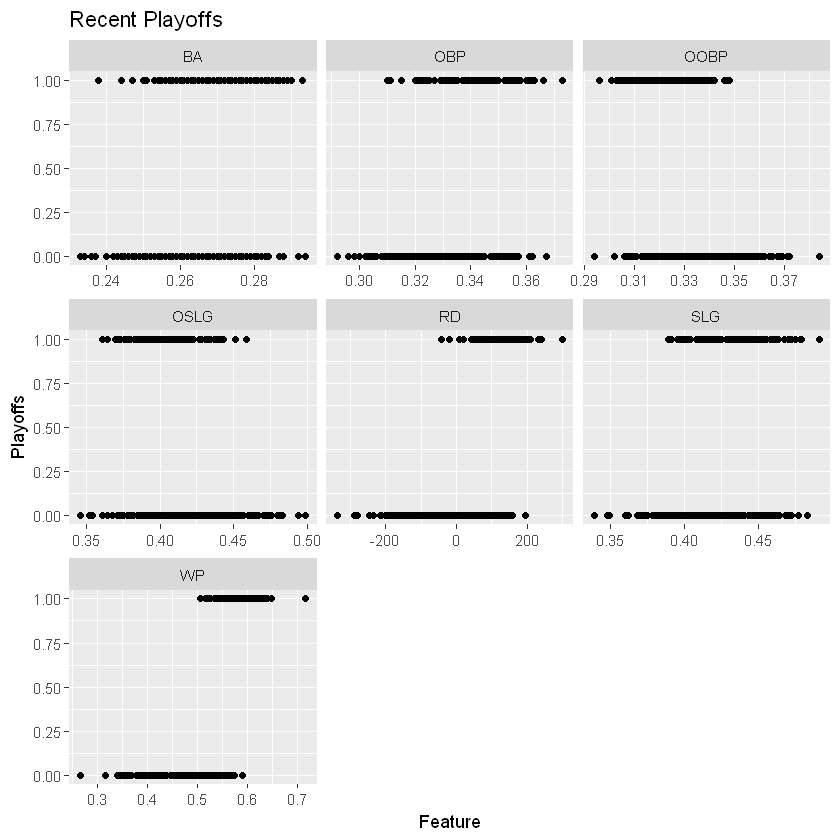

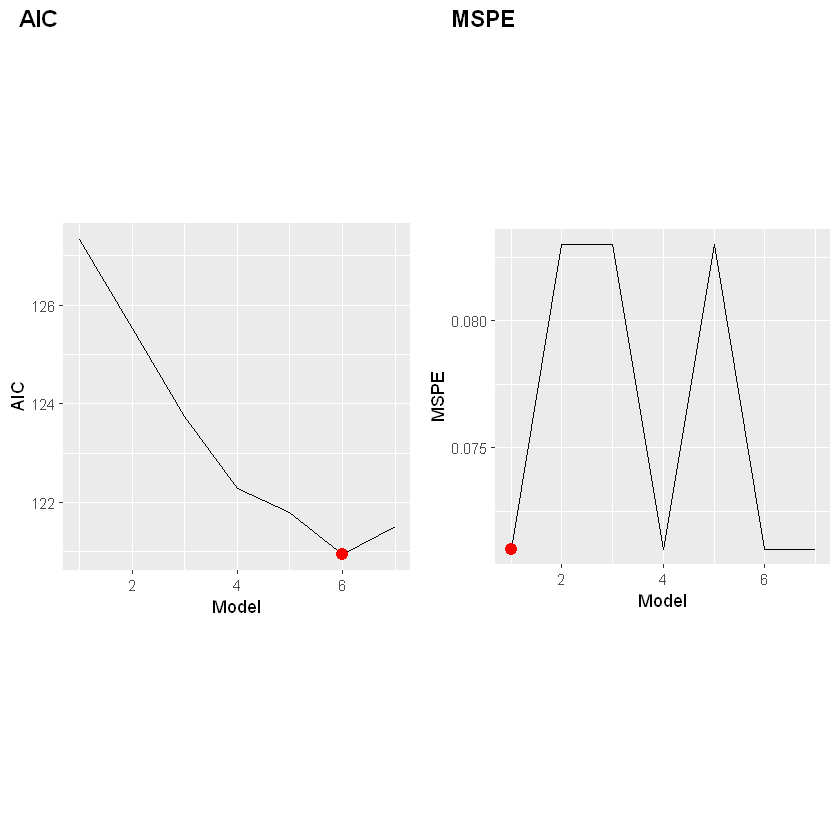

In [139]:
# recent dataset - playoffs
plot_glm(df_recent_playoffs,
         train_recent_playoffs,
         test_recent_playoffs,
         'Playoffs', 'Recent')

- AIC reports Model 6 as the best model (minimum)
- MSPE reports Model 1 as the best model (minimum), however it was reported as the first minimum while Model 4, 6, and 7 each have the same MSPE
- The F-test for Model 6 confirms the reduced model is sufficient

Therefore, it's reasonable to use Model 6 as our *best* model, with the features:

- WP
- RD

However, it is worth noting that **RD**, although statistically significant, the coefficent (-0.01) has a rather minimal effect.

In [140]:
# best model to predict playoffs with a recent dataset
glmod_recent_playoffs <- glm(data=train_recent_playoffs, Playoffs~WP+RD, family=binomial)
summary(glmod_recent_playoffs)


Call:
glm(formula = Playoffs ~ WP + RD, family = binomial, data = train_recent_playoffs)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -54.985543   9.123310  -6.027 1.67e-09 ***
WP          100.989782  17.268945   5.848 4.97e-09 ***
RD           -0.011562   0.007336  -1.576    0.115    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 390.51  on 335  degrees of freedom
Residual deviance: 114.94  on 333  degrees of freedom
AIC: 120.94

Number of Fisher Scoring iterations: 8


### Recent Dataset - Champion

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


   Int.   OBP   SLG    BA    WP    RD  OOBP  OSLG    AIC DevDiffX2 Ftest  MSPE
1 0.053 0.614 0.342 0.819 0.001 0.407 0.340 0.430 54.569         0    NA 0.048
2 0.036 0.533 0.219    NA 0.001 0.422 0.341 0.430 52.620         0 0.820 0.048
3 0.039    NA 0.165    NA 0.001 0.553 0.456 0.518 51.014         0 0.800 0.048
4 0.042    NA 0.195    NA 0.001    NA 0.501 0.651 49.372         0 0.849 0.048
5 0.032    NA 0.221    NA 0.000    NA 0.285    NA 47.581         0 0.908 0.048
6 0.000    NA 0.500    NA 0.000    NA    NA    NA 46.751         0 0.823 0.060
7 0.000    NA    NA    NA 0.000    NA    NA    NA 45.208         0 0.853 0.060


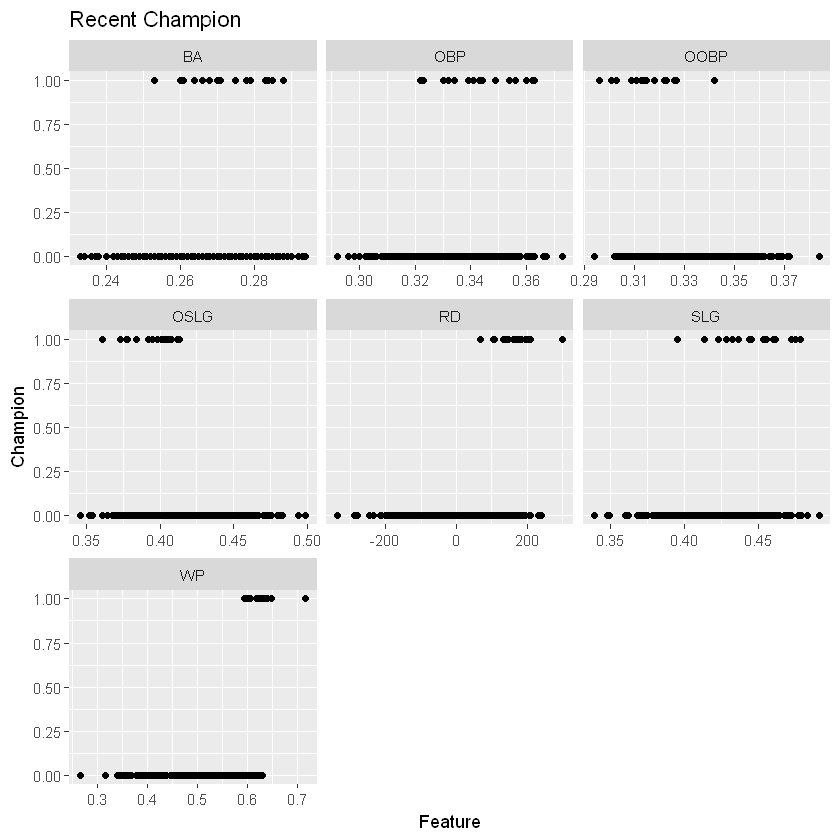

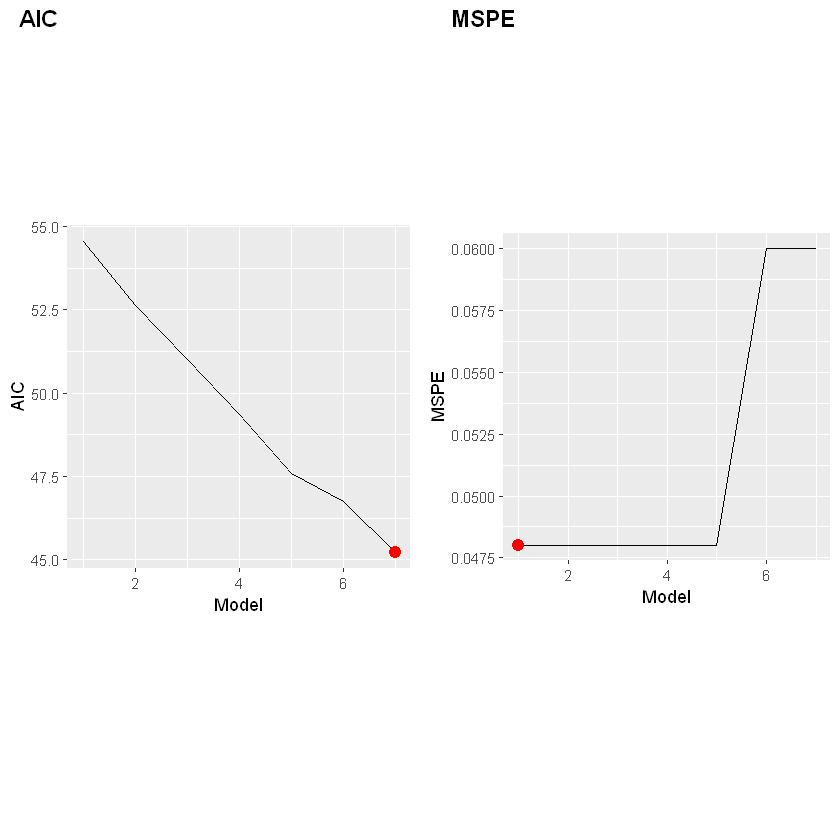

In [141]:
# recent dataset - champion
plot_glm(df_recent_champion,
         train_recent_champion,
         test_recent_champion,
         'Champion', 'Recent')

- AIC reports Model 7 as the best model (minimum)
- MSPE reports Model 1 as the best model (minimum), however it was reported as the first minimum while Model 2, 3, 4, and 5 each have the same MSPE. Model 6 and 7 have the same MSPE which is only slightly higher than the other models.
- The F-test confirms all models are acceptable

Therefore, it's reasonable to use Model 7 as our *best* model, with the feature:

- WP

In [142]:
glmod_recent_champion <- glm(data=train_recent_champion, Champion~WP, family=binomial)
summary(glmod_recent_champion)


Call:
glm(formula = Champion ~ WP, family = binomial, data = train_recent_champion)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -51.77      12.07  -4.288 1.81e-05 ***
WP             83.13      19.88   4.182 2.89e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 103.539  on 335  degrees of freedom
Residual deviance:  41.208  on 334  degrees of freedom
AIC: 45.208

Number of Fisher Scoring iterations: 9


In [143]:
deviance(glmod_recent_champion)/df.residual(glmod_recent_champion)

[1] 0.1233769

## GLM Results

In [144]:
print('Full Dataset - Playoffs')
glmod_full_playoffs$coefficients
print('Full Dataset - Champion')
glmod_full_champion$coefficients
print('Recent Dataset - Playoffs')
glmod_recent_playoffs$coefficients
print('Recent Dataset - Champion')
glmod_recent_champion$coefficients

[1] "Full Dataset - Playoffs"


(Intercept)         SLG          WP 
  -39.91644    19.38785    56.42861

[1] "Full Dataset - Champion"


(Intercept)          WP 
  -56.63104    91.24658

[1] "Recent Dataset - Playoffs"


(Intercept)           WP           RD 
-54.98554330 100.98978228  -0.01156155

[1] "Recent Dataset - Champion"


(Intercept)          WP 
  -51.76871    83.12767

**Playoffs**

- For the full dataset, we have the systematic component: $\eta = -39.92 + 19.39 SLG + 56.43 WP$
- For the recent dataset, we have the systematic component: $\eta = -54.99 + 100.99 WP - 0.01 RD$

**Champion**

- For the full dataset, we have the systematic component: $\eta = -56.63 + 91.25 WP$
- For the recent dataset, we have the systematic component: $\eta = -51.77 + 83.13 WP$

Although all the **Playoffs** and **Champion** best models end with features (stats tracked) which are available across all time periods, the models for **Playoffs** across both are significantly different while the models for **Champion** are relatively similar. If it wasn't for the F-test in 

Therefore, there is evidence warranting differences across time periods for predicting a team making the **Playoffs**, however a team winning, i.e. becoming a **Champion** seem relatively stable across time periods.

## Diagnostics

### Plotting

- Contingency Table
    - Includes Accuracy Calculation Below
- Predicted vs. Observed Plot

*Note: We've used 50% probability as a break point for yes (made playoffs / won the championship) or no (did not make playoffs / did not win the championship).*

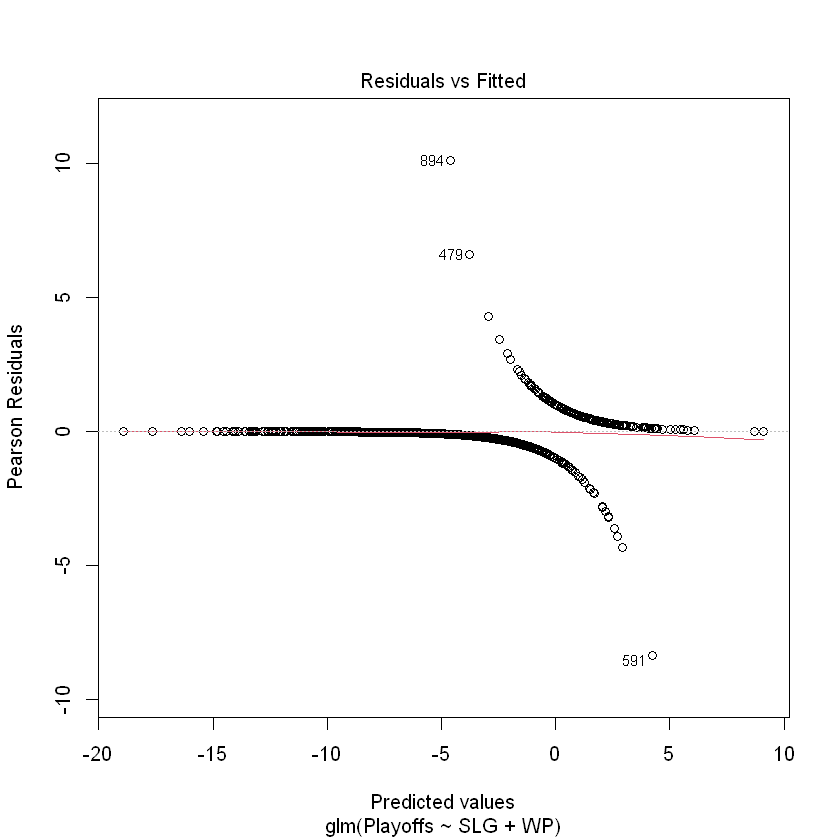

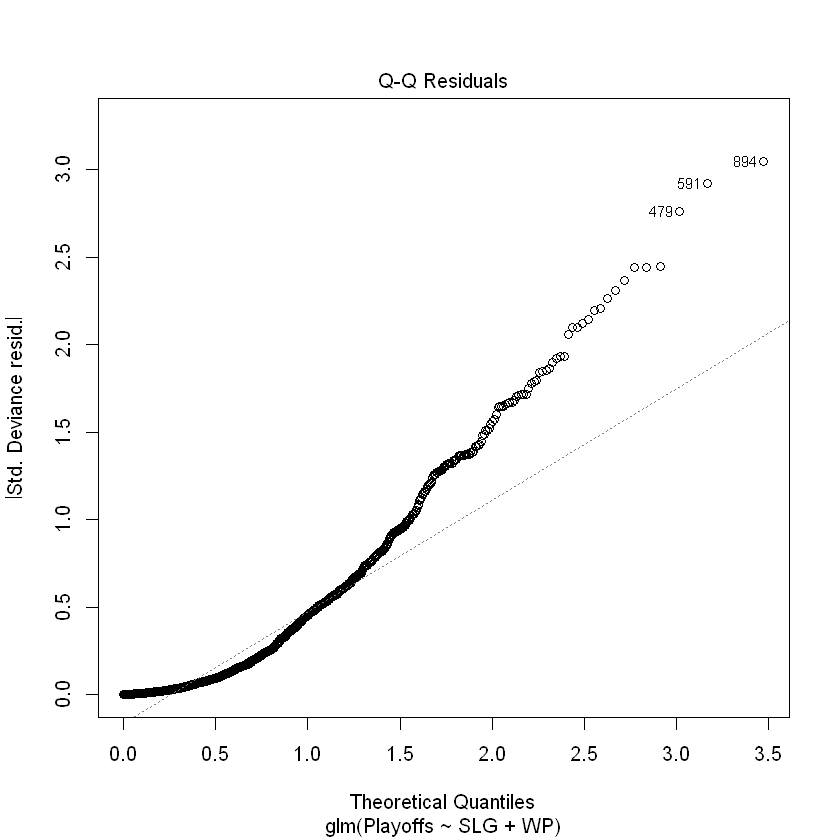

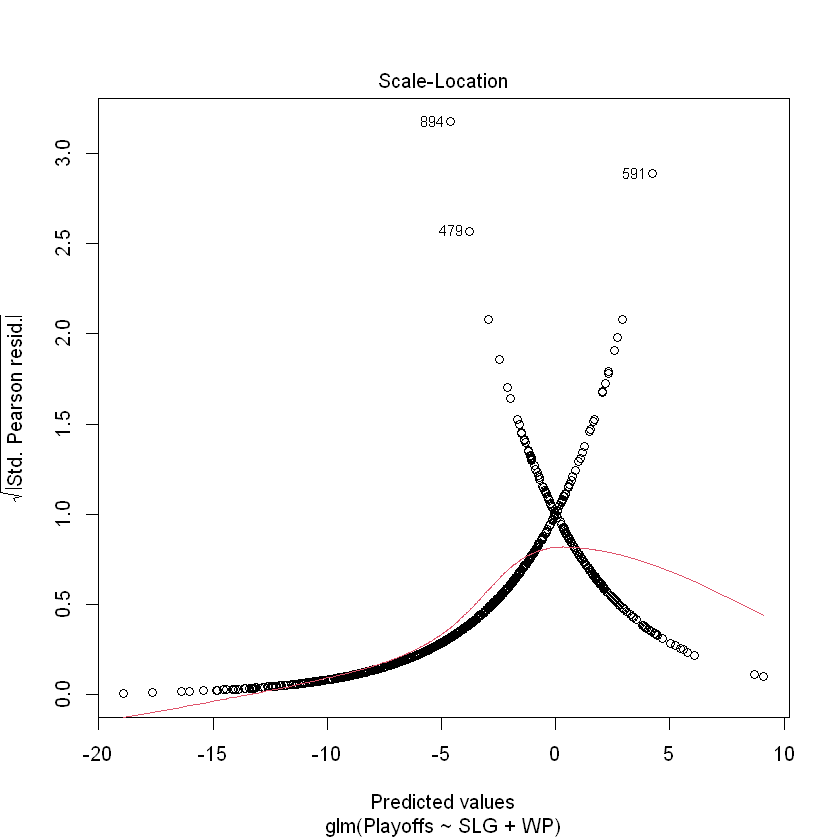

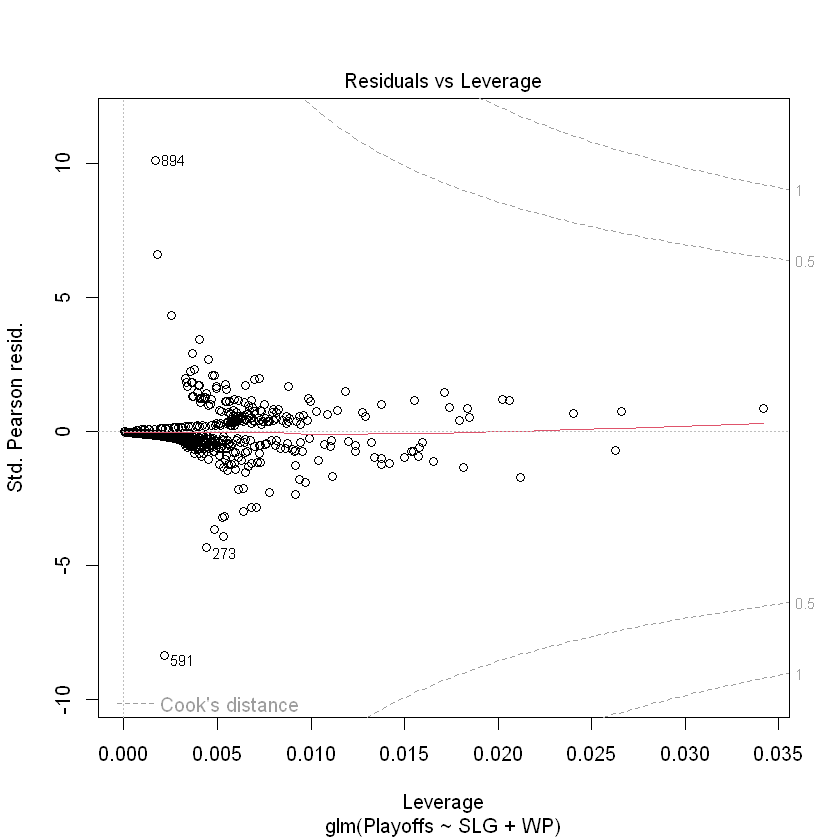

[1] 0.9005076
        Predicted
Playoffs   0   1
       0 749  38
       1  60 138


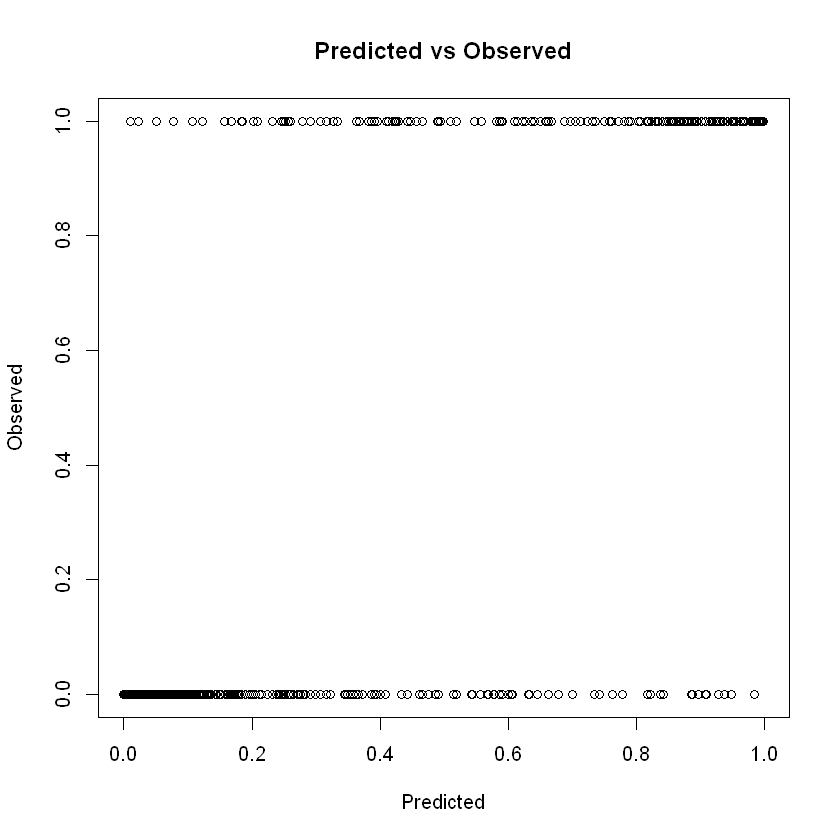

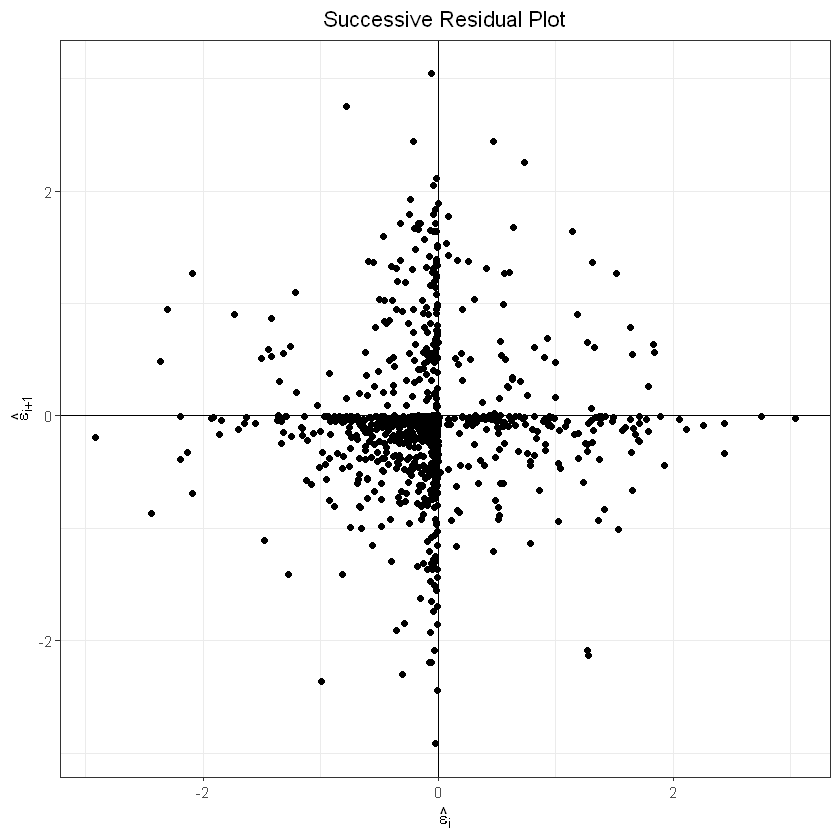

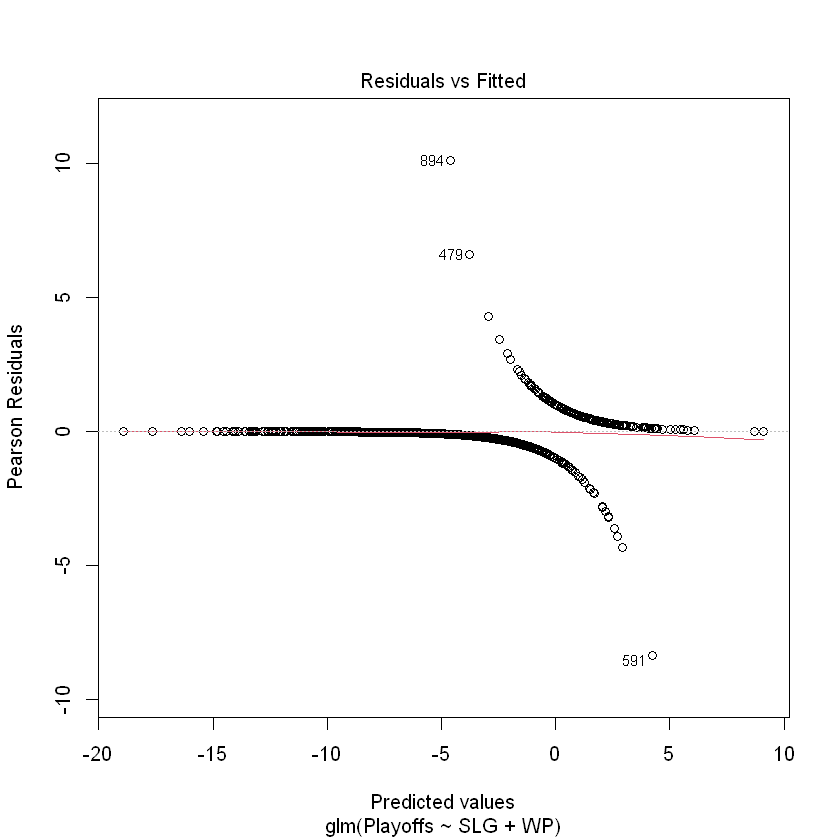

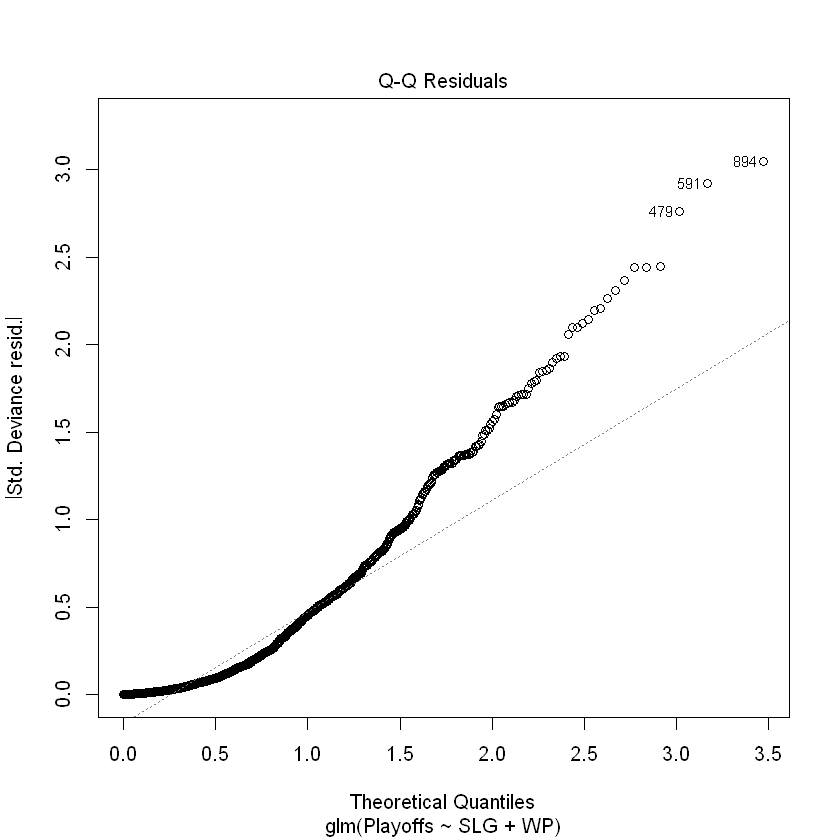

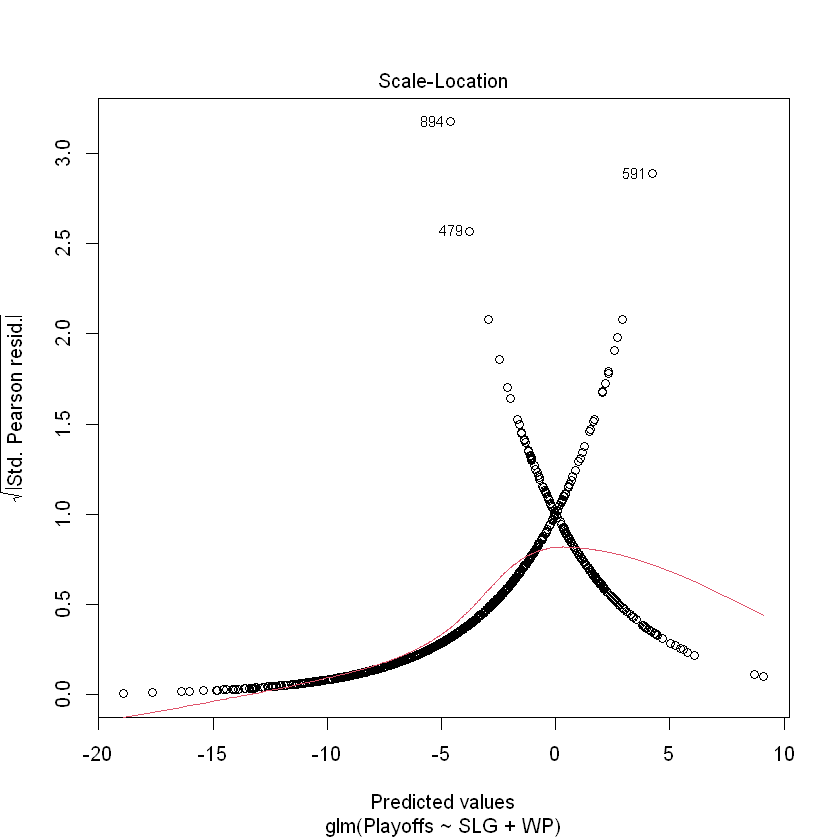

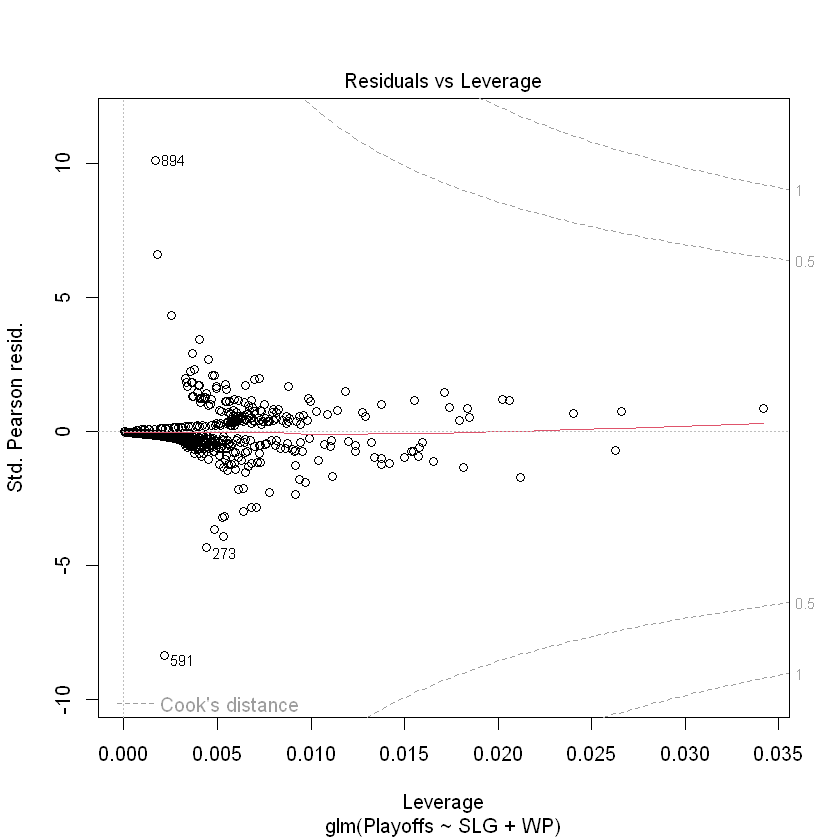

In [206]:
# full dataset - playoffs
diagnostics_plots(df=train_full_playoffs,
                  model=glmod_full_playoffs,
                  response_var='Playoffs',
                  type='response')
plot(glmod_full_playoffs)

The contingency table shows us correct predictions (upper left corner and lower right corner), and the incorrect predictions (lower left corner and upper right corner).

We've used $Accuracy = \frac{Correct}{Total}$ to measure the effectiveness of our model, showing at about 90.1%.

The plot shows predicted to observed. Notice that the heavier concentration of points in the lower left hand corner and upper right hand corner. This indicates a higher prevalance of correct predictions.

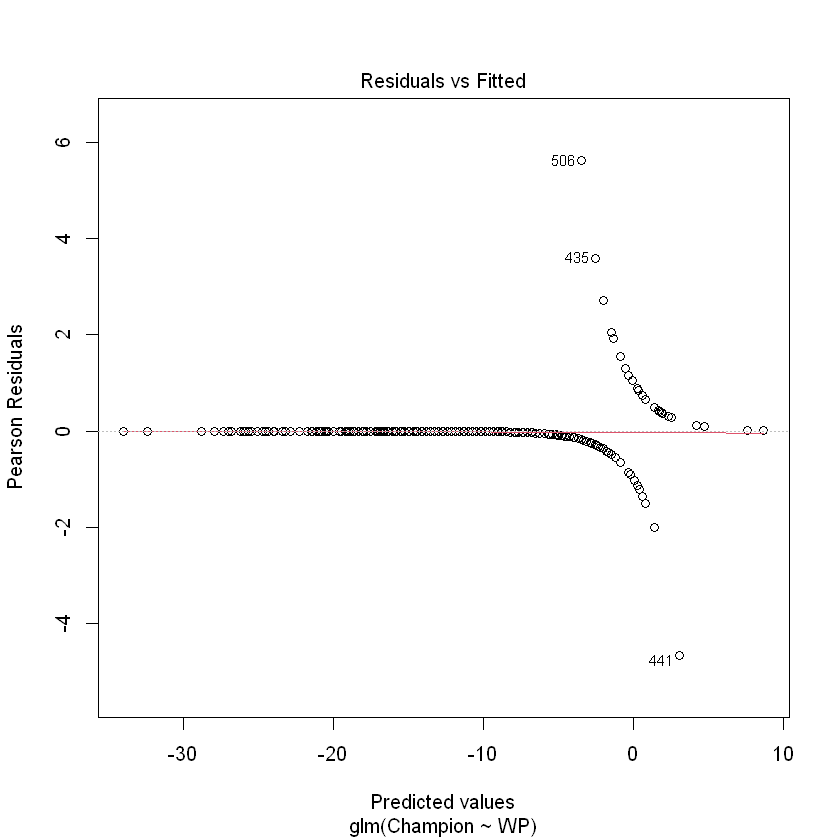

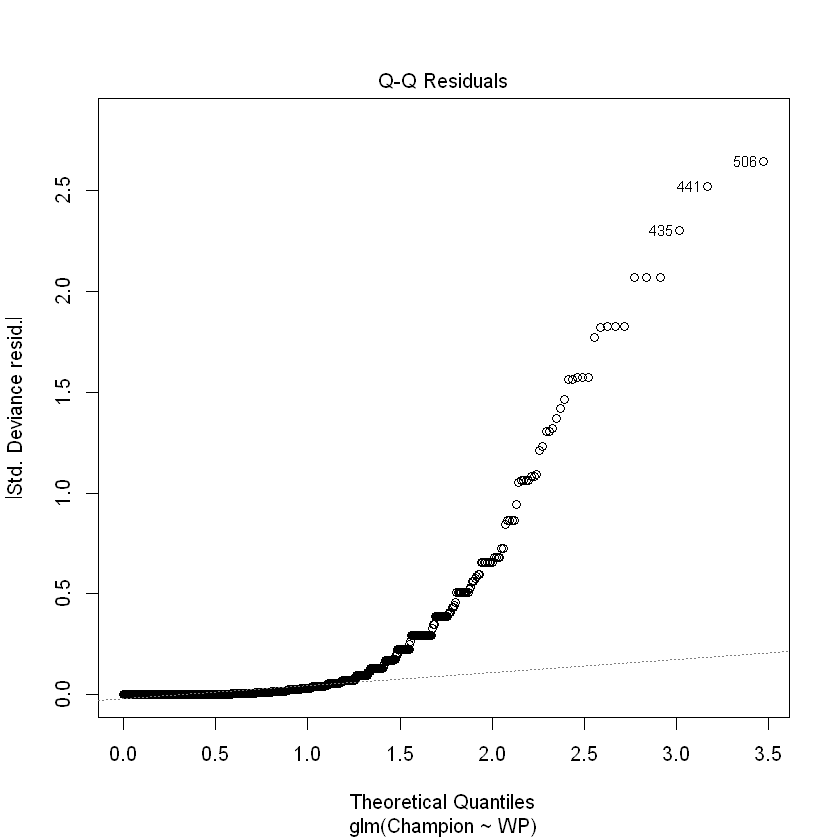

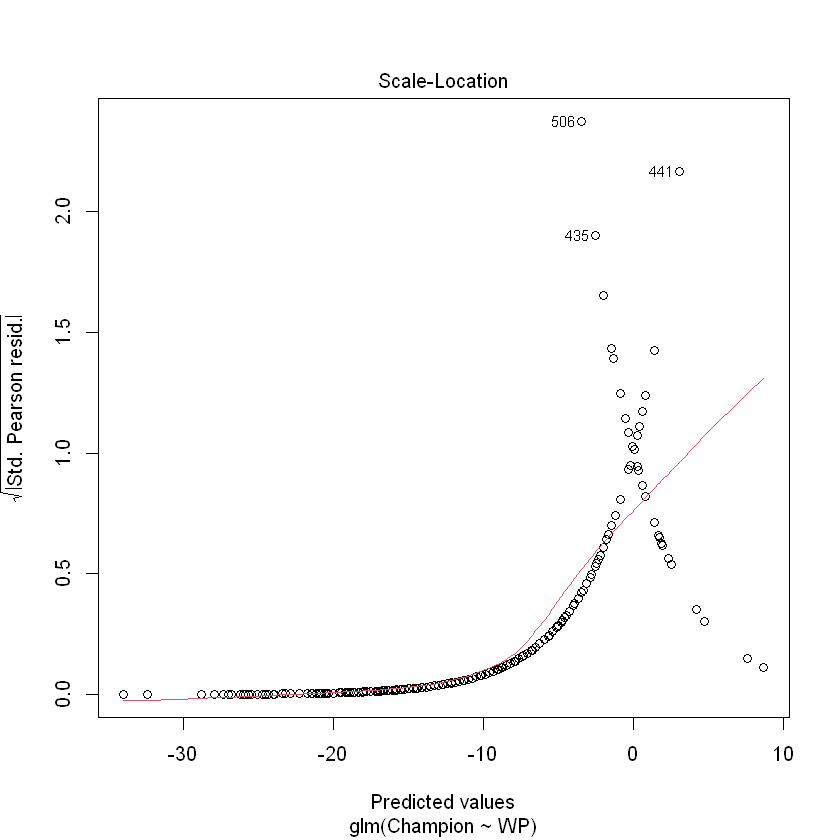

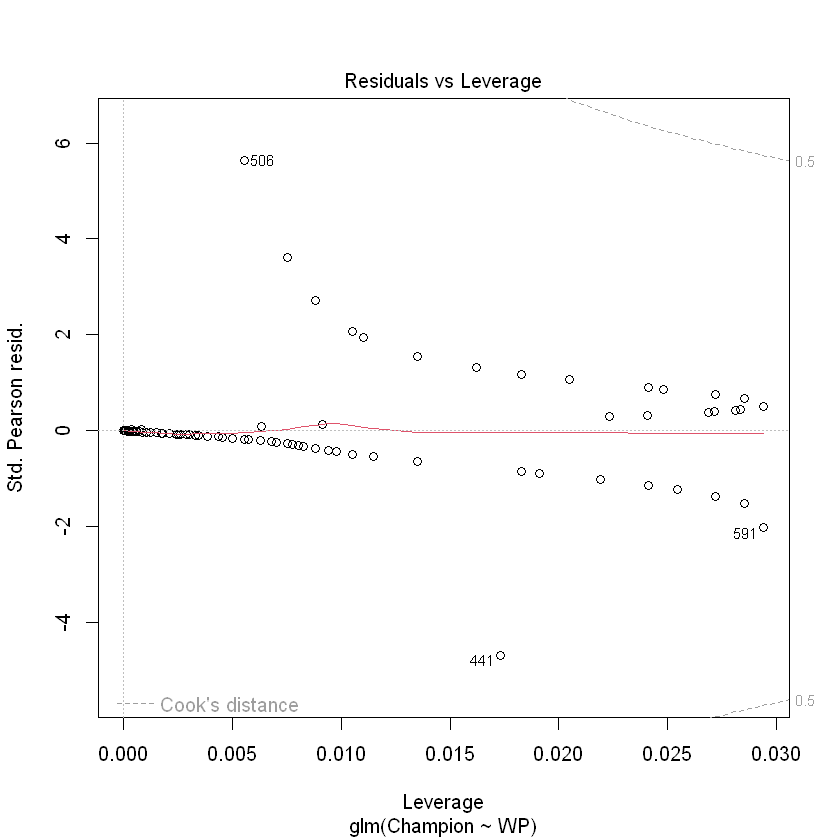

[1] 0.9756345
        Predicted
Champion   0   1
       0 937   9
       1  15  24


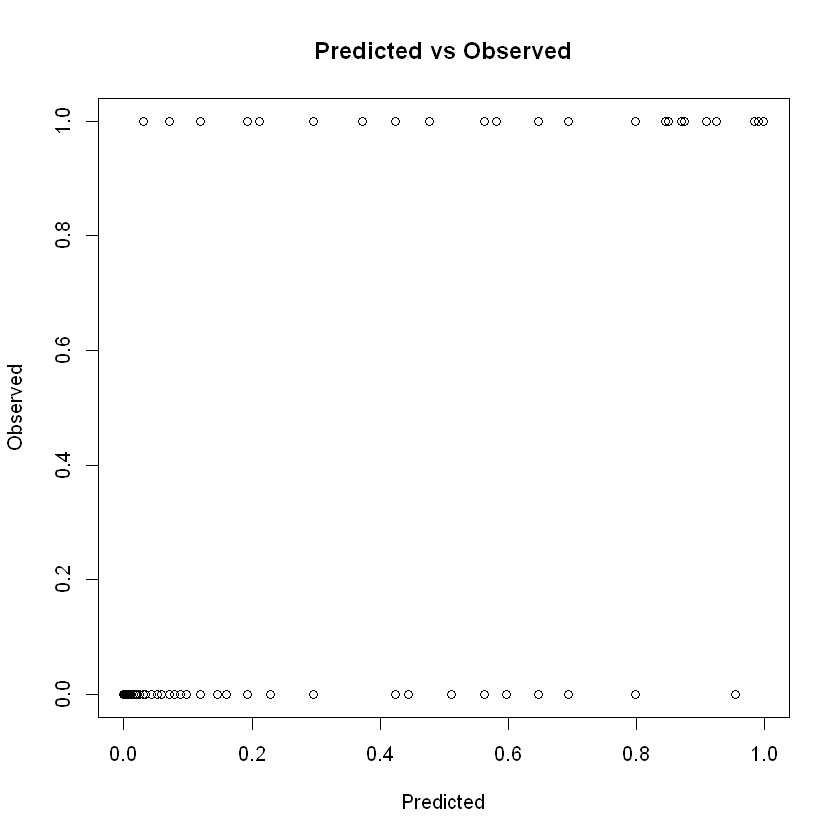

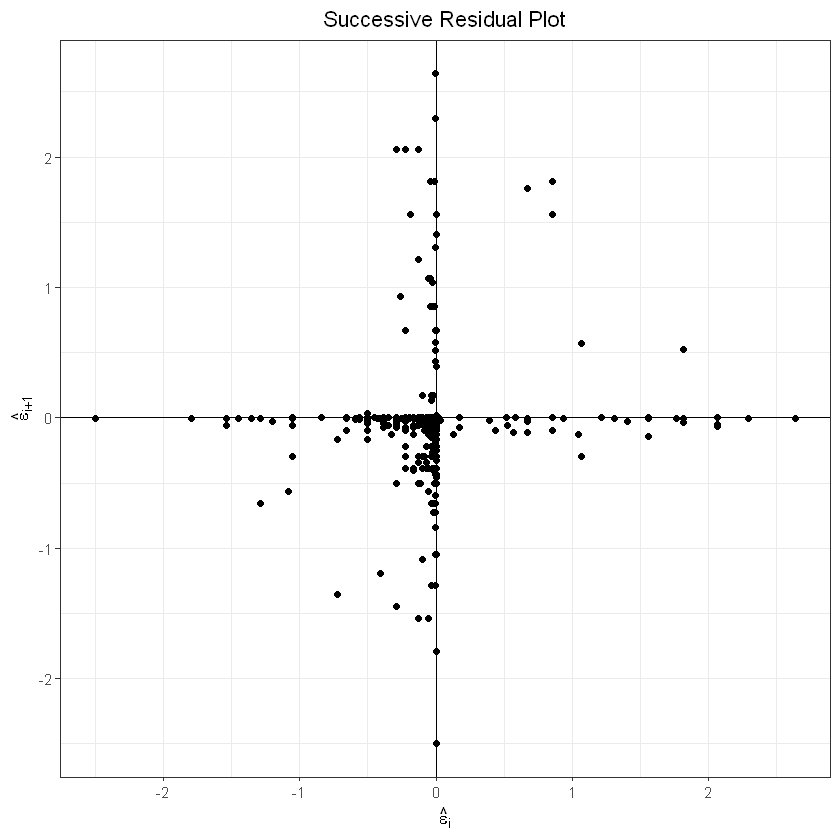

In [207]:
# full dataset - champion
diagnostics_plots(df=train_full_champion,
                  model=glmod_full_champion,
                  response_var='Champion',
                  type='response')

The contingency table shows us correct predictions (upper left corner and lower right corner), and the incorrect predictions (lower left corner and upper right corner).

We've used $Accuracy = \frac{Correct}{Total}$ to measure the effectiveness of our model, showing at about 97.6%.

The plot shows predicted to observed. Notice that the heavier concentration of points in the lower left hand corner and upper right hand corner. This indicates a higher prevalance of correct predictions.

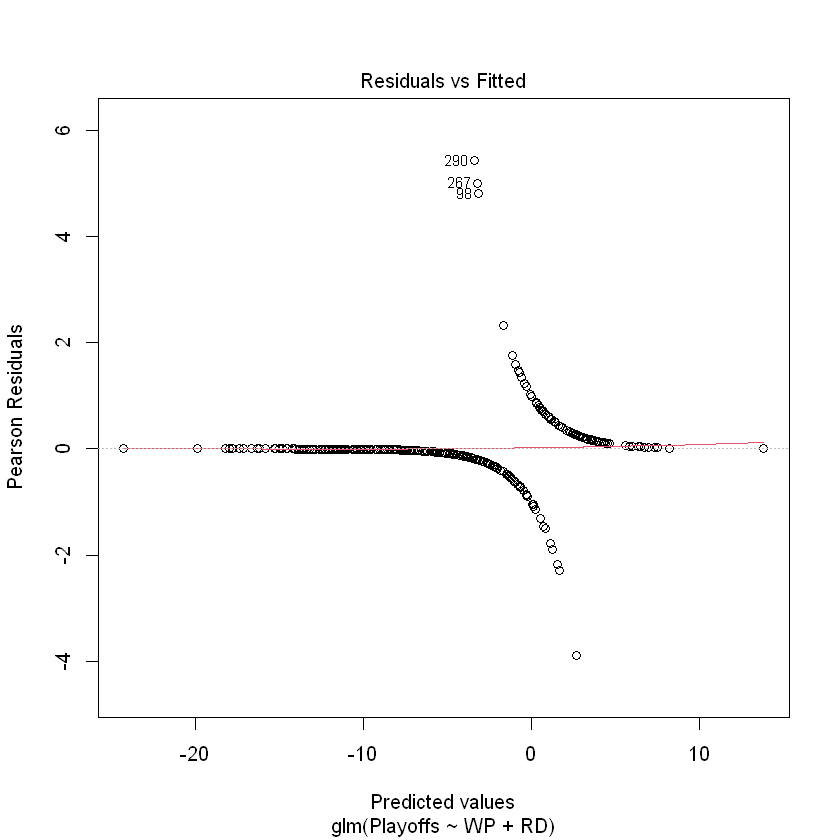

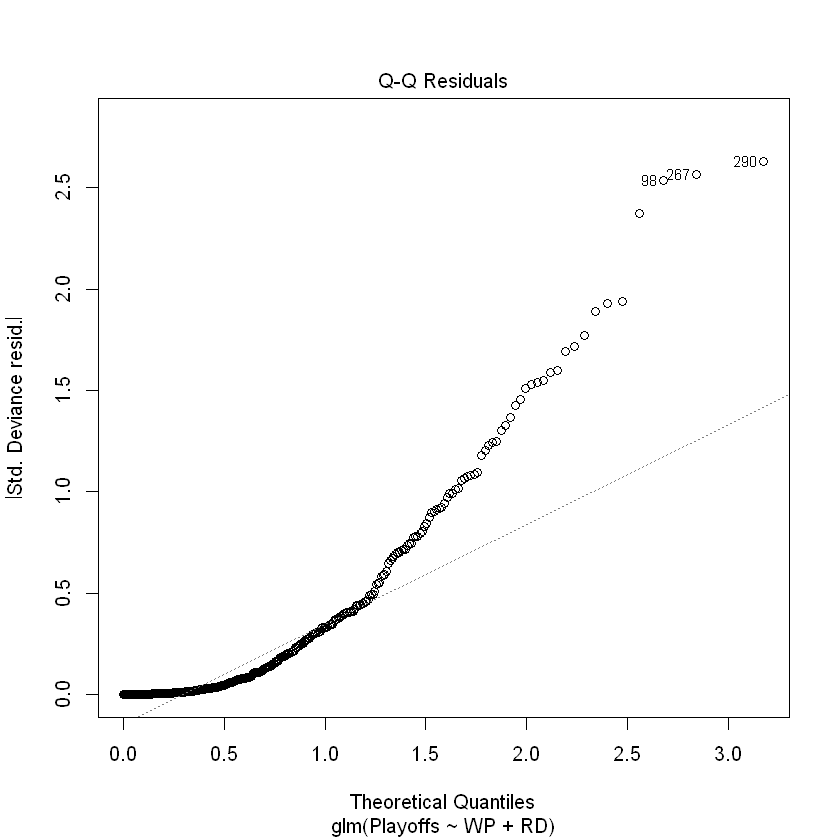

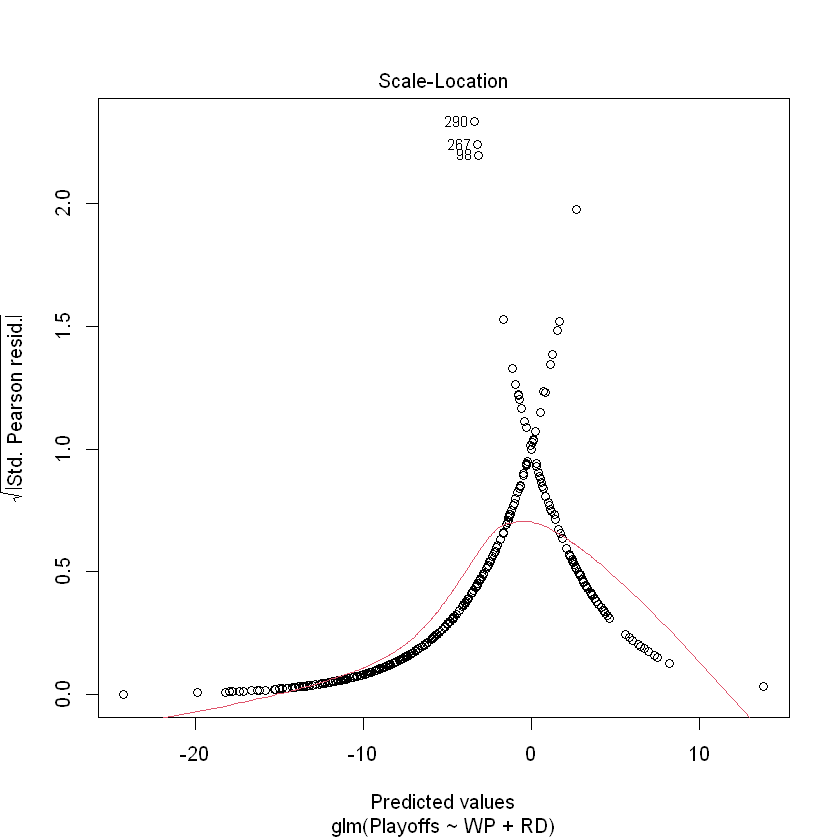

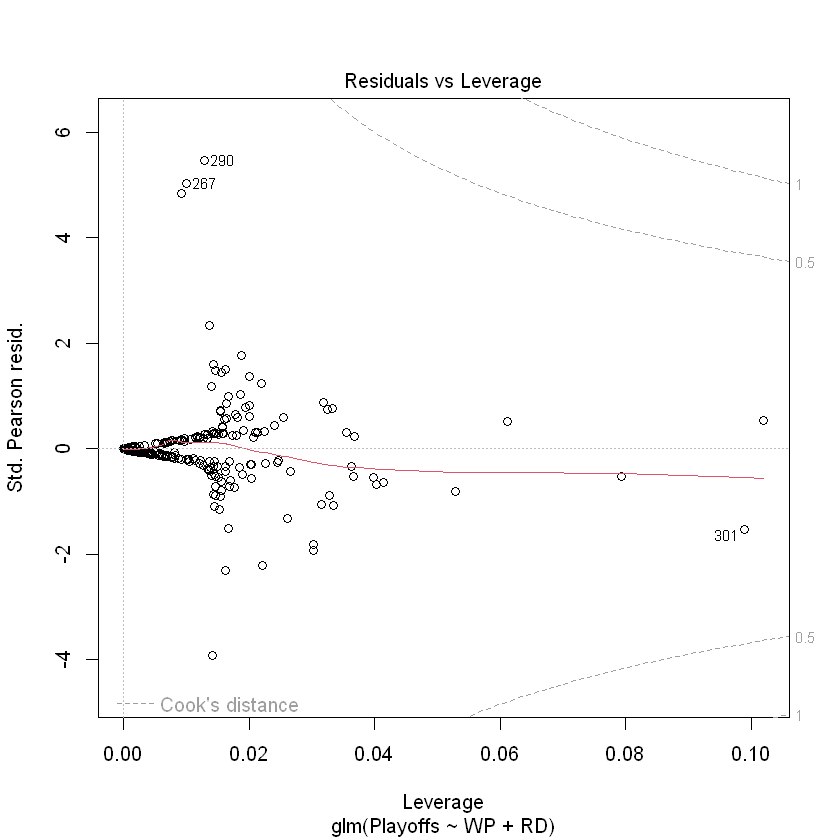

[1] 0.9255952
        Predicted
Playoffs   0   1
       0 234  12
       1  13  77


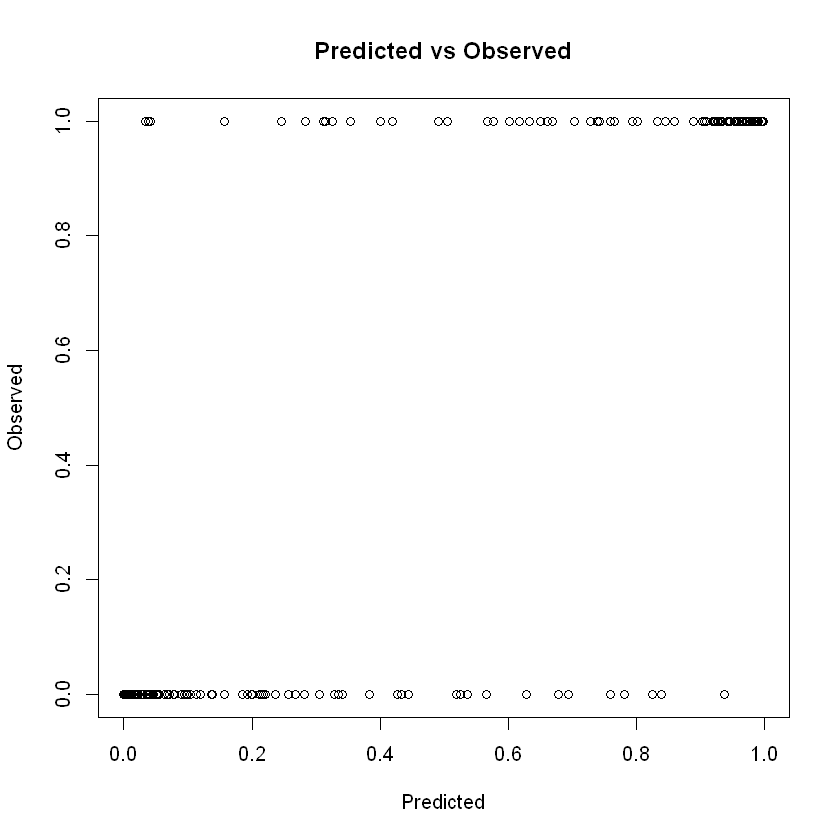

In [147]:
# recent dataset - playoffs
diagnostics_plots(df=train_recent_playoffs,
                  model=glmod_recent_playoffs,
                  response_var='Playoffs',
                  type='response')

The contingency table shows us correct predictions (upper left corner and lower right corner), and the incorrect predictions (lower left corner and upper right corner).

We've used $Accuracy = \frac{Correct}{Total}$ to measure the effectiveness of our model, showing at about 92.6%.

The plot shows predicted to observed. Notice that the heavier concentration of points in the lower left hand corner and upper right hand corner. This indicates a higher prevalance of correct predictions.

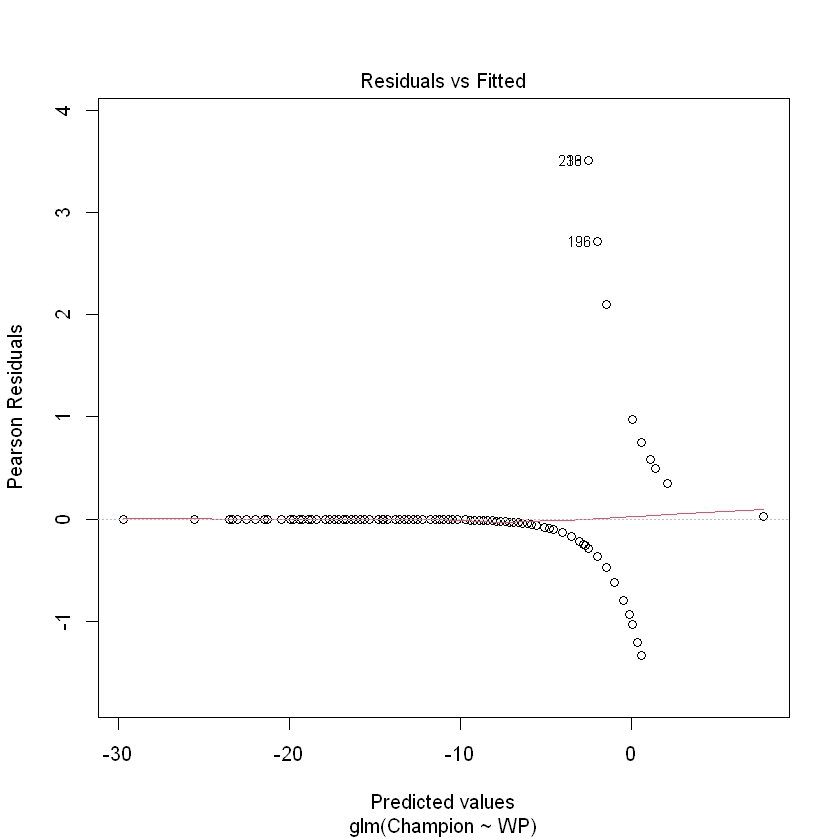

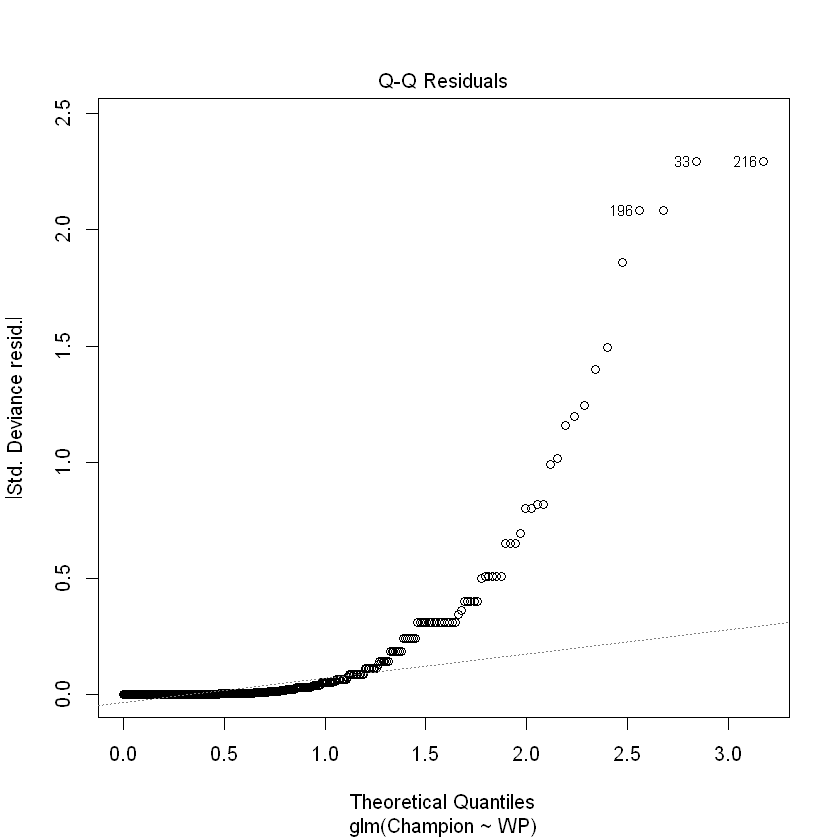

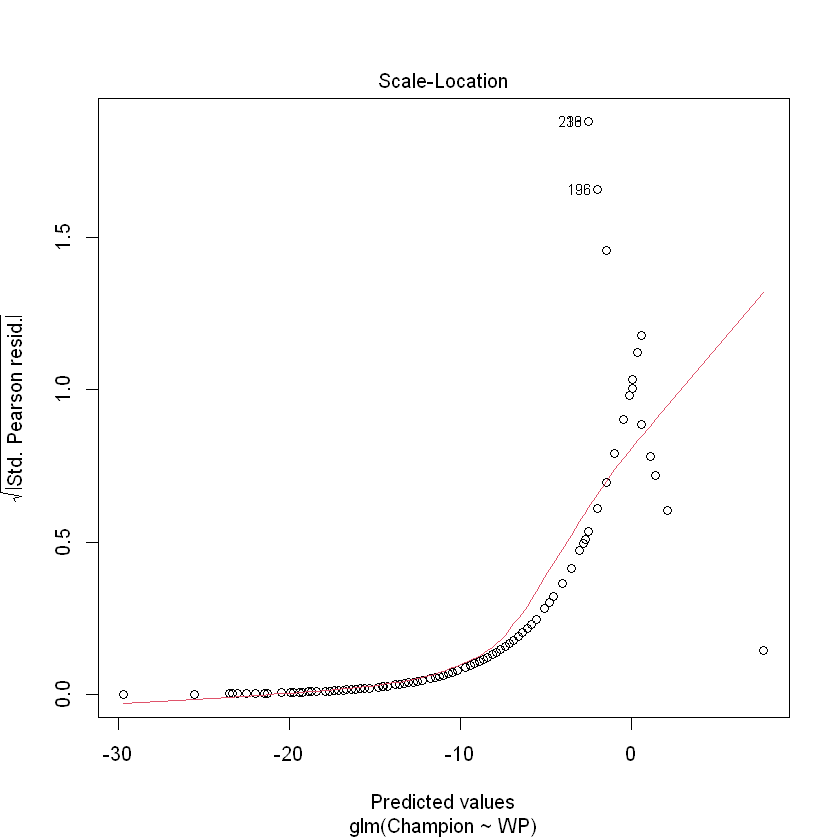

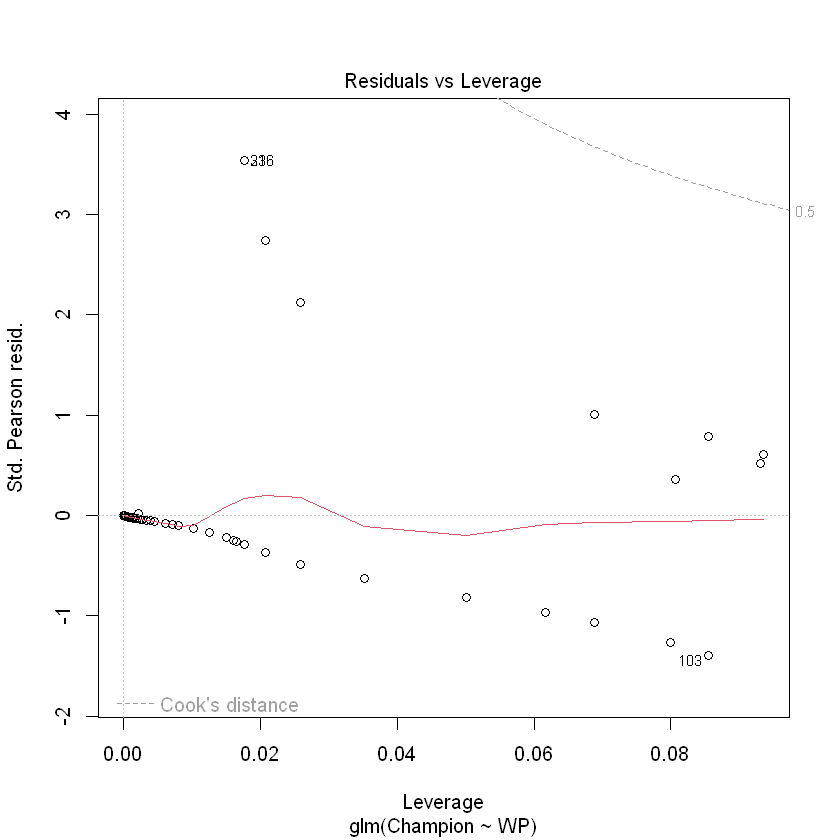

[1] 0.9761905
        Predicted
Champion   0   1
       0 321   3
       1   5   7


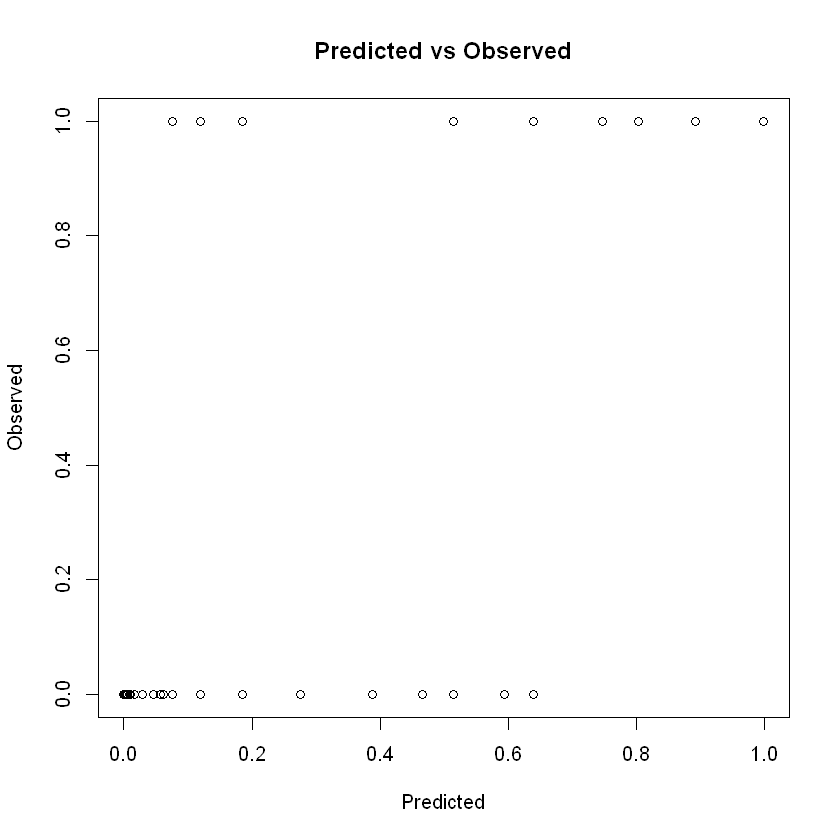

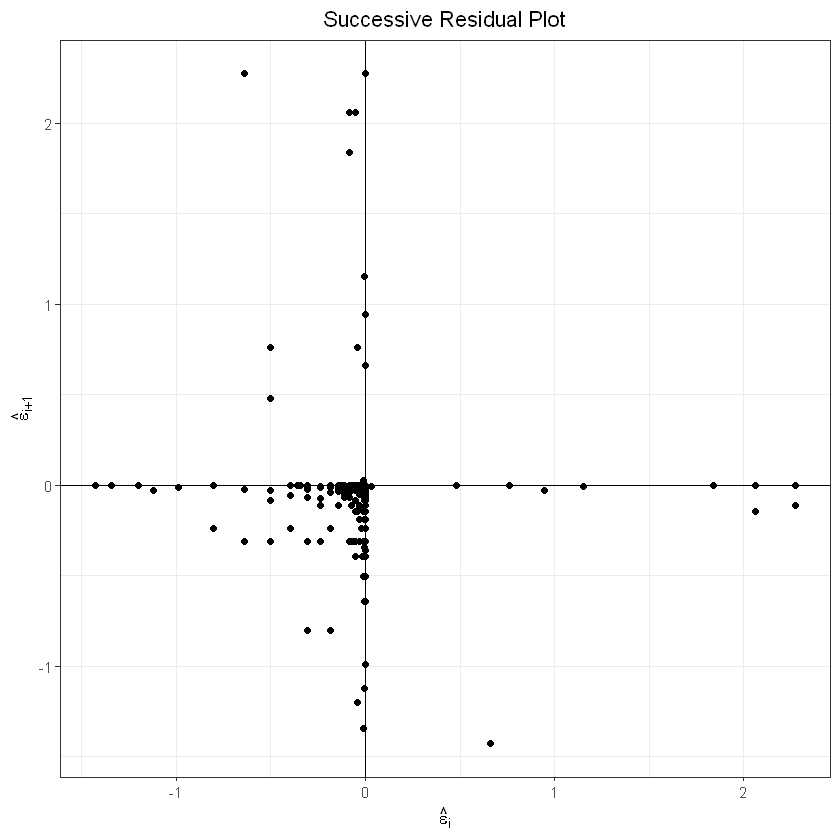

In [208]:
# recent dataset - champion
diagnostics_plots(df=train_recent_champion,
                  model=glmod_recent_champion,
                  response_var='Champion',
                  type='response')

The contingency table shows us correct predictions (upper left corner and lower right corner), and the incorrect predictions (lower left corner and upper right corner).

We've used $Accuracy = \frac{Correct}{Total}$ to measure the effectiveness of our model, showing at about 97.6%.

The plot shows predicted to observed. Notice that the heavier concentration of points in the lower left hand corner and upper right hand corner. This indicates a higher prevalance of correct predictions.

### Commentary - Plotting

Using the contingency table and the accuracy calculated from the table, we can see our models do perform decently with accuracies above 90%.

We'll examine if the required assumptions hold for our models (linearity, independence, constant variance, and normality) as well as examine influential points. Besides some minor variations, the diagnostic plots for all of our models were similar. We can essentially conclude the following for all of our plots:

- **Linearity**: Looking at the observed vs. predicted plots, it's difficult to asses linearity. Using the Residuals vs. Fitted plots, we see a trend of non-linearity in the breaks of the middles. Therefore, linearity is most likely violated.
- **Independence**: Looking at the successive residual plots, we see a cluster of points near the origin in the bottom left quandrant. In other words, we don't really observe constant variance in the plots, thus independence is most likely violated.
- **Constant Variance (homoscedasticity)**: Looking at the Residuals vs. Fitted plots, what we want here is randomness about the x-axis without discerning patterns such as curvature or cone shapes. Specifically for binomial models, we want to see the lines along the x-axis. What we observe in our plots is some curvature, displaying almost asymptotical behavior. Therefore, there is evidence that constant variance is violated.
- **Normality**: Looking at the qq-plots, the plots all begin roughly following the necessary linear qq-line, but then deviate past this. Therefore, there is evidence that normality is violated. 
- **Outliers (influential points)**: Looking at the residuals vs leverage chart, we don't see any points past the Cook's distance threshold, therefore we don't have evidence of the presence of influential points.

### Collinearity

In [149]:
# full dataset - playoffs
print('Full Dataset - Playoffs')
vif(glmod_full_playoffs)
# full dataset - champion
print('Full Dataset - Champion: has only 1 variable')
# vif(glmod_full_champion)
# recent dataset - playoffs
print('Recent Dataset - Playoffs')
vif(glmod_recent_playoffs)
# recent dataset - champion
print('Recent Dataset - Champion: has only 1 variable')
# vif(glmod_recent_champion)

[1] "Full Dataset - Playoffs"


SLG       WP 
1.013629 1.013629

[1] "Full Dataset - Champion: has only 1 variable"
[1] "Recent Dataset - Playoffs"


WP       RD 
2.287642 2.287642

[1] "Recent Dataset - Champion: has only 1 variable"


### Commentary - Collinearity

We only tested for collinearity in the playoff models, as they had more than a single feature. With all variables showing a variance inflation factor (VIF) less than 5, this indicates that collinearity between the features in both playoff models is not an issue.

[Table of Contents](#toc)

[Conclusion](#part-viii)

# VI - Multiple Linear Regression Models <a id="part-vi"></a>

## MLR Data Preparation

In [150]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
# print(col_na)
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
# print(break_na)
# summarize break_na
summary(break_na)
season_break <- max(break_na)
# print(season_break)

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

In [151]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [152]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [153]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [154]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [155]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [156]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

In [157]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
# print(col_na)
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
# print(break_na)
# summarize break_na
summary(break_na)
season_break <- max(break_na)
# print(season_break)

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

In [158]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [159]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [160]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [161]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [162]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [163]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

In [164]:
# full dataset for modeling
df_full_mlr <- df_full %>% select(-c(Year, League))
# recent dataset for modeling
df_recent_mlr <- df_recent %>% select(-c(Year, League))

In [165]:
# train/test split for full data
set.seed(42)
n = floor(0.8 * nrow(df_full_mlr)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_full_mlr)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_full = df_full_mlr[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full = df_full_mlr[-index, ] #set the testing set to be the remaining rows

In [166]:
# train/test split for recent data
set.seed(42)
n = floor(0.8 * nrow(df_recent_mlr)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_recent_mlr)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_recent = df_recent_mlr[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent = df_recent_mlr[-index, ] #set the testing set to be the remaining rows

## MLR Data Modeling

### Model Analysis

**The table printout:**

Each row represents a progressive combination of features, representing the best model of different sizes, with each row adding a new feature. The best models are determined by lowest SSE `SSE`, or sum squared error.

**The Plots:**

The faceted plots show the relationship between the response and each feature used in the model, while the AIC, BIC `BIC`, R2Adj `R2Adj` ($R^2_a$) and MSPE plots are shown for aiding in model selection.

**F-test**

The full (or simultaneous) F-test `full-f-test` is helpful in preventing type I errors when selecting useful predictors in a multiple linear regression model.

### Full Dataset - Winning Percentage (WP)

  (Intercept)   OBP   SLG    BA   RD Playoffs Champion
1        TRUE FALSE FALSE FALSE TRUE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE TRUE     TRUE    FALSE
3        TRUE FALSE FALSE FALSE TRUE     TRUE     TRUE
4        TRUE FALSE FALSE  TRUE TRUE     TRUE     TRUE
5        TRUE  TRUE FALSE  TRUE TRUE     TRUE     TRUE
6        TRUE  TRUE  TRUE  TRUE TRUE     TRUE     TRUE


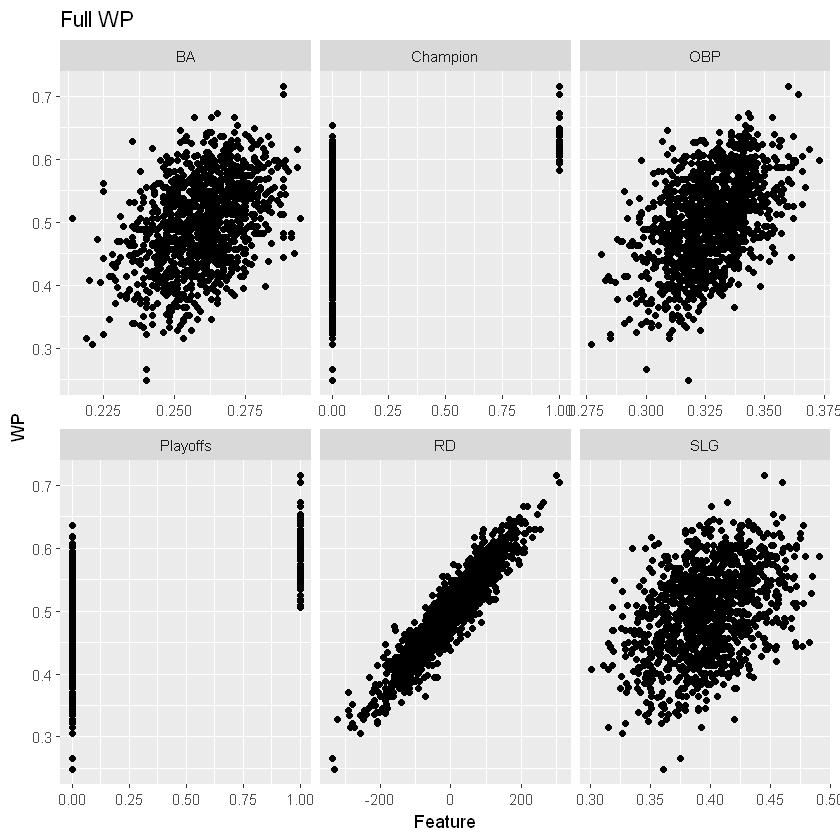

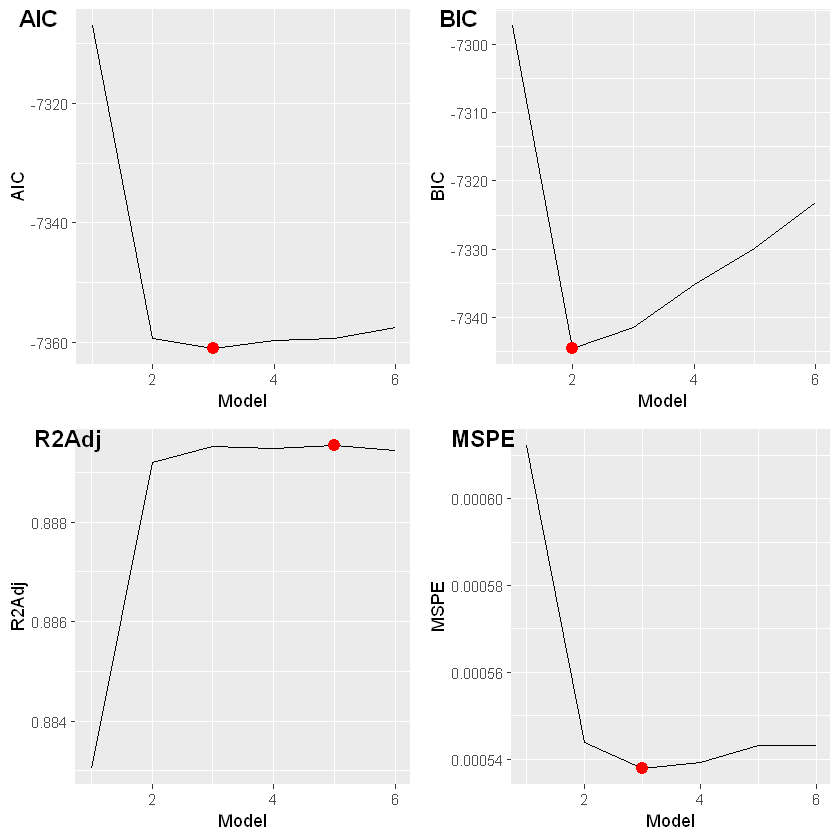

In [167]:
# full data - winning percentage (WP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_full_mlr,
         train_set=train_full,
         test_set=test_full,
         response='WP',
         subset_type='Full')

- AIC reports Model 3 as the best model (minimum)
- BIC reports Model 2 as the best model (minimum)
- $R^2_a$ reports model 5 as the best model (maximum)
- MSPE reports model 3 asthe best model

We have two metrics alluding to Model 3 being the best model to describe the response, and although the other metrics report different best models, the results for Model 3 in those metrics are close. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- RD
- Playoffs
- Champion

In [168]:
lmod <- lm(data=train_full, WP~.)
lmod_full_wp <- lm(data=train_full, WP~RD+Playoffs+Champion)
summary(lmod_full_wp)
anova(lmod_full_wp, lmod)


Call:
lm(formula = WP ~ RD + Playoffs + Champion, data = train_full)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.088287 -0.015903  0.000351  0.016539  0.076162 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.961e-01  8.949e-04 554.372  < 2e-16 ***
RD          6.061e-04  9.093e-06  66.654  < 2e-16 ***
Playoffs    1.614e-02  2.405e-03   6.713 3.23e-11 ***
Champion    8.332e-03  4.309e-03   1.934   0.0535 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02379 on 981 degrees of freedom
Multiple R-squared:  0.8899,	Adjusted R-squared:  0.8895 
F-statistic:  2642 on 3 and 981 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,981,0.5551140,NA,NA,NA,NA
2,978,0.5537638,3,0.001350184,0.7948516,0.4968315


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

### Full Dataset - On Base Percentage (OBP)

  (Intercept)   SLG   BA    WP    RD Playoffs Champion
1        TRUE FALSE TRUE FALSE FALSE    FALSE    FALSE
2        TRUE  TRUE TRUE FALSE FALSE    FALSE    FALSE
3        TRUE  TRUE TRUE  TRUE FALSE    FALSE    FALSE
4        TRUE  TRUE TRUE  TRUE FALSE    FALSE     TRUE
5        TRUE  TRUE TRUE  TRUE  TRUE    FALSE     TRUE
6        TRUE  TRUE TRUE  TRUE  TRUE     TRUE     TRUE


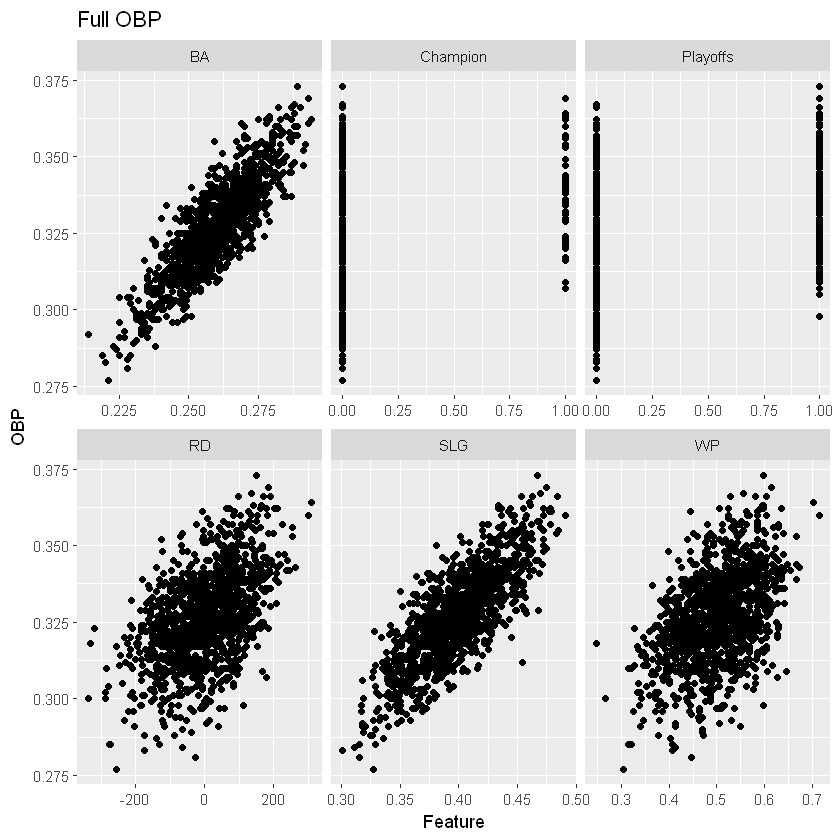

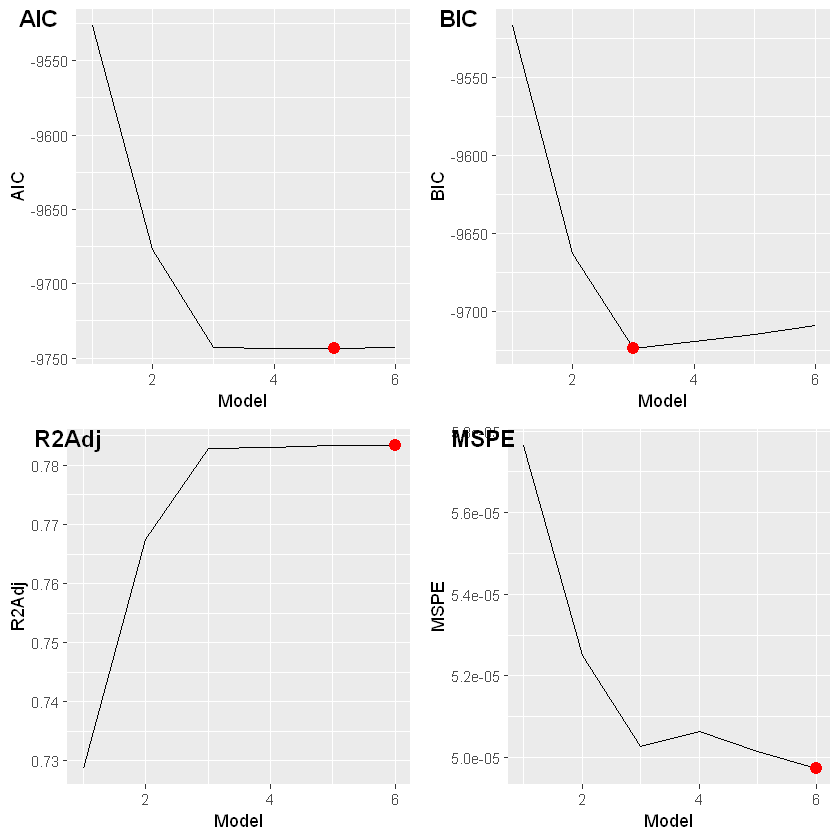

In [169]:
# full data - on-base percentage (OBP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_full_mlr,
         train_set=train_full,
         test_set=test_full,
         response='OBP',
         subset_type='Full')

- AIC reports Model 5 as the best model (minimum)
- BIC reports Model 3 as the best model (minimum)
- $R^2_a$ reports model 6 as the best model (maximum)
- MSPE reports model 6 as the best model

We have two metrics alluding to Model 6 being the best model to describe the response, and for the metrics that don't allude to this being the best, their best are relatively close for Model 3 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- SLG
- BA
- WP

In [170]:
lmod <- lm(data=train_full, OBP~.)
lmod_full_obp <- lm(data=train_full, OBP~SLG+BA+WP)
summary(lmod_full_obp)
anova(lmod_full_obp, lmod)


Call:
lm(formula = OBP ~ SLG + BA + WP, data = train_full)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0196243 -0.0048779 -0.0001481  0.0048063  0.0238899 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.085607   0.004763  17.974   <2e-16 ***
SLG         0.133661   0.011164  11.972   <2e-16 ***
BA          0.667557   0.028847  23.141   <2e-16 ***
WP          0.029312   0.003503   8.368   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007099 on 981 degrees of freedom
Multiple R-squared:  0.7834,	Adjusted R-squared:  0.7828 
F-statistic:  1183 on 3 and 981 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,981,0.04944351,NA,NA,NA,NA
2,978,0.04915107,3,0.0002924418,1.939653,0.1215094


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

### Full Dataset - Slugging Percentage (SLG)

  (Intercept)  OBP    BA    WP    RD Playoffs Champion
1        TRUE TRUE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE TRUE  TRUE FALSE FALSE    FALSE    FALSE
3        TRUE TRUE  TRUE FALSE FALSE     TRUE    FALSE
4        TRUE TRUE  TRUE  TRUE FALSE     TRUE    FALSE
5        TRUE TRUE  TRUE  TRUE FALSE     TRUE     TRUE
6        TRUE TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


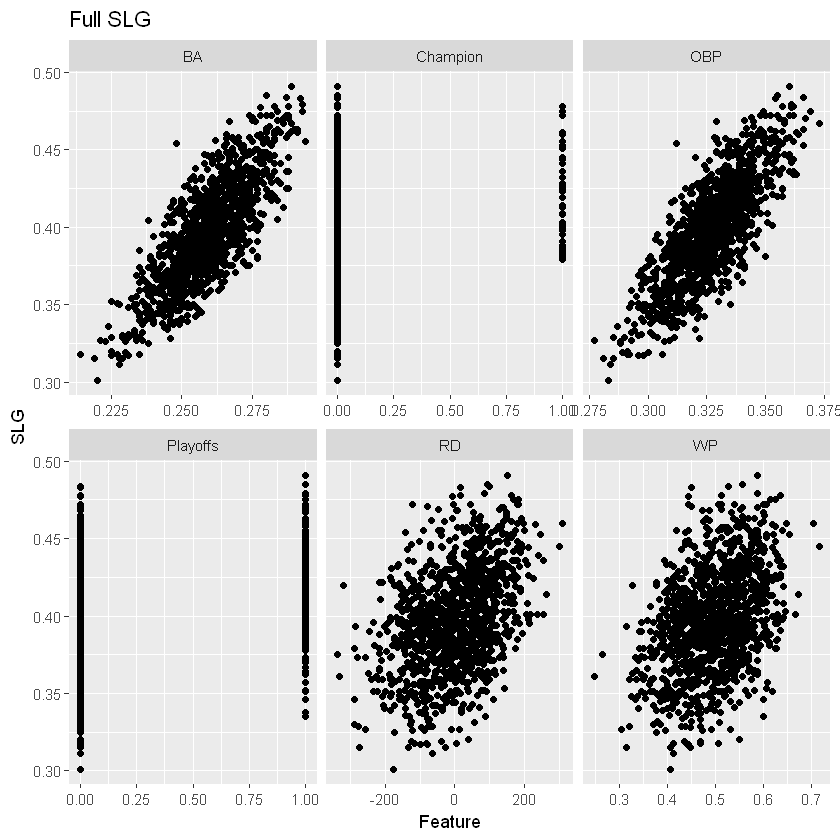

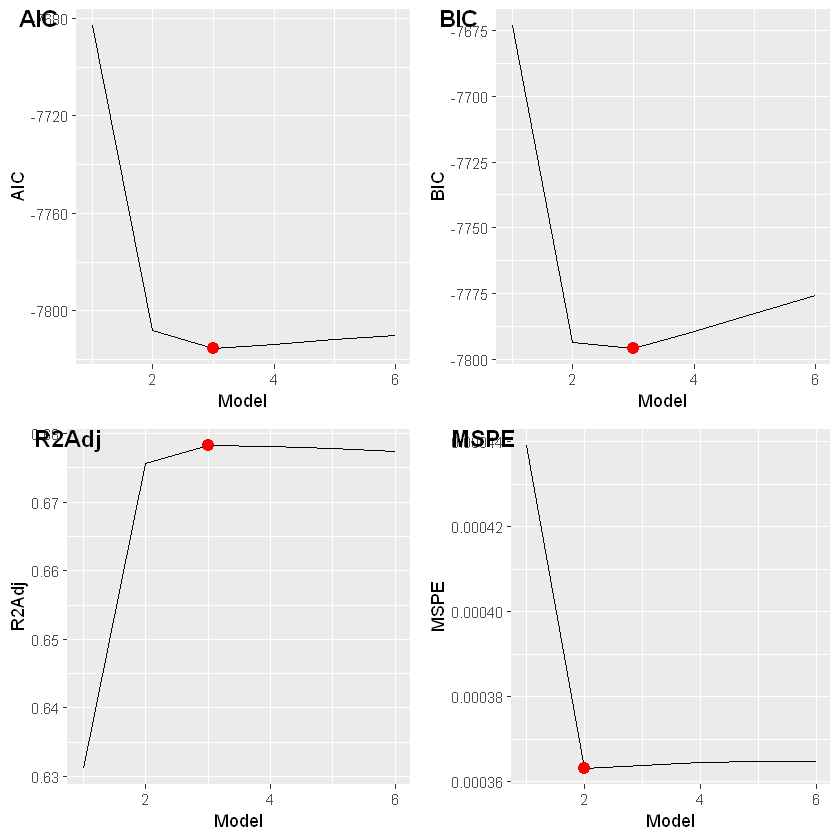

In [171]:
# full data - slugging percentage (SLG)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_full_mlr,
         train_set=train_full,
         test_set=test_full,
         response='SLG',
         subset_type='Full')

- AIC reports Model 3 as the best model (minimum)
- BIC reports Model 3 as the best model (minimum)
- $R^2_a$ reports model 3 as the best model (maximum)
- MSPE reports model 2 as the best model

We have three metrics alluding to Model 3 being the best model to describe the response, and the metric that doesn't allude to this being the best, their best is relatively close for Model 3 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- OBP
- BA
- Playoffs

In [172]:
lmod <- lm(data=train_full, SLG~.)
lmod_full_slg <- lm(data=train_full, SLG~OBP+BA+Playoffs)
summary(lmod_full_obp)
anova(lmod_full_slg, lmod)


Call:
lm(formula = OBP ~ SLG + BA + WP, data = train_full)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0196243 -0.0048779 -0.0001481  0.0048063  0.0238899 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.085607   0.004763  17.974   <2e-16 ***
SLG         0.133661   0.011164  11.972   <2e-16 ***
BA          0.667557   0.028847  23.141   <2e-16 ***
WP          0.029312   0.003503   8.368   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007099 on 981 degrees of freedom
Multiple R-squared:  0.7834,	Adjusted R-squared:  0.7828 
F-statistic:  1183 on 3 and 981 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,981,0.3499427,NA,NA,NA,NA
2,978,0.3497889,3,0.0001538251,0.1433636,0.9339322


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

### Recent Dataset - Winning Percentage (WP)

  (Intercept)   OBP   SLG    BA   RD  OOBP  OSLG Playoffs Champion
1        TRUE FALSE FALSE FALSE TRUE FALSE FALSE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE TRUE FALSE FALSE     TRUE    FALSE
3        TRUE FALSE FALSE FALSE TRUE  TRUE FALSE     TRUE    FALSE
4        TRUE FALSE  TRUE FALSE TRUE  TRUE FALSE     TRUE    FALSE
5        TRUE FALSE  TRUE FALSE TRUE  TRUE FALSE     TRUE     TRUE
6        TRUE FALSE  TRUE FALSE TRUE  TRUE  TRUE     TRUE     TRUE
7        TRUE  TRUE  TRUE FALSE TRUE  TRUE  TRUE     TRUE     TRUE
8        TRUE  TRUE  TRUE  TRUE TRUE  TRUE  TRUE     TRUE     TRUE


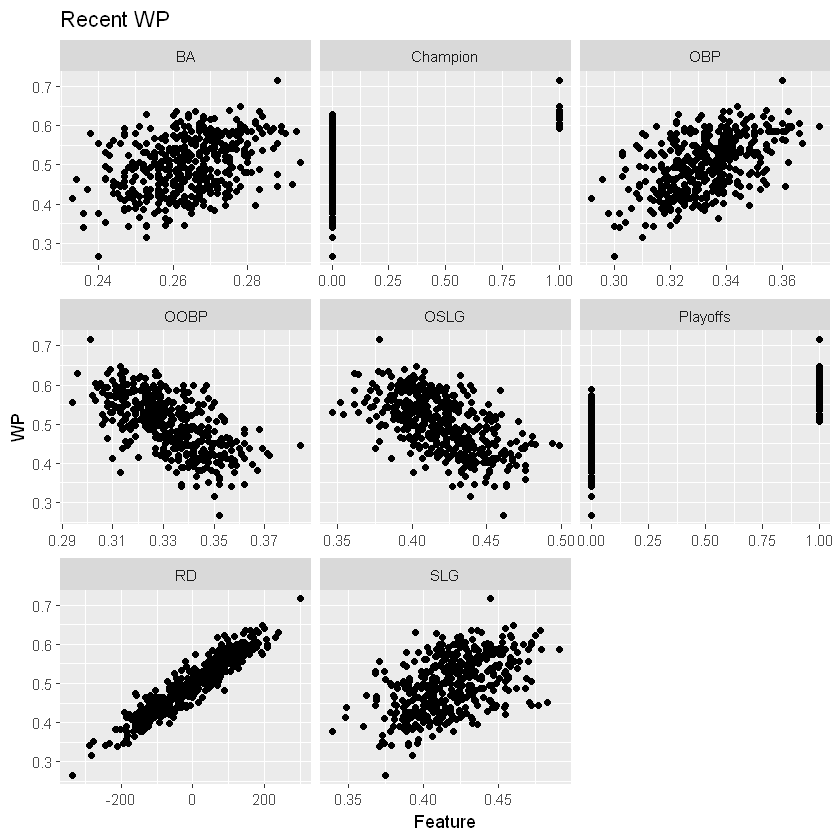

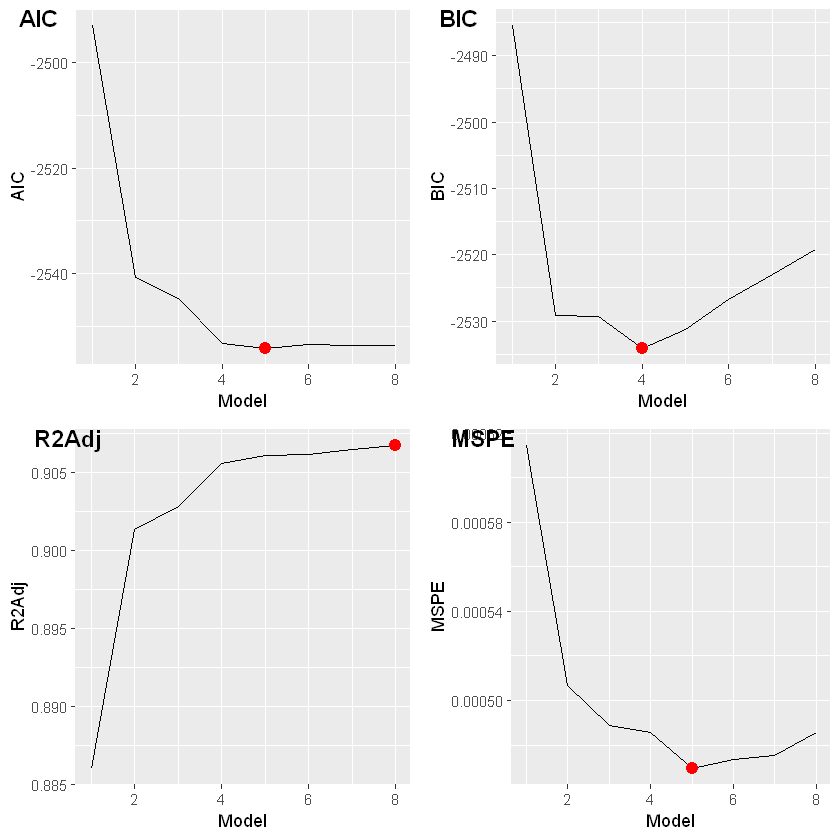

In [173]:
# recent data - winning percentage (WP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_recent_mlr,
         train_set=train_recent,
         test_set=test_recent,
         response='WP',
         subset_type='Recent')

- AIC reports Model 5 as the best model (minimum)
- BIC reports Model 4 as the best model (minimum)
- $R^2_a$ reports model 8 as the best model (maximum)
- MSPE reports model 5 as the best model

We have three metrics alluding to Model 5 being the best model to describe the response, and the metrics that don't allude to this being the best, their best are relatively close for Model 5 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 5 as our best model, with the features:

- SLG
- RD
- OOBP
- Playoffs
- Champion

In [174]:
lmod <- lm(data=train_recent, WP~.)
lmod_recent_wp <- lm(data=train_recent, WP~SLG+RD+OOBP+Playoffs+Champion)
summary(lmod_recent_wp)
anova(lmod_recent_wp, lmod)


Call:
lm(formula = WP ~ SLG + RD + OOBP + Playoffs + Champion, data = train_recent)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.059788 -0.015633 -0.000087  0.014128  0.063779 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.840e-01  3.358e-02  17.392  < 2e-16 ***
SLG          2.492e-01  7.978e-02   3.124  0.00194 ** 
RD           4.632e-04  2.593e-05  17.865  < 2e-16 ***
OOBP        -5.891e-01  1.495e-01  -3.941 9.91e-05 ***
Playoffs     2.489e-02  3.621e-03   6.876 3.10e-11 ***
Champion     1.175e-02  6.960e-03   1.688  0.09242 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02216 on 330 degrees of freedom
Multiple R-squared:  0.9075,	Adjusted R-squared:  0.9061 
F-statistic: 647.2 on 5 and 330 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,330,0.1620059,NA,NA,NA,NA
2,327,0.1594018,3,0.0026041,1.780701,0.1506477


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

### Recent Dataset - On Base Percentage (OBP)

  (Intercept)   SLG   BA    WP    RD  OOBP  OSLG Playoffs Champion
1        TRUE FALSE TRUE FALSE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE  TRUE TRUE FALSE FALSE FALSE FALSE    FALSE    FALSE
3        TRUE FALSE TRUE FALSE  TRUE  TRUE FALSE    FALSE    FALSE
4        TRUE FALSE TRUE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
5        TRUE FALSE TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
6        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
7        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE     TRUE    FALSE
8        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


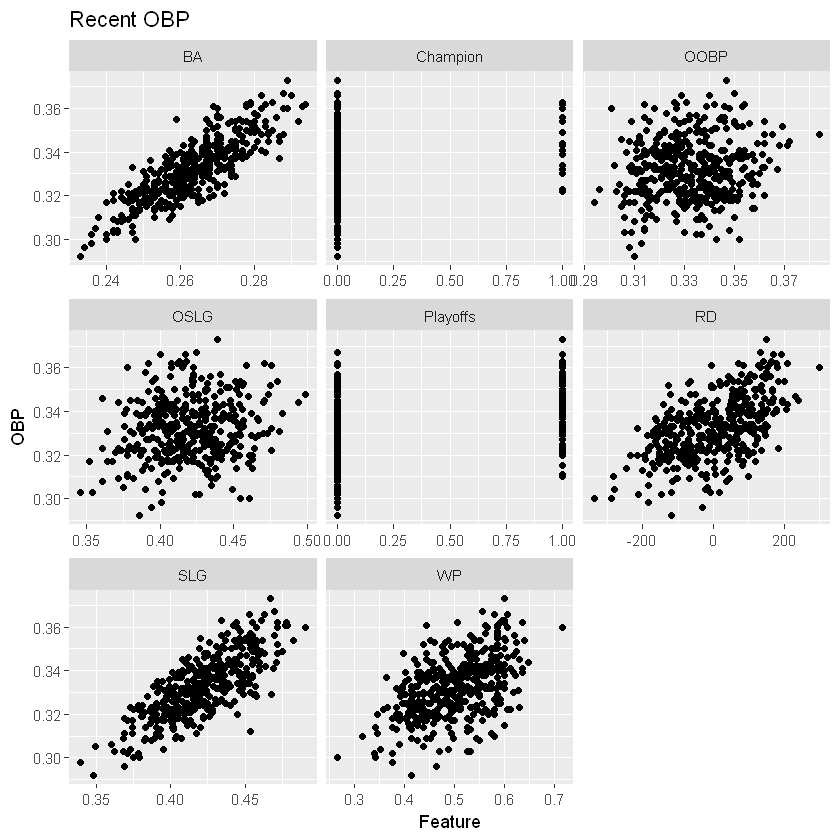

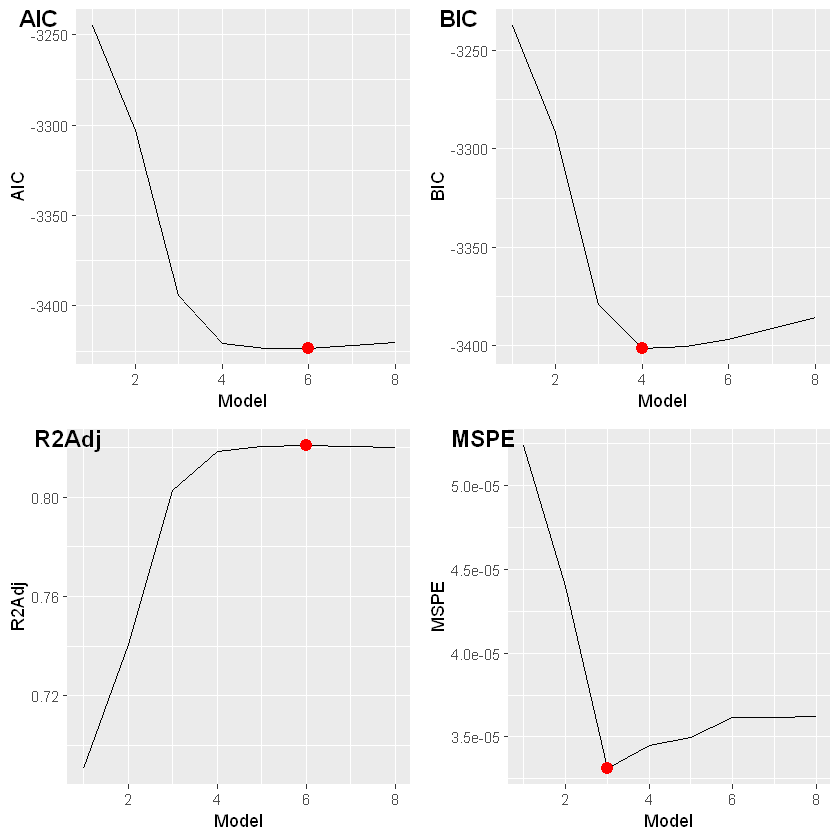

In [175]:
# recent data - on-base percentage (OBP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_recent_mlr,
         train_set=train_recent,
         test_set=test_recent,
         response='OBP',
         subset_type='Recent')

- AIC reports Model 6 as the best model (minimum)
- BIC reports Model 4 as the best model (minimum)
- $R^2_a$ reports model 6 as the best model (maximum)
- MSPE reports model 3 as the best model

We have three metrics alluding to Model 3 being the best model to describe the response, and the metrics that don't allude to this being the best, their best are relatively close for Model 3 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- BA
- RD
- OOBP

> Model 3 does not pass the partial F-test, let's try Model 4.

- BA
- RD
- OOBP
- OSLG

In [176]:
lmod <- lm(data=train_recent, OBP~.)
lmod_recent_obp <- lm(data=train_recent, OBP~BA+RD+OOBP)
summary(lmod_recent_obp)
anova(lmod_recent_obp, lmod)


Call:
lm(formula = OBP ~ BA + RD + OOBP, data = train_recent)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0167828 -0.0041098 -0.0004499  0.0043506  0.0169850 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.628e-02  1.003e-02   4.613 5.68e-06 ***
BA          5.861e-01  4.307e-02  13.607  < 2e-16 ***
RD          8.079e-05  5.856e-06  13.797  < 2e-16 ***
OOBP        3.958e-01  3.829e-02  10.336  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.006367 on 332 degrees of freedom
Multiple R-squared:  0.8046,	Adjusted R-squared:  0.8028 
F-statistic: 455.6 on 3 and 332 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,332,0.01345979,NA,NA,NA,NA
2,327,0.01208833,5,0.001371462,7.41985,1.310247e-06


In [177]:
lmod <- lm(data=train_recent, OBP~.)
lmod_recent_obp <- lm(data=train_recent, OBP~BA+RD+OOBP+OSLG)
summary(lmod_recent_obp)
anova(lmod_recent_obp, lmod)


Call:
lm(formula = OBP ~ BA + RD + OOBP + OSLG, data = train_recent)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0170899 -0.0039947 -0.0002133  0.0039228  0.0165537 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.558e-02  9.784e-03   5.681 2.94e-08 ***
BA          5.060e-01  4.392e-02  11.521  < 2e-16 ***
RD          9.179e-05  5.978e-06  15.355  < 2e-16 ***
OOBP        2.659e-01  4.391e-02   6.055 3.82e-09 ***
OSLG        1.309e-01  2.421e-02   5.408 1.22e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.006113 on 331 degrees of freedom
Multiple R-squared:  0.8204,	Adjusted R-squared:  0.8183 
F-statistic: 378.1 on 4 and 331 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,331,0.01236711,NA,NA,NA,NA
2,327,0.01208833,4,0.0002787801,1.885312,0.1126689


*Note: Model 4 does pass as a sufficient reduced model, and has a higher $R^2_a$ than Model 3 as well.*

*Note: Model 4 passes the full F-test.*

### Recent Dataset - Slugging Percentage (SLG)

  (Intercept)   OBP    BA    WP    RD  OOBP  OSLG Playoffs Champion
1        TRUE  TRUE FALSE FALSE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE    FALSE    FALSE
3        TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
4        TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
5        TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
6        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
7        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE     TRUE    FALSE
8        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


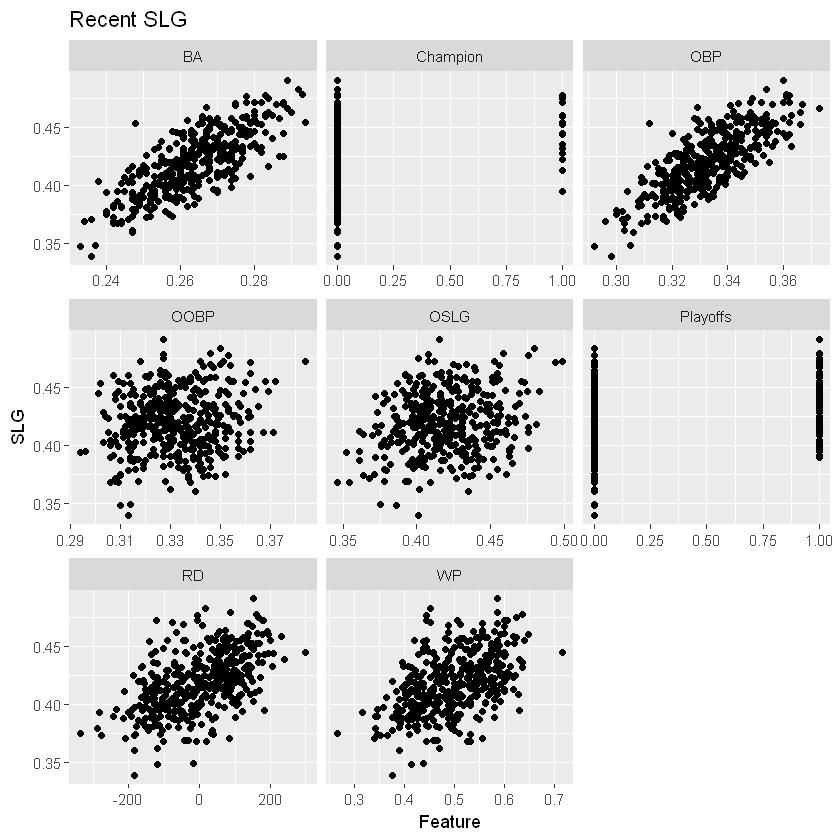

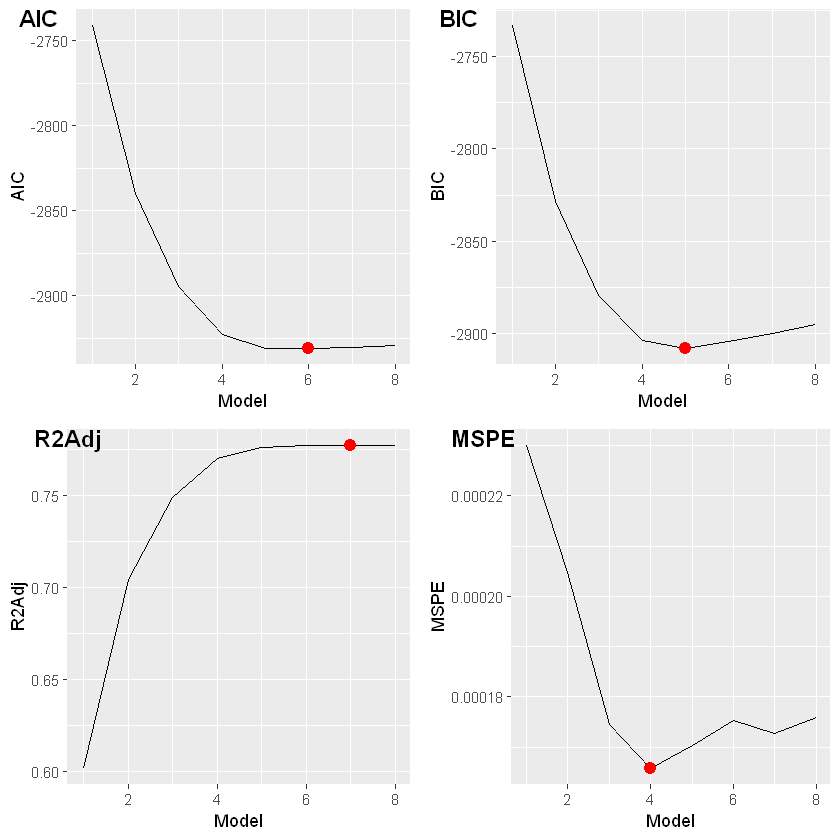

In [178]:
# recent data - slugging percentage (SLG)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_recent_mlr,
         train_set=train_recent,
         test_set=test_recent,
         response='SLG',
         subset_type='Recent')

- AIC reports Model 6 as the best model (minimum)
- BIC reports Model 5 as the best model (minimum)
- $R^2_a$ reports model 7 as the best model (maximum)
- MSPE reports model 4 as the best model

Our metrics are inconclusive as they all allude to different models being the best model. However, let's begin with the simplest model and see if it is sufficient to describe the response through the partial F-test.

Therefore, it's reasonable to use Model 4 as our best model, with the features:

- BA
- RD
- OOBP
- OSLG

> Model 4 does not pass the partial F-test, let's try Model 5.

- BA
- WP
- RD
- OOBP
- OSLG

In [179]:
lmod <- lm(data=train_recent, SLG~.)
lmod_recent_slg <- lm(data=train_recent, SLG~BA+RD+OOBP+OSLG)
summary(lmod_recent_slg)
anova(lmod_recent_slg, lmod)


Call:
lm(formula = SLG ~ BA + RD + OOBP + OSLG, data = train_recent)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.037578 -0.008231 -0.001189  0.008668  0.046028 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.421e-02  2.052e-02  -3.130  0.00191 ** 
BA           5.165e-01  9.211e-02   5.608 4.32e-08 ***
RD           2.122e-04  1.254e-05  16.922  < 2e-16 ***
OOBP         5.330e-01  9.209e-02   5.788 1.65e-08 ***
OSLG         4.064e-01  5.077e-02   8.005 2.05e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01282 on 331 degrees of freedom
Multiple R-squared:  0.7729,	Adjusted R-squared:  0.7702 
F-statistic: 281.6 on 4 and 331 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,331,0.05439008,NA,NA,NA,NA
2,327,0.05209969,4,0.002290393,3.593872,0.006948259


In [180]:
lmod <- lm(data=train_recent, SLG~.)
lmod_recent_slg <- lm(data=train_recent, SLG~BA+WP+RD+OOBP+OSLG)
summary(lmod_recent_slg)
anova(lmod_recent_slg, lmod)


Call:
lm(formula = SLG ~ BA + WP + RD + OOBP + OSLG, data = train_recent)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.036203 -0.008514 -0.000989  0.007824  0.045195 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1170299  0.0262562  -4.457 1.14e-05 ***
BA           0.5048161  0.0909583   5.550 5.88e-08 ***
WP           0.0905859  0.0286744   3.159  0.00173 ** 
RD           0.0001593  0.0000208   7.661 2.07e-13 ***
OOBP         0.5714314  0.0916728   6.233 1.39e-09 ***
OSLG         0.4012907  0.0501229   8.006 2.04e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01265 on 330 degrees of freedom
Multiple R-squared:  0.7796,	Adjusted R-squared:  0.7762 
F-statistic: 233.4 on 5 and 330 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,330,0.05279347,NA,NA,NA,NA
2,327,0.05209969,3,0.0006937836,1.451495,0.2277412


*Note: Model 5 does pass as a sufficient reduced model, and has a higher $R^2_a$ than Model 4 as well.*

*Note: Model 5 passes the full F-test.*

## MLR Results

In [181]:
print('Full Dataset - WP')
lmod_full_wp$coefficients

print('Recent Dataset - WP')
lmod_recent_wp$coefficients

print('Full Dataset - OBP')
lmod_full_obp$coefficients

print('Recent Dataset - OBP')
lmod_recent_obp$coefficients

print('Full Dataset - SLG')
lmod_full_slg$coefficients

print('Recent Dataset - SLG')
lmod_recent_slg$coefficients

[1] "Full Dataset - WP"


(Intercept)           RD     Playoffs     Champion 
0.4961244573 0.0006061088 0.0161423966 0.0083318303

[1] "Recent Dataset - WP"


(Intercept)           SLG            RD          OOBP      Playoffs 
 0.5839715987  0.2492125550  0.0004632125 -0.5891186703  0.0248944150 
     Champion 
 0.0117465336

[1] "Full Dataset - OBP"


(Intercept)         SLG          BA          WP 
 0.08560673  0.13366063  0.66755706  0.02931199

[1] "Recent Dataset - OBP"


(Intercept)           BA           RD         OOBP         OSLG 
5.558145e-02 5.060155e-01 9.179421e-05 2.658620e-01 1.309252e-01

[1] "Full Dataset - SLG"


(Intercept)          OBP           BA     Playoffs 
-0.179198227  0.924648083  1.054280460  0.004932258

[1] "Recent Dataset - SLG"


(Intercept)            BA            WP            RD          OOBP 
-0.1170298474  0.5048161096  0.0905859194  0.0001593308  0.5714313945 
         OSLG 
 0.4012906666

**WP**

- For the full dataset, we have: $y = 0.4961 + 0.0006 \text{ RD } + 0.0161 \text{ Playoffs } + 0.0083 \text{ Champion }$
- For the recent dataset, we have: $y = 0.5840 + 0.2492 \text{ SLG } + 0.0005 \text{ RD } - 0.05891 \text{ OOBP } + 0.0249 \text{ Playoffs } + 0.0117 \text{ Champion }$

**OBP**

- For the full dataset, we have: $y = 0.0856 + 0.1337 \text{ SLG } + 0.6676 \text{ BA } + 0.0293 \text{ WP }$
- For the recent dataset, we have: $y = 0.0556 0.5060 \text{ BA } 9.1794e-05 \text{ RD } 0.2659 \text{ OOBP } 0.1309 \text{ OSLG }$

**SLG**

- For the full dataset, we have: $y = 0.5840 + 0.9246 \text{ OBP } + 1.0543 \text{ BA } + 0.0049 \text{ Playoffs }$
- For the recent dataset, we have: $y = -0.1170 + 0.5048 \text{ BA } + 0.0906 \text{ WP } + 0.0002 \text{ RD } + 0.5714 \text{ OOBP } + 0.4013 \text{ OSLG }$

### Plotting

- Residuals vs. Fitted (constant variance assumption)
- QQ-Plot (normality assumption)
- Residuals vs. Leverage (outliers)
- Predicted vs. Observed (linearity assumption)
- Successive Residual Plot (independence assumption)

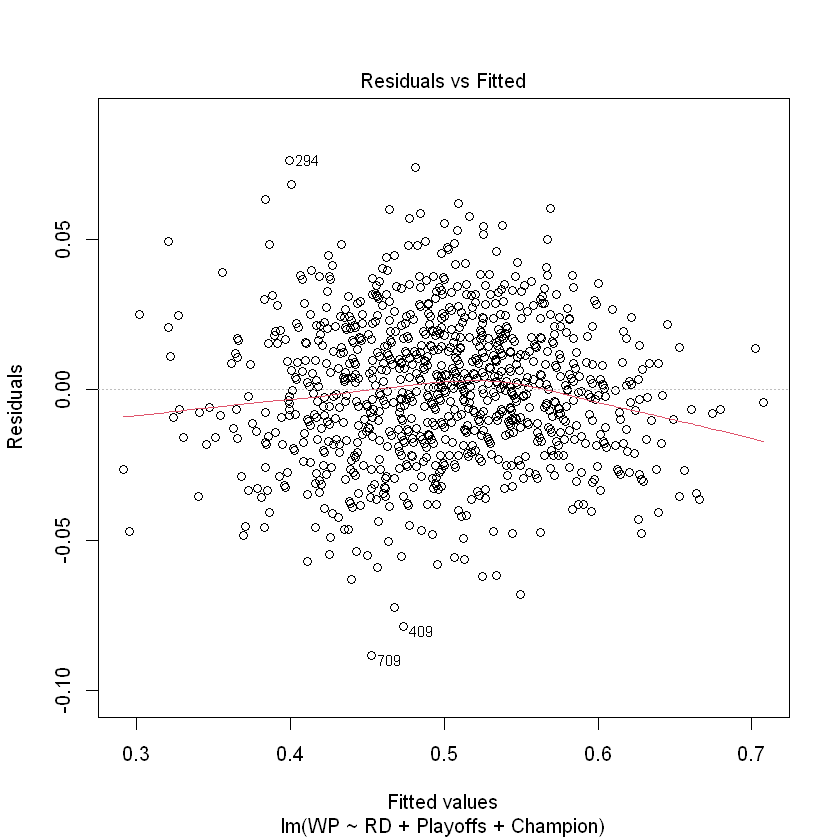

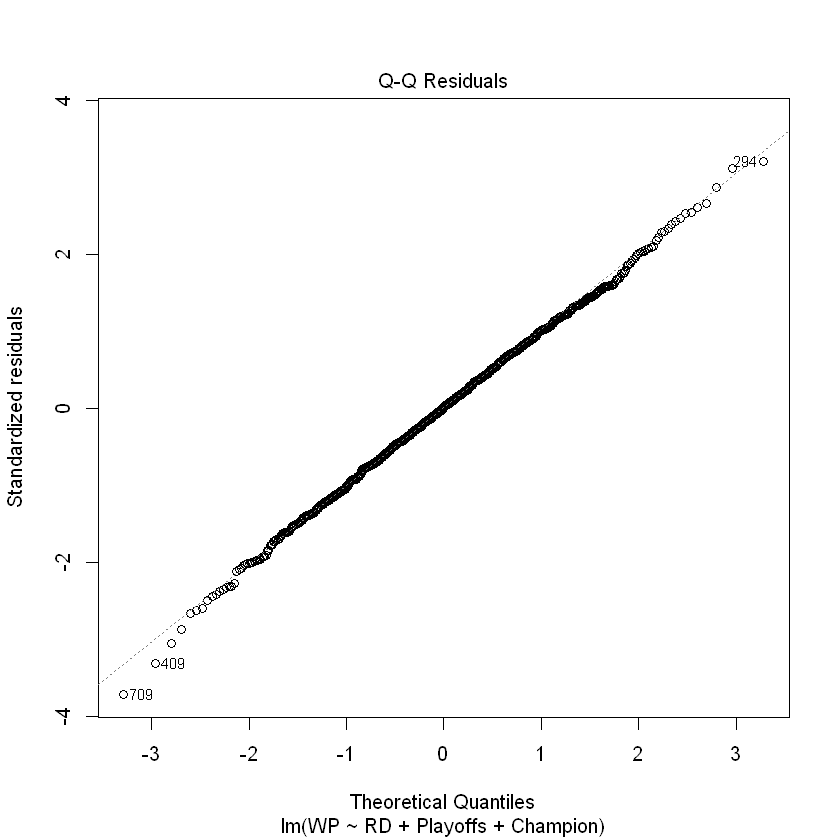

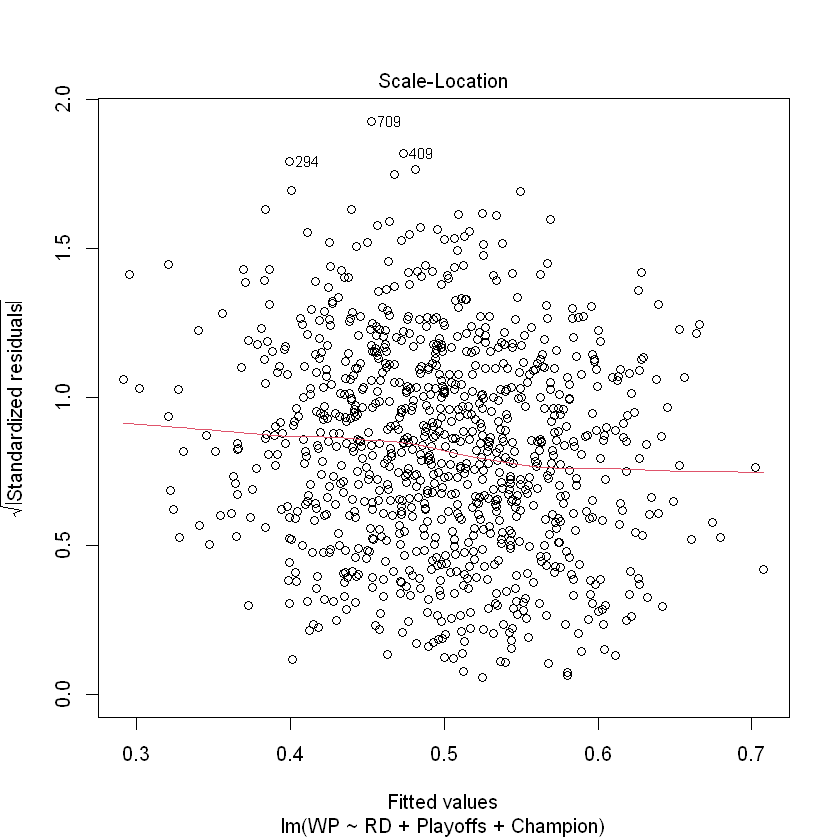

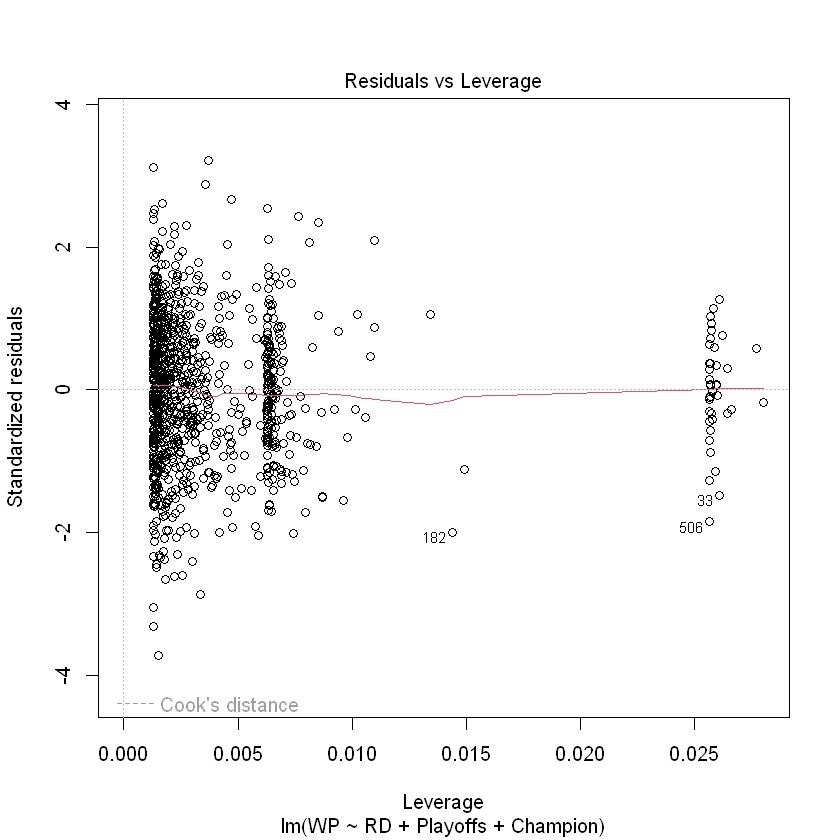

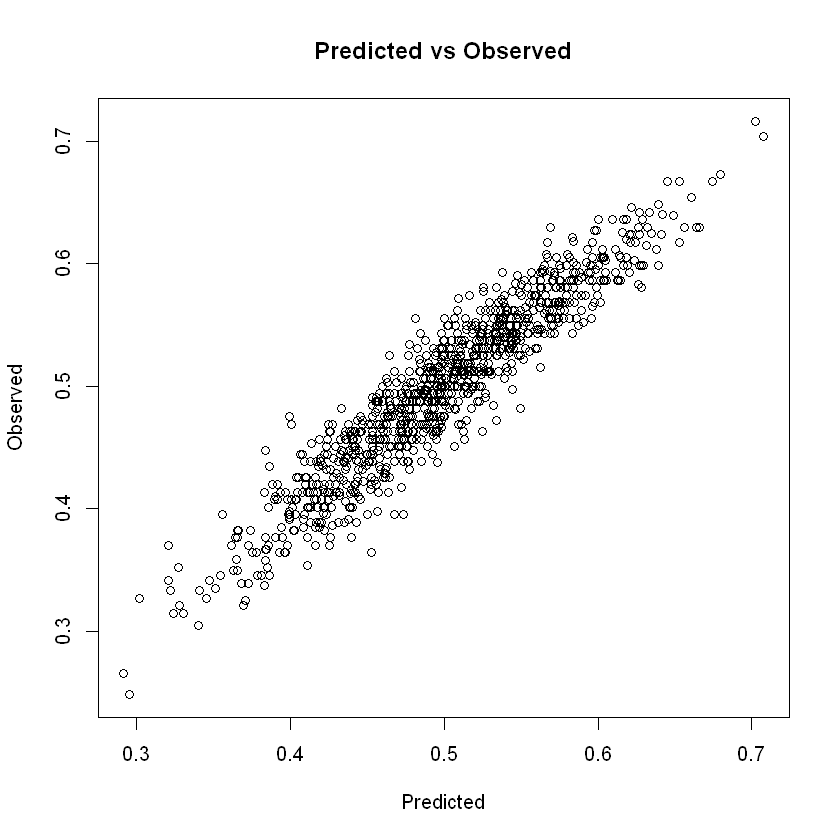

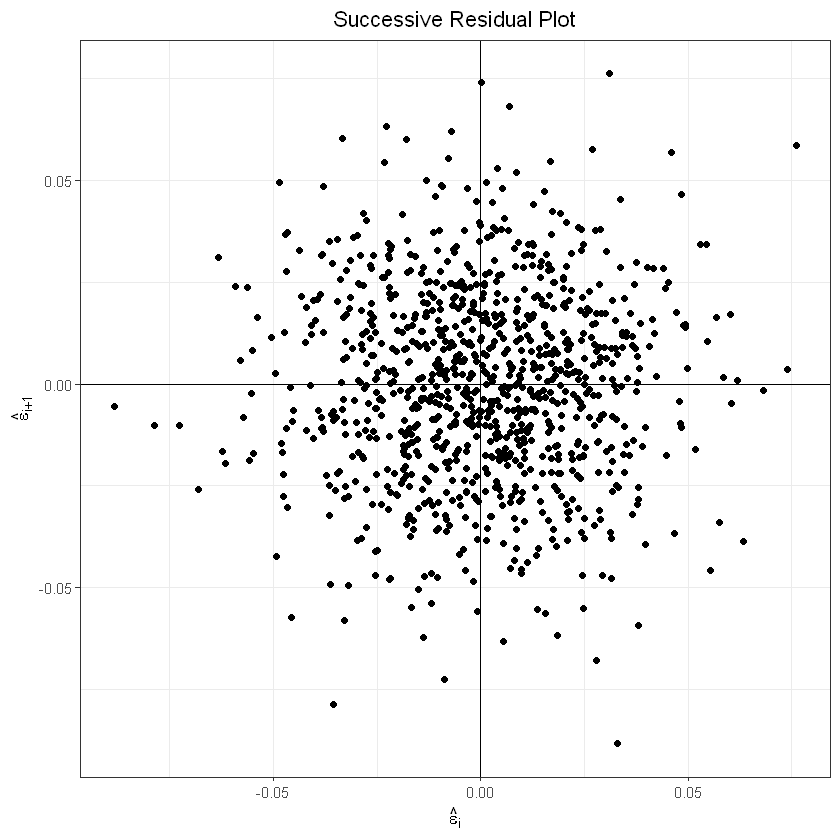

In [182]:
# full dataset - wp
diagnostics_plots(df=train_full,
                  model=lmod_full_wp,
                  response_var='WP',
                  type='linear')

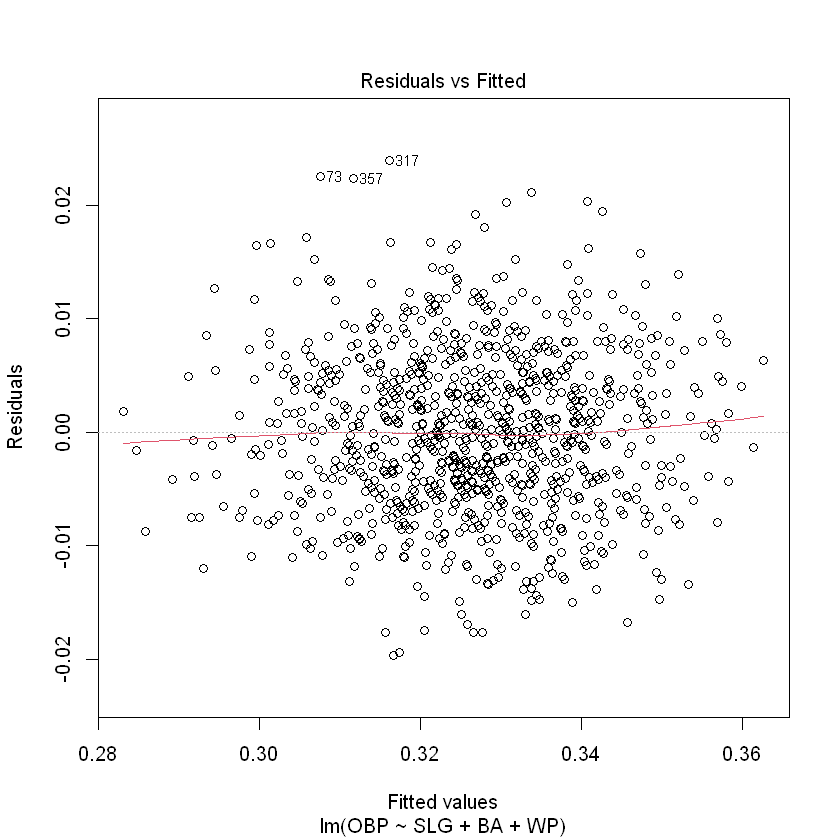

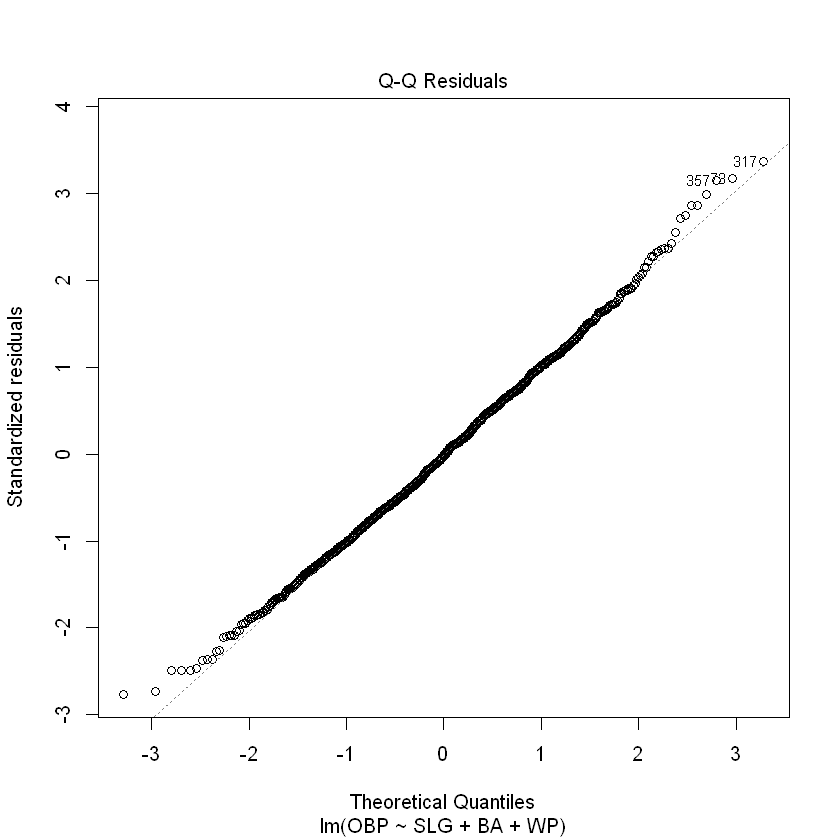

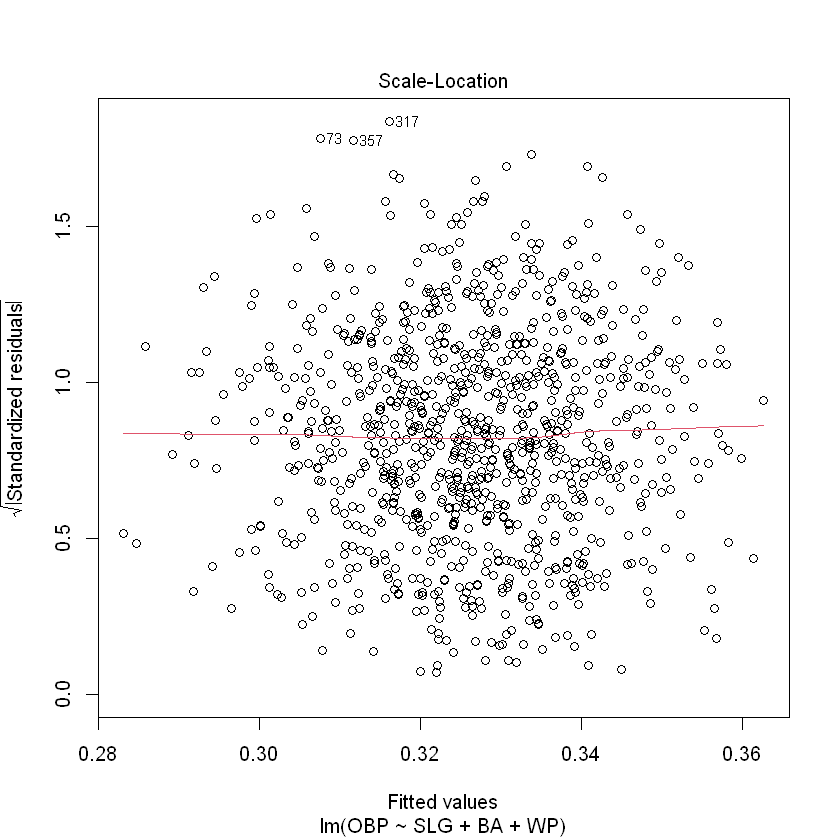

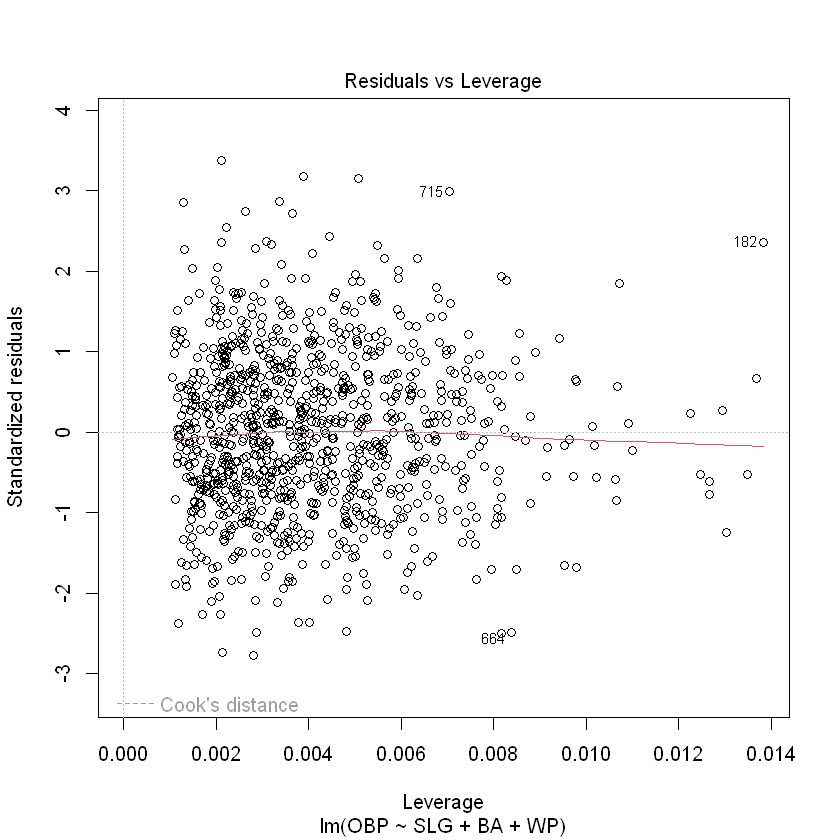

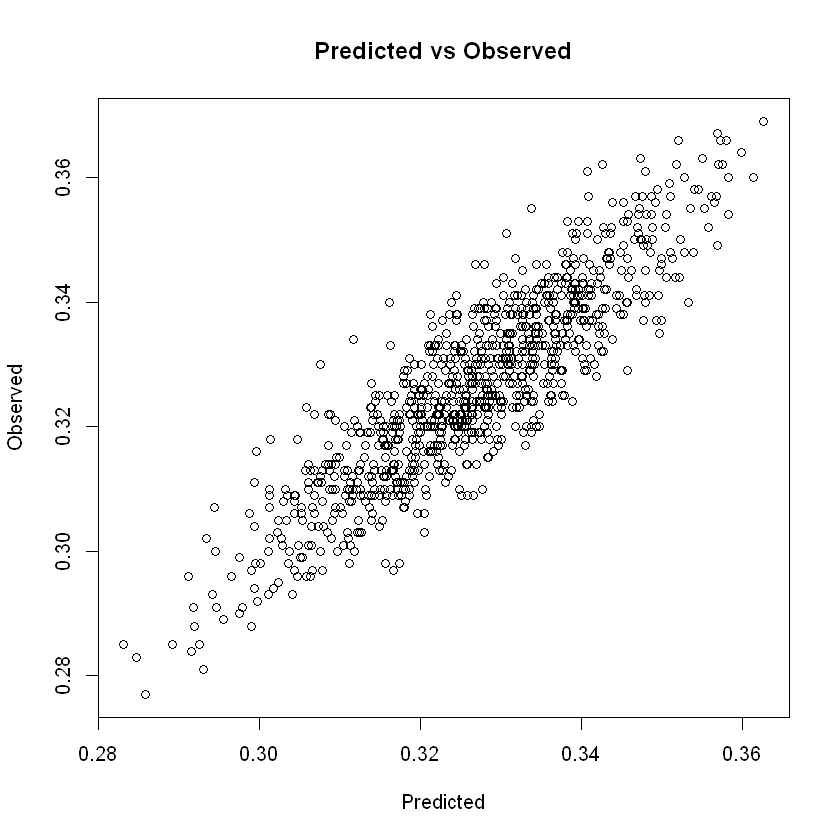

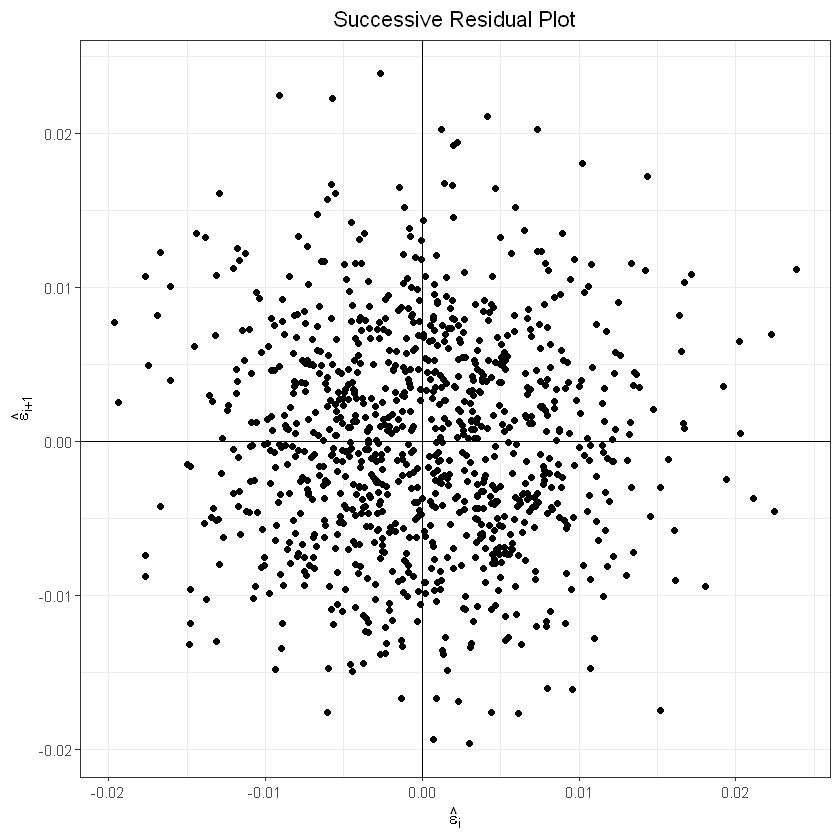

In [183]:
# full dataset - obp
diagnostics_plots(df=train_full,
                  model=lmod_full_obp,
                  response_var='OBP',
                  type='linear')

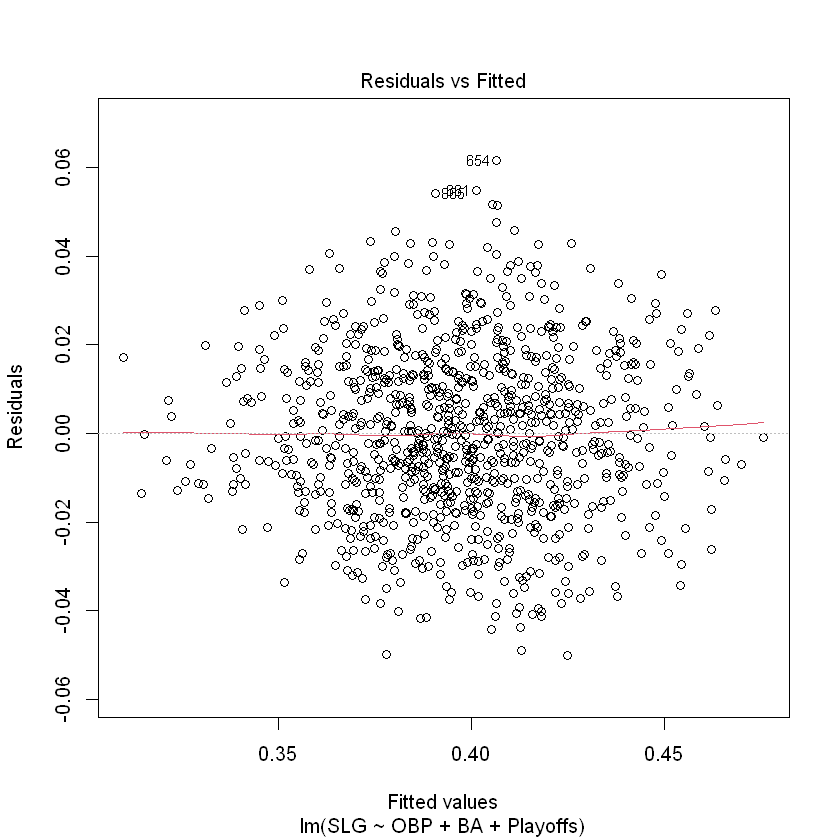

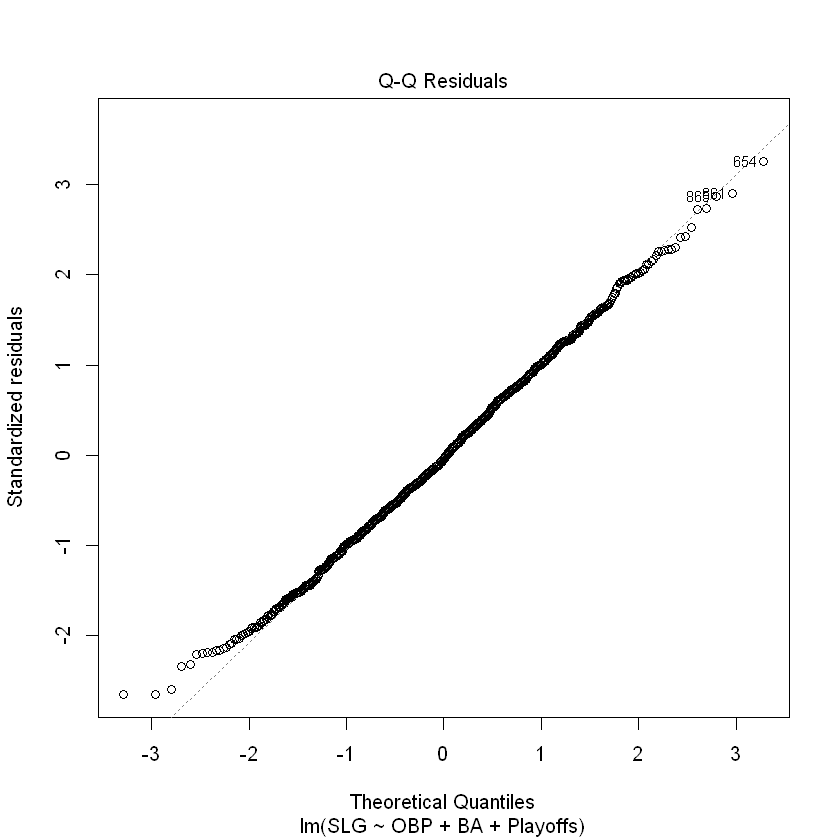

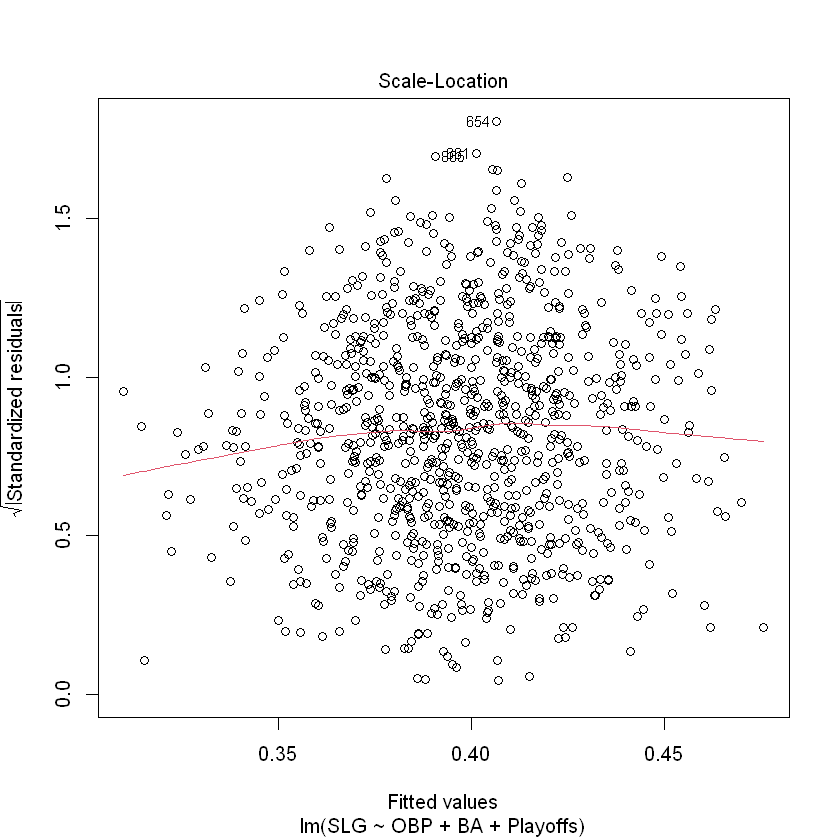

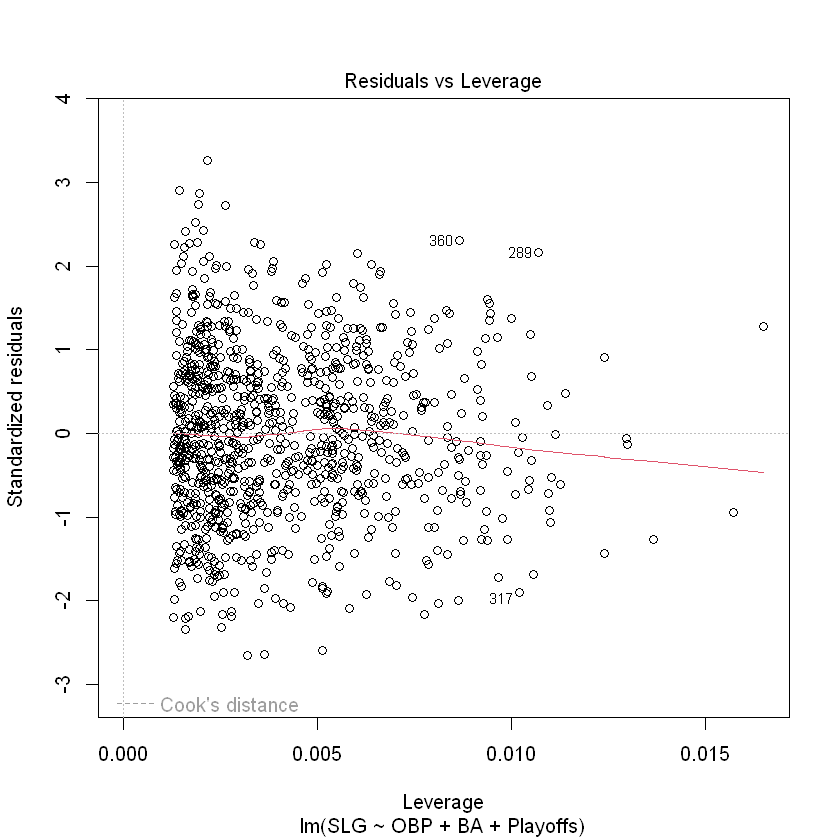

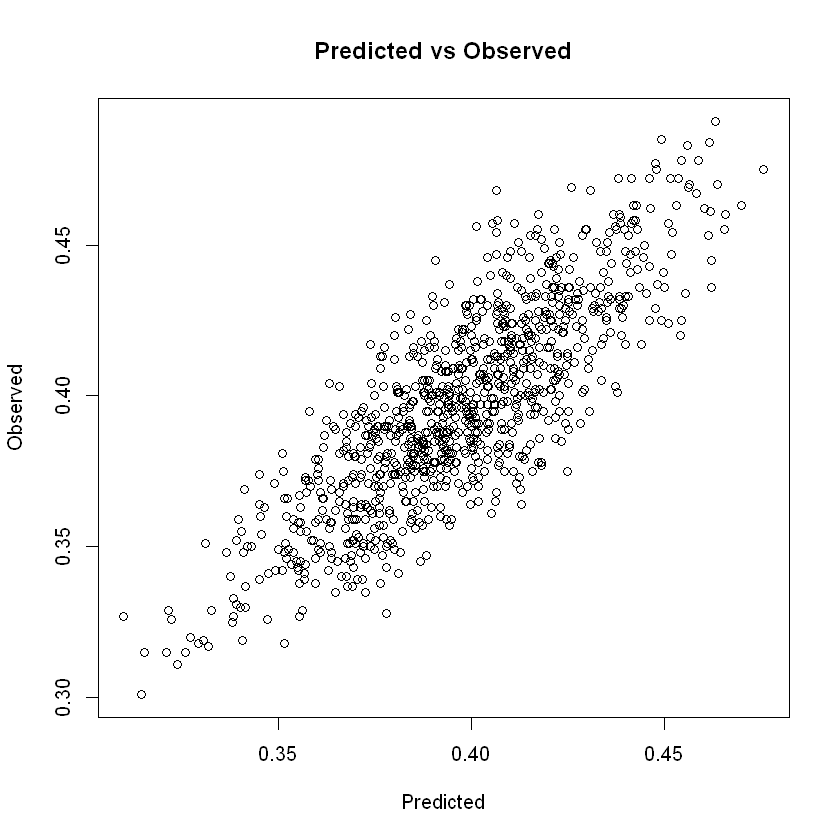

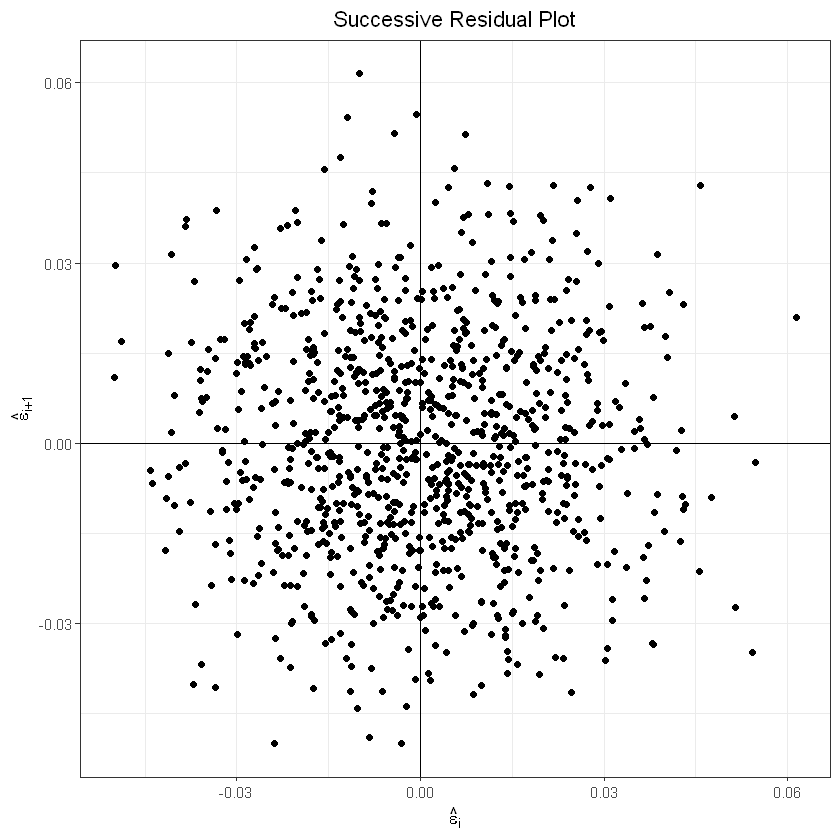

In [184]:
# full dataset - slg
diagnostics_plots(df=train_full,
                  model=lmod_full_slg,
                  response_var='SLG',
                  type='linear')

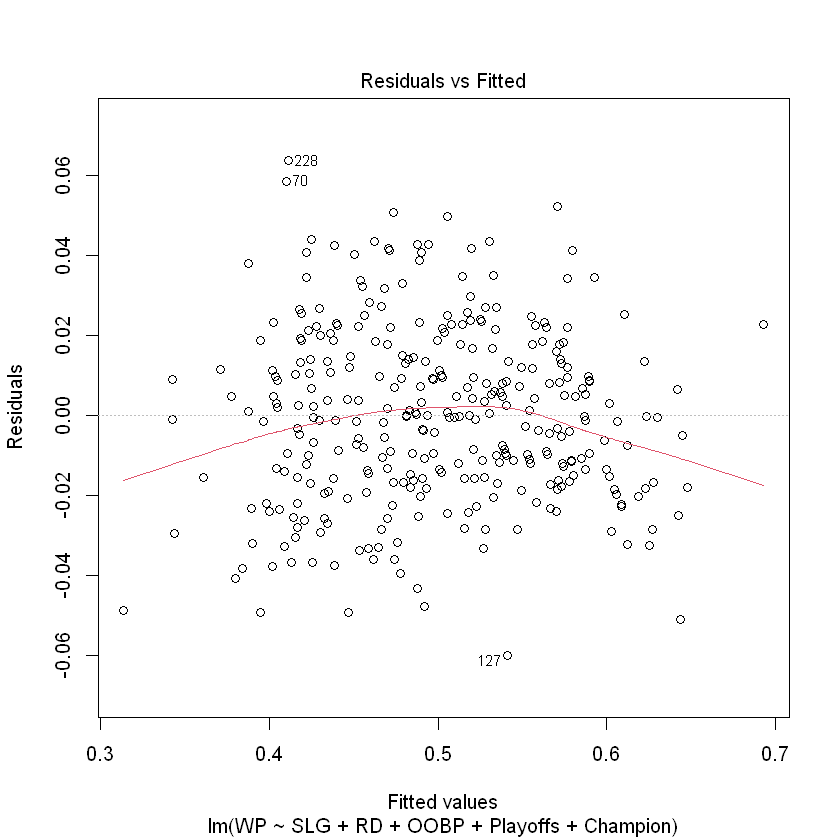

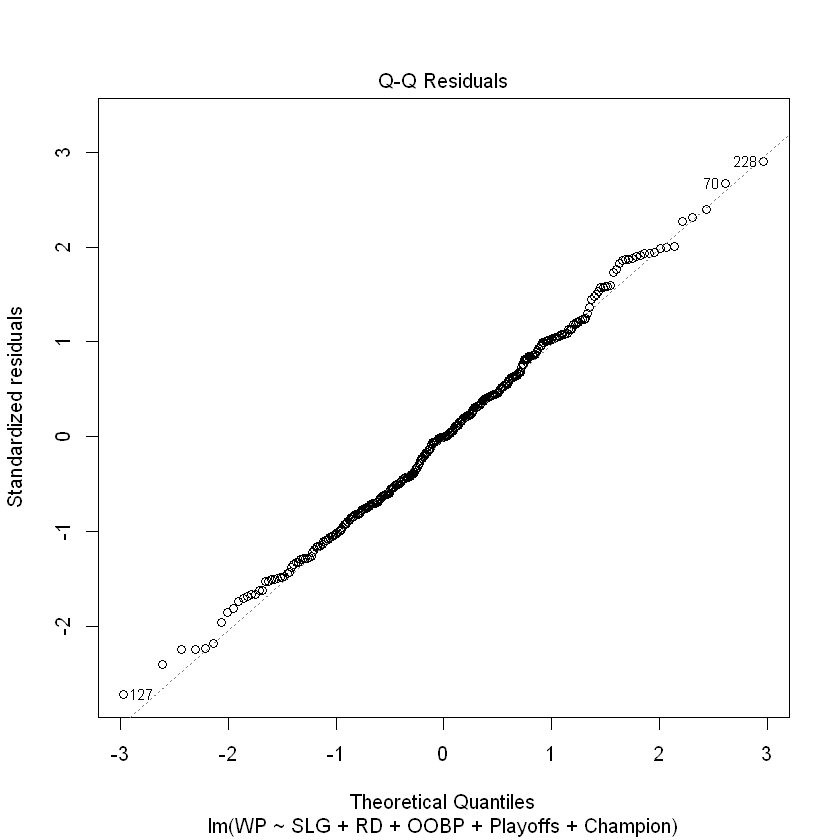

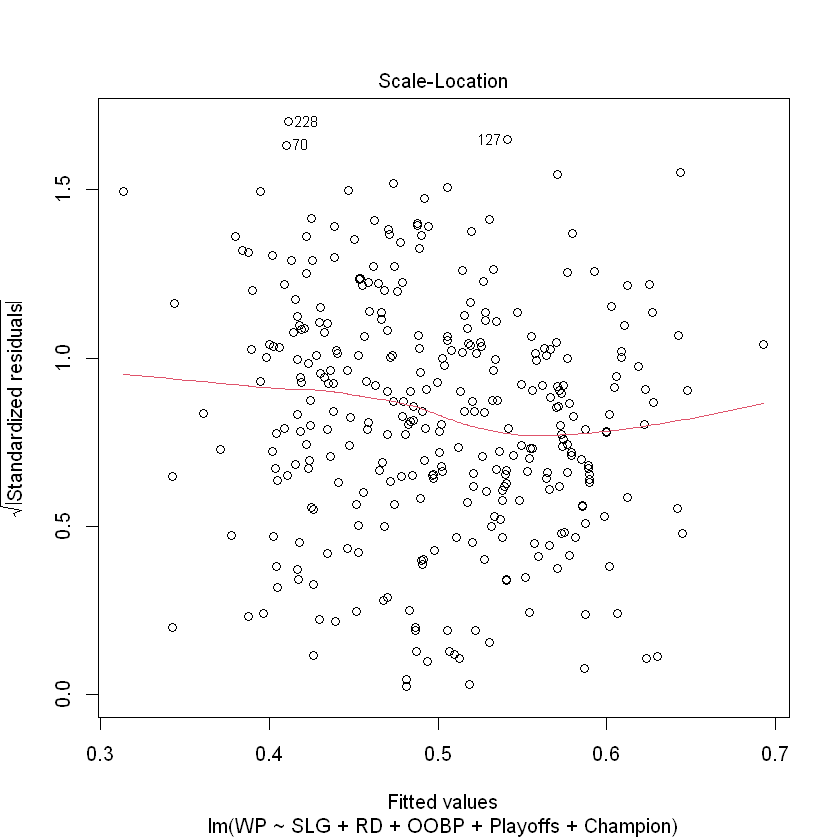

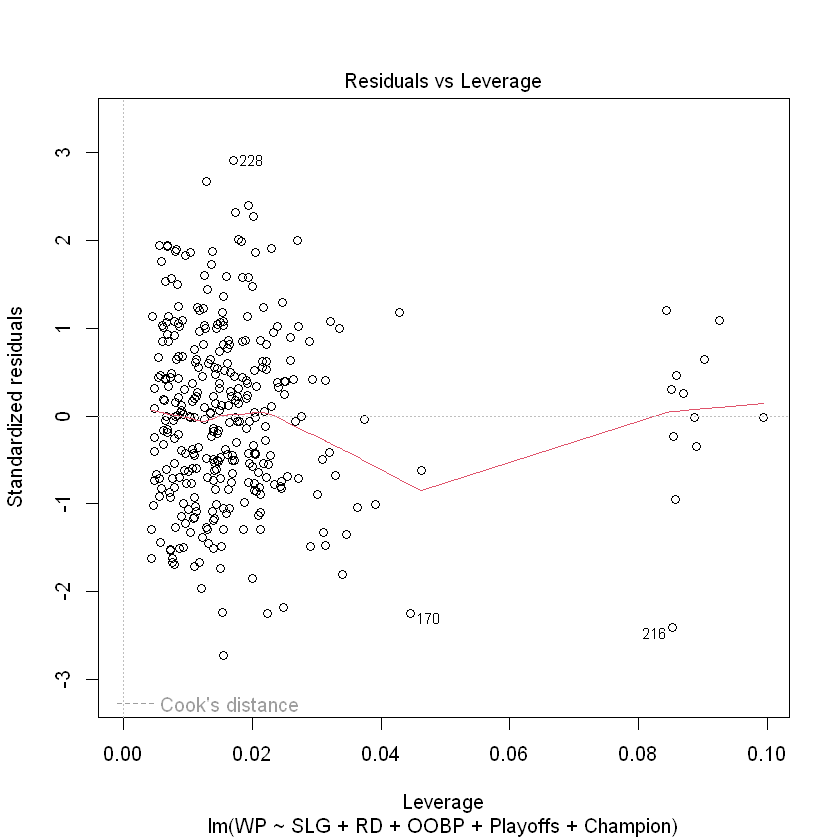

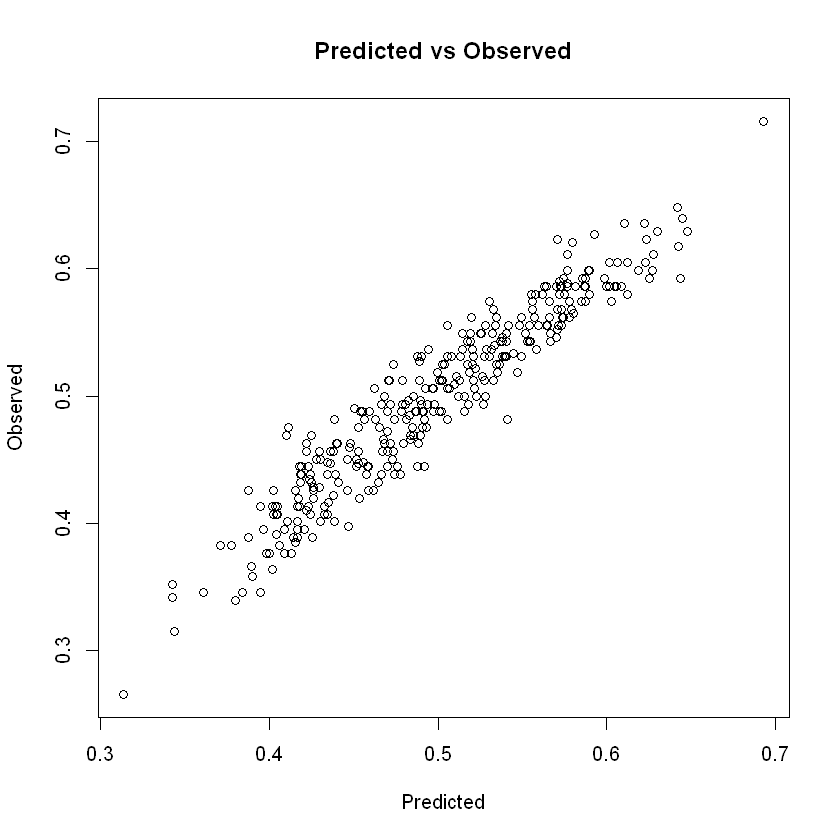

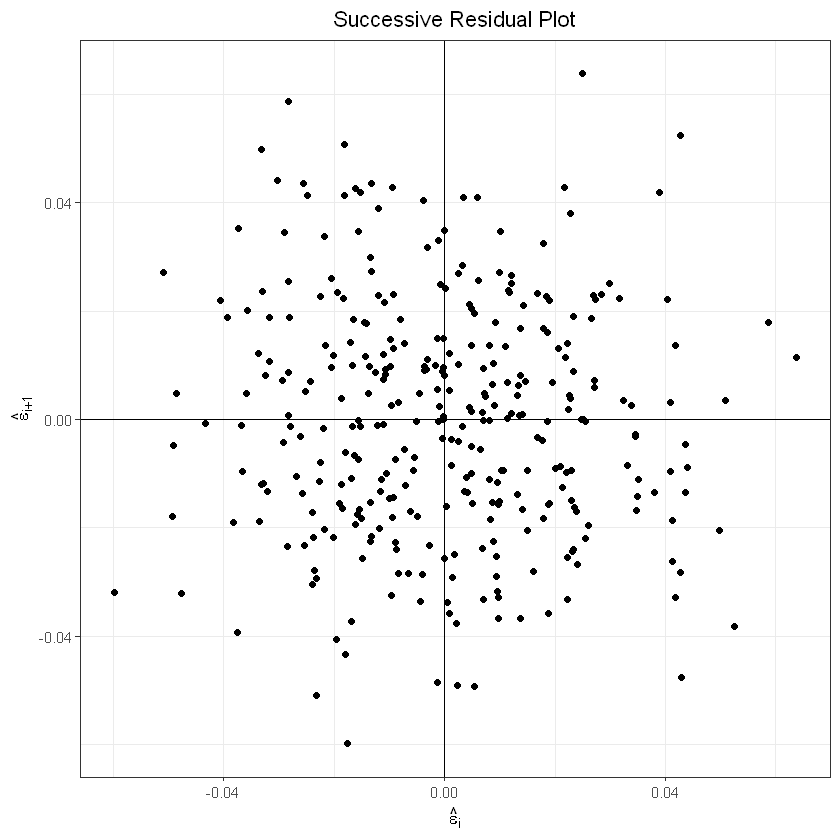

In [185]:
# recent dataset - wp
diagnostics_plots(df=train_recent,
                  model=lmod_recent_wp,
                  response_var='WP',
                  type='linear')

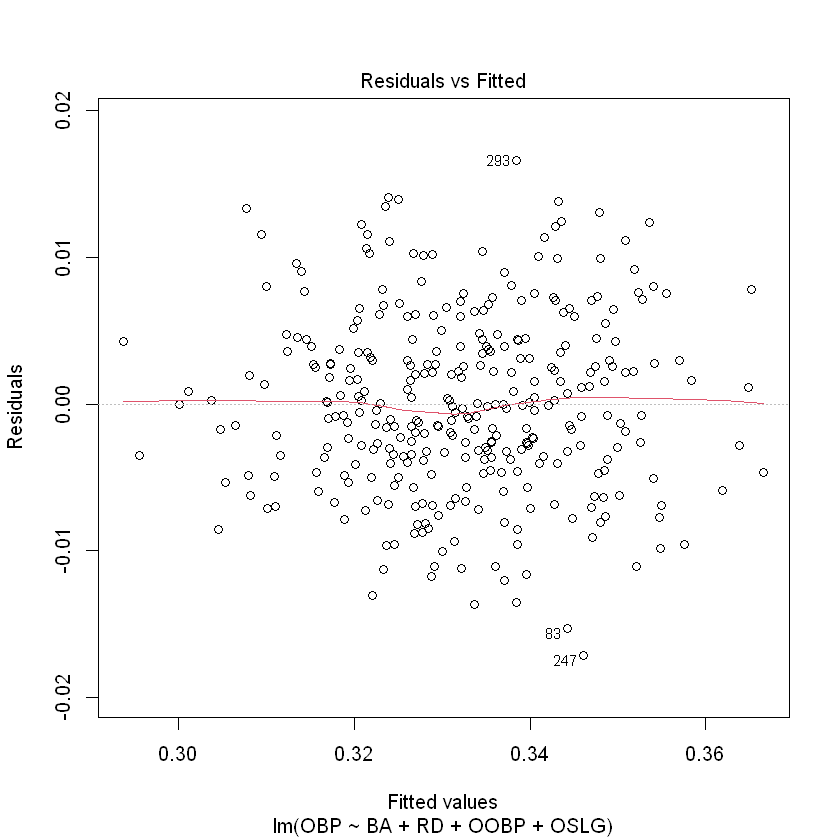

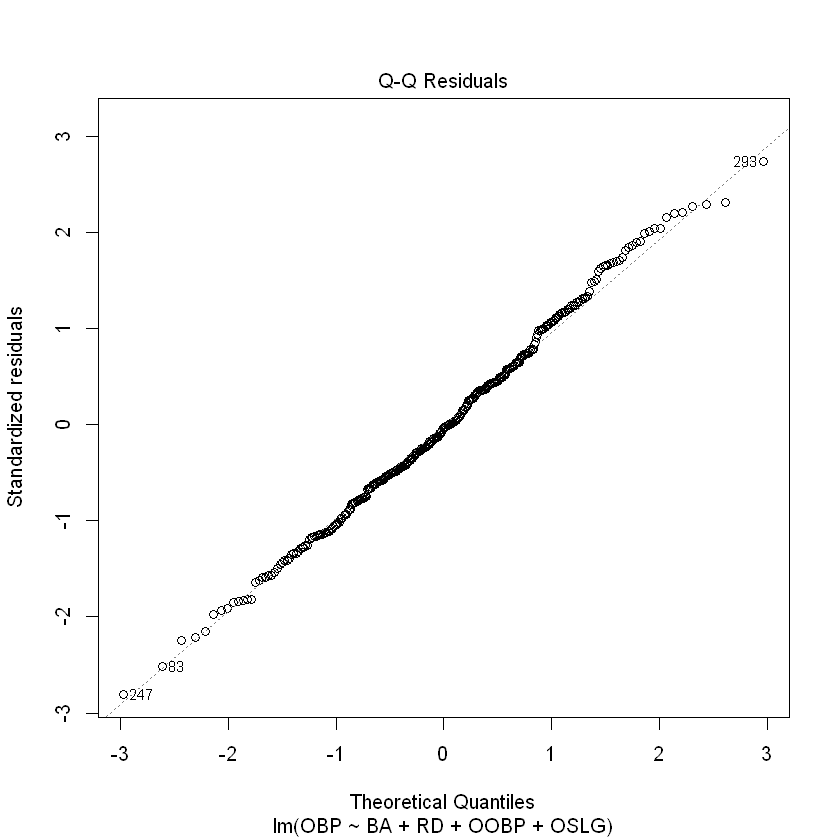

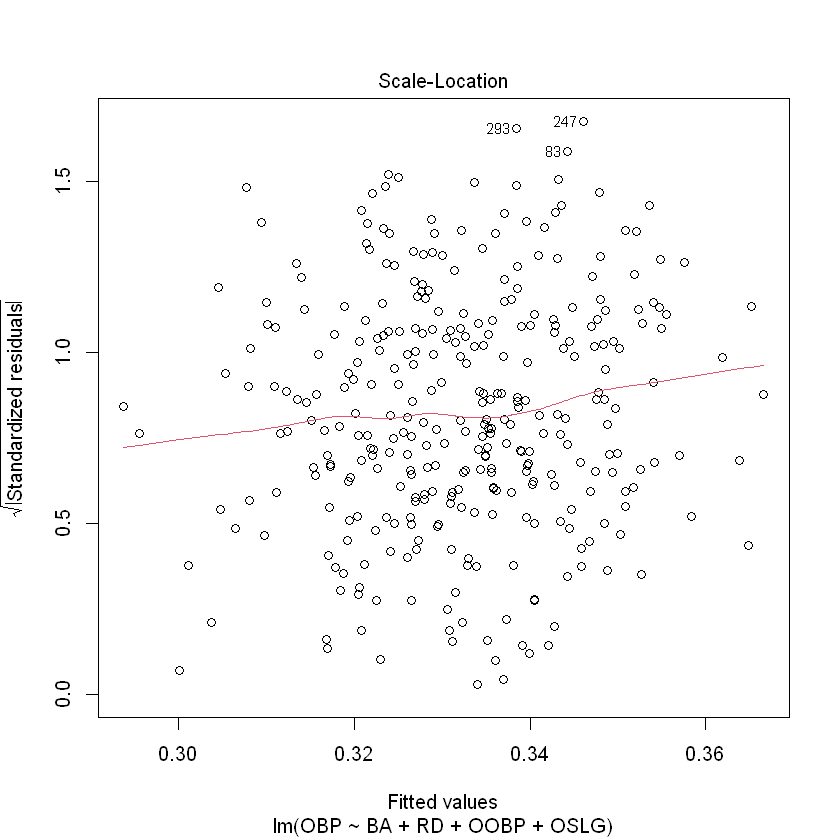

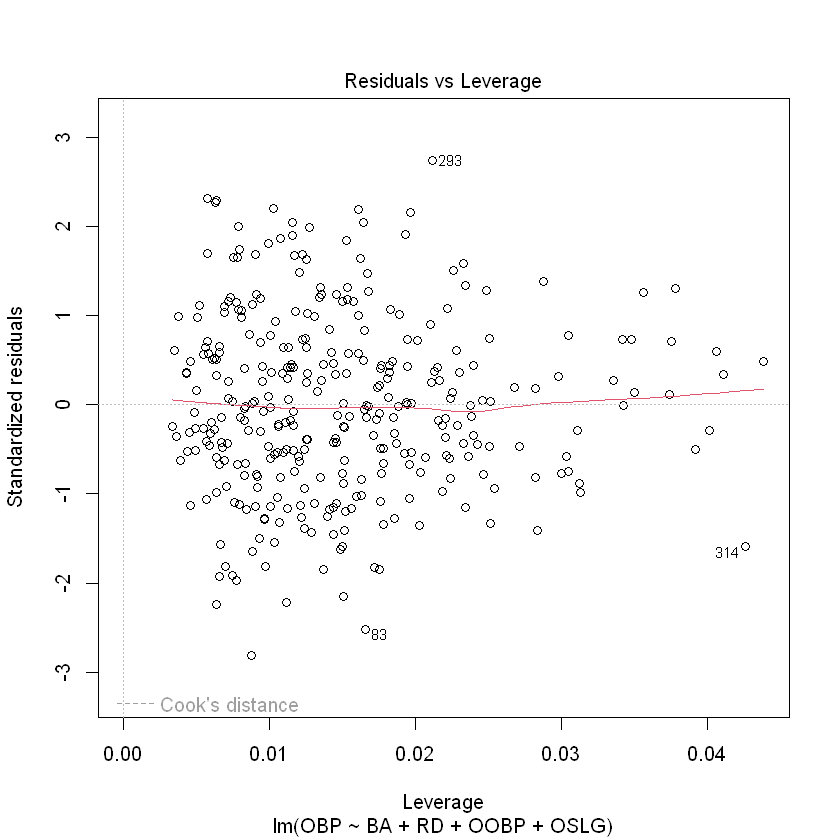

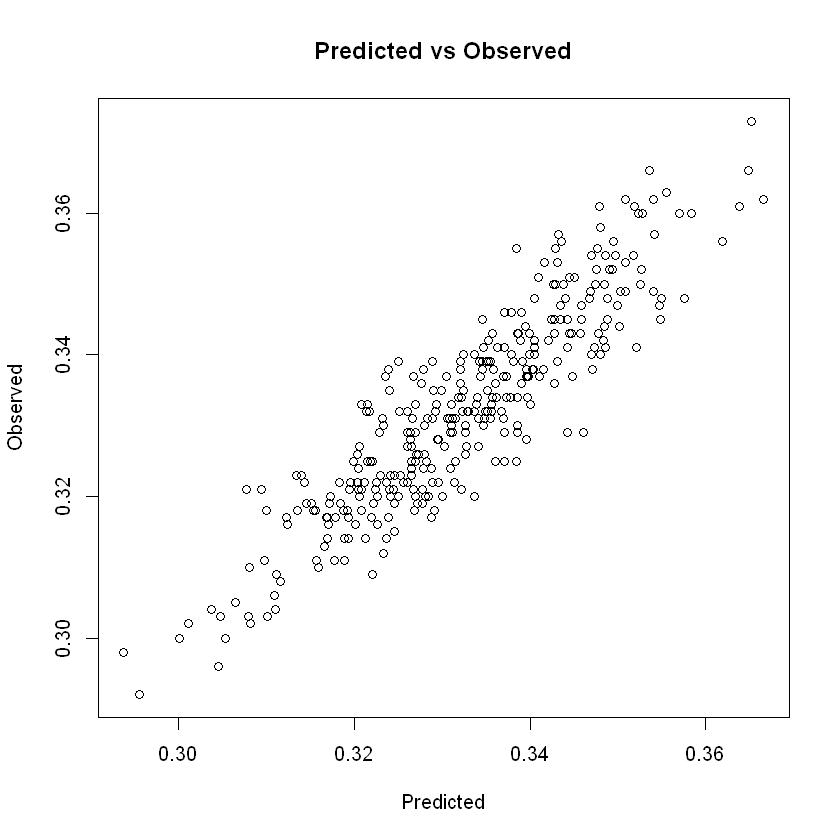

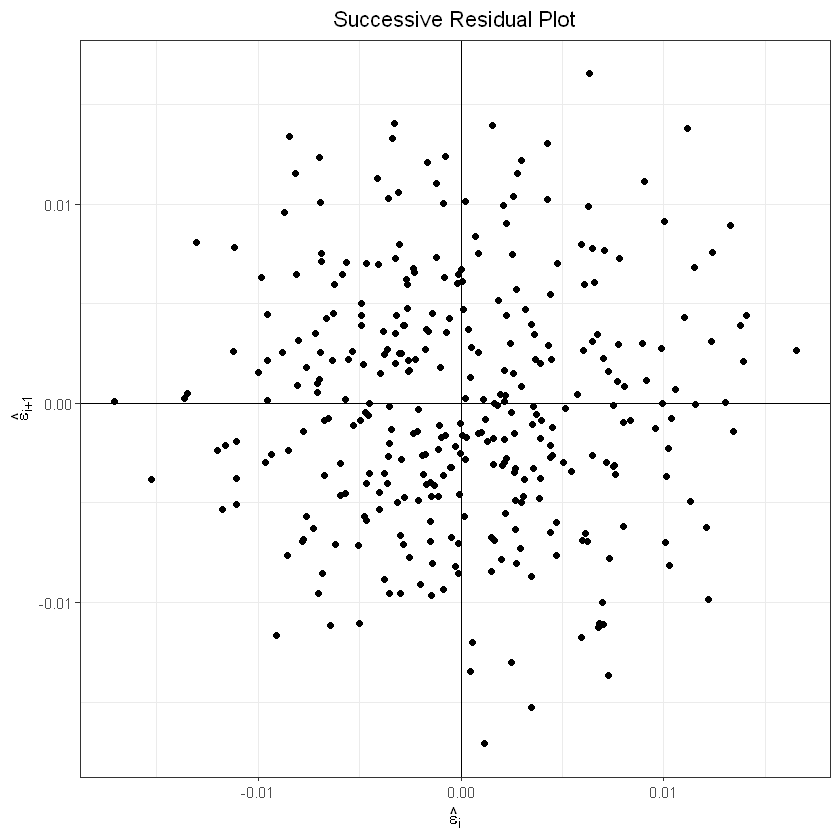

In [186]:
# recent dataset - obp
diagnostics_plots(df=train_recent,
                  model=lmod_recent_obp,
                  response_var='OBP',
                  type='linear')

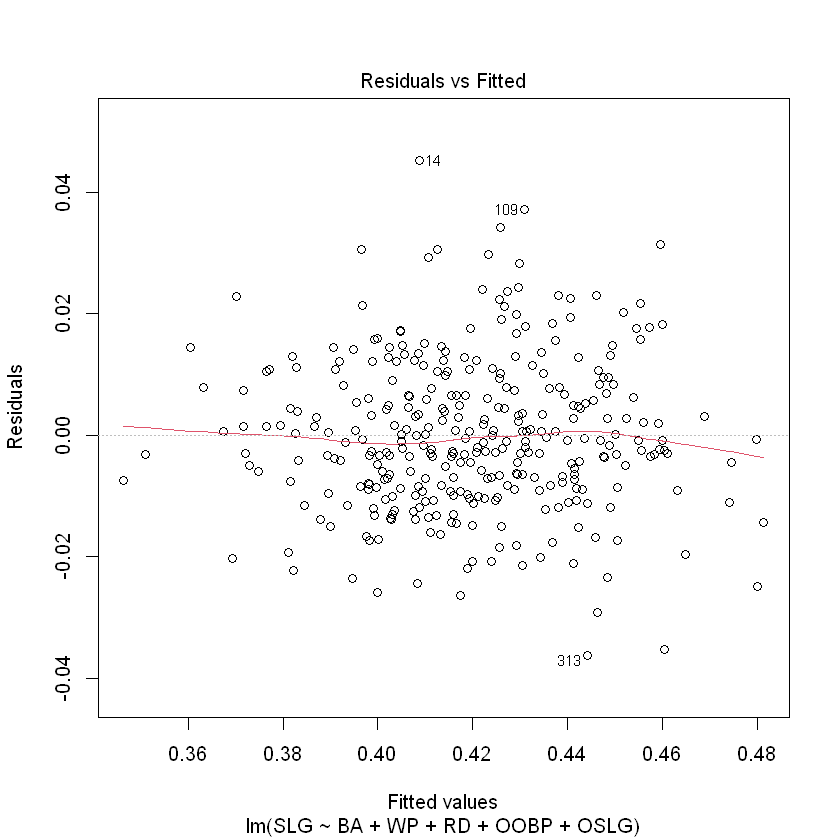

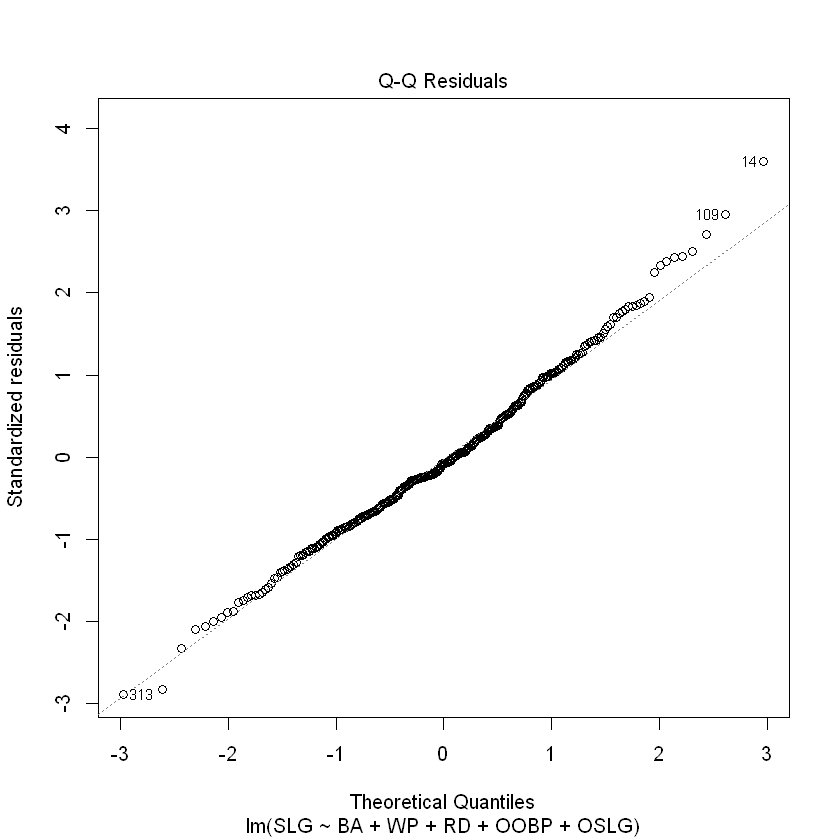

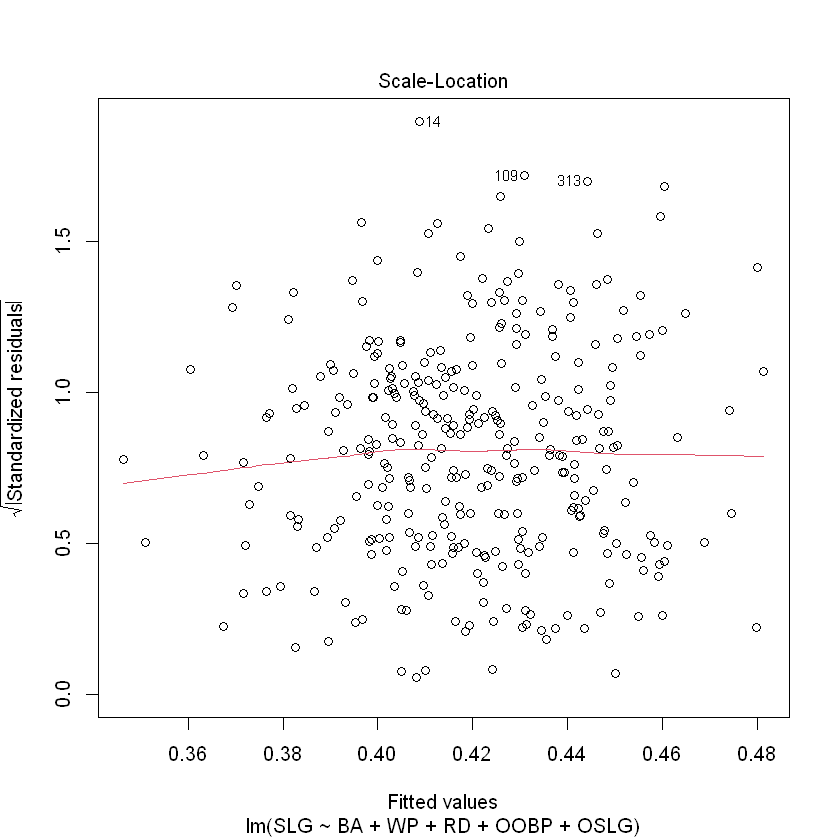

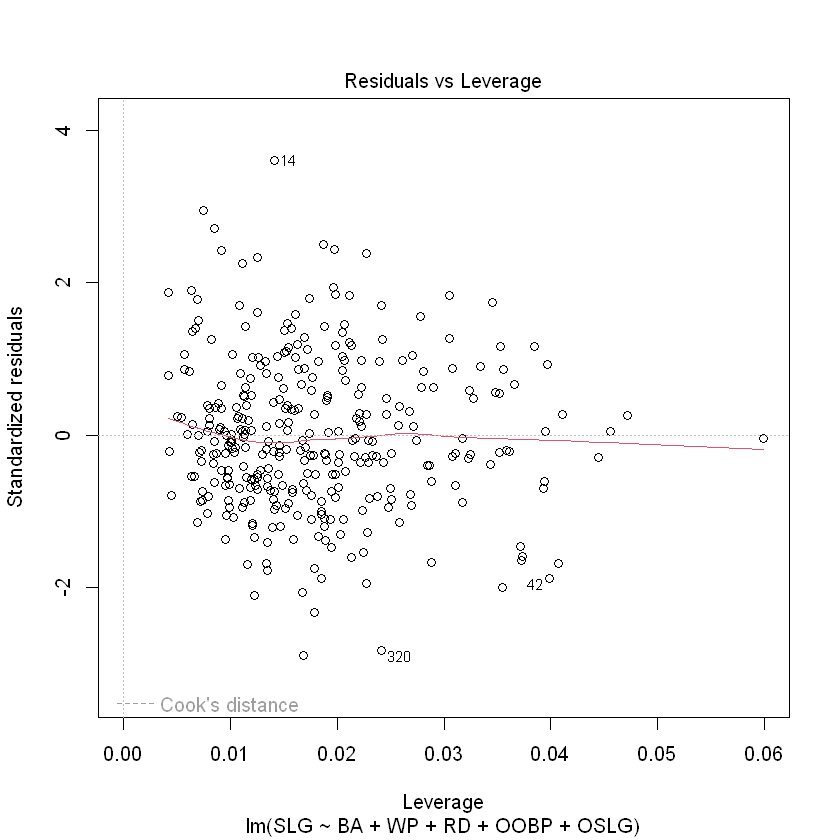

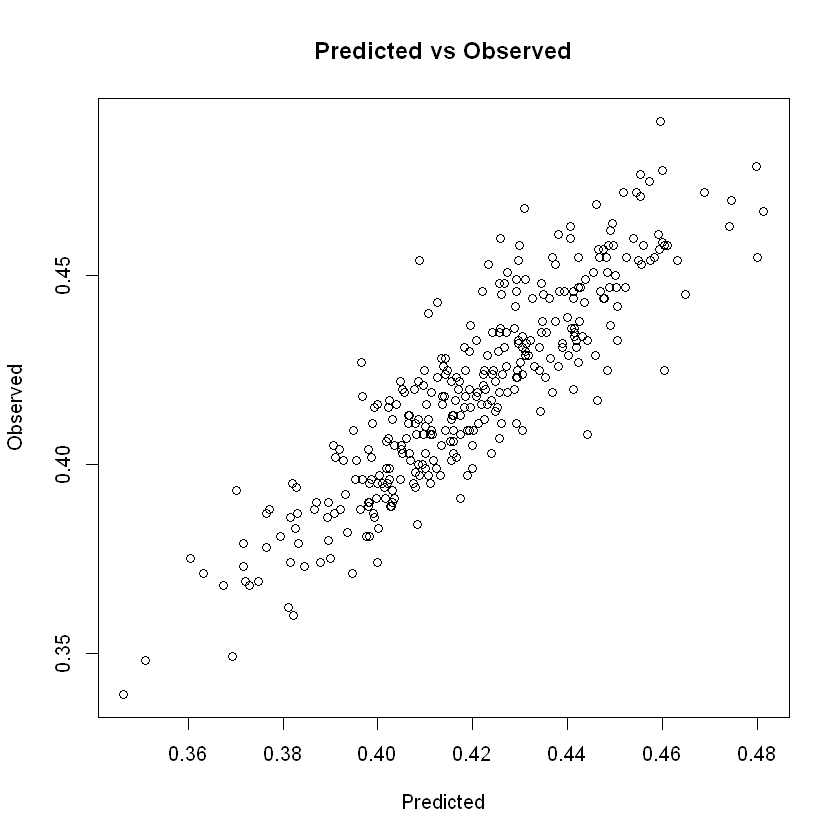

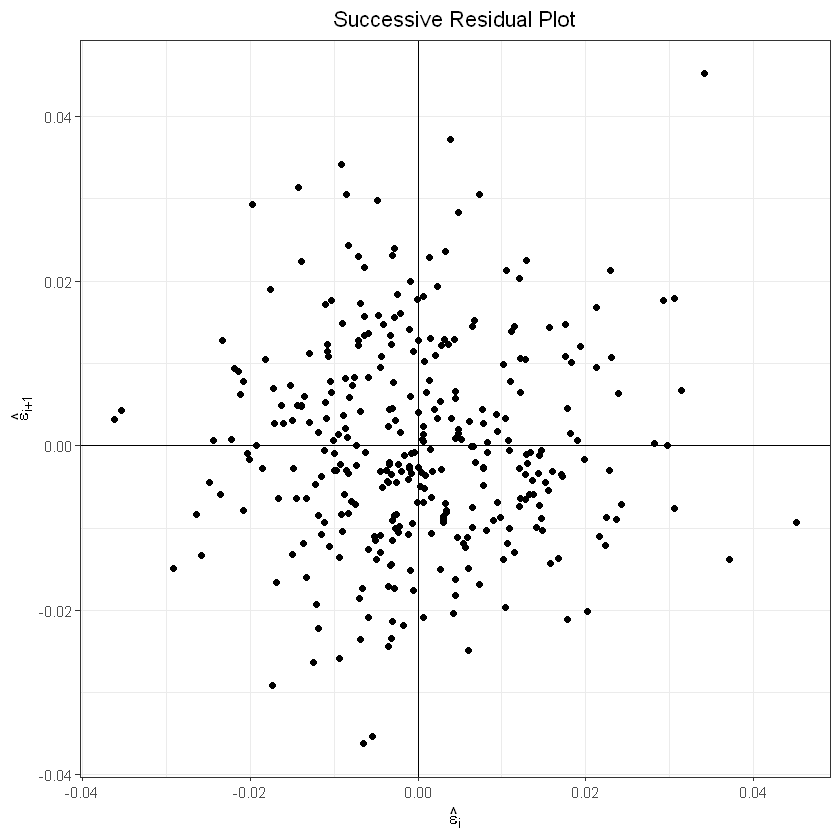

In [187]:
# recent dataset - slg
diagnostics_plots(df=train_recent,
                  model=lmod_recent_slg,
                  response_var='SLG',
                  type='linear')

### Commentary - Plotting

We'll examine if the required assumptions hold for our models (linearity, independence, constant variance, and normality) as well as examine influential points. Besides some minor variations, the diagnostic plots for all of our models were similar. We can essentially conclude the following for all of our plots

- **Linearity**: Looking at the observed vs. predicted plots, there is a general linear trend. Some plots had tighter lines with higher concentration on them, but definitely linear.
- **Independence**: Looking at the successive residual plots, we see constant variance around the origin for all of them, indicating independence for our models. 
- **Constant Variance (homoscedasticity)**: Looking at the Residuals vs. Fitted plots, what we want here is randomness about the x-axis without discerning patterns such as curvature or cone shapes. Although the plots do seem slightly spherical from the origin, there are no disernable patterns such as curvature or a cone shape. Therefore, we can confirm constant variance (homoscedasticity).
- **Normality**: Looking at the qq-plots, aside from some straying along the ends, all of the models present strong evidence of normality as they follow a general linear line in the qq-plots. 
- **Outliers (influential points)**: Looking at the residuals vs leverage chart, we don't see any points past the Cook's distance threshold, therefore we don't have evidence of the presence of influential points.

### Collinearity

In [188]:
# full dataset - wp
print('Full Dataset - WP')
vif(lmod_full_wp)

# recent dataset - wp
print('Recent Dataset - WP')
vif(lmod_recent_wp)

# full dataset - obp
print('Full Dataset - OBP')
vif(lmod_full_obp)

# recent dataset - obp
print('Recent Dataset - OBP')
vif(lmod_recent_obp)

# full dataset - slg
print('Full Dataset - SLG')
vif(lmod_full_slg)

# recent dataset - slg
print('Recent Dataset - SLG')
vif(lmod_recent_slg)

[1] "Full Dataset - WP"


RD Playoffs Champion 
1.549468 1.616760 1.229093

[1] "Recent Dataset - WP"


SLG       RD     OOBP Playoffs Champion 
3.105195 5.554386 3.682427 1.759538 1.141900

[1] "Full Dataset - OBP"


SLG       BA       WP 
2.698308 2.718200 1.226786

[1] "Recent Dataset - OBP"


BA       RD     OOBP     OSLG 
2.429543 3.879635 4.174665 3.849793

[1] "Full Dataset - SLG"


OBP       BA Playoffs 
3.895711 3.693736 1.161660

[1] "Recent Dataset - SLG"


BA        WP        RD      OOBP      OSLG 
 2.433599  8.998001 10.966188  4.249479  3.853817

### Commentary - Collinearity

Given that the best model for all of our models feature multiple variables, we tested for collinearity using VIF for all of them.

Only 2 models seem to have evidence of collinearity, when models have calculated VIFs larger than 5.

- The model for winning percentage using the recent dataset has RD (run differential) with a higher than acceptable VIF.
- The model for slugging percentage using the recent dataset has WP (winning percentage) and RD (run differential) with higher than acceptable VIFs.

The models which have collinearity is some cause for concern.

[Table of Contents](#toc)

[Conclusion](#part-viii)

# VII - Pythagorean Theorem of Baseball <a id="part-vii"></a>

## Concept

Let

$R_s$: Runs Scored

$R_a$: Runs Allowed

$W_p$: Winning Percentage

Then, there were two formulas presented:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

---

Our goal is to find some factor, $f$, such that:

$$W_p = \frac{R_s^f}{R_s^f + R_a^f}$$

---

For ease, let's assign 

- $R_s = s$
- $R_a = a$
- $W_p = p$

$W_p = \frac{R_s^f}{R_s^f + R_a^f}$

$\rightarrow p = \frac{s^f}{s^f + a^f}$

$(s^f + a^f) p = \frac{s^f}{s^f + a^f} (s^f + a^f)$

$(s^f + a^f)p = s^f$

$s^fp + a^fp = s^f$

$a^fp = s^f - s^fp$

$a^fp = s^f(1 - p)$

$\frac{p}{1 - p} = \frac{s^f}{a^f}$

$\log(\frac{p}{1 - p}) = \log(\frac{s^f}{a^f})$

$\log(\frac{p}{1 - p}) = f\log(\frac{s}{a})$

---

So what this means for our dataset and model is that we can transform our columns into:

- $y = \log(\frac{W_p}{1-W_p})$: response variable
- $x = \log(\frac{R_s}{R_a})$: predictor variable

By using simple linear regression, we can create a model where

$y = \beta_0 + \beta_1 x$,

If the **Pythagorean Theorem of Baseball** holds weight, then we would roughly expect

$\beta_0$ to be close to $0$ and $\beta_1$ near the range $(1.81, 2)$, from:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

## Theorem Data Preparation

In [189]:
# select the necessary columns
df_theorem <- df %>% select(c(RS, RA, W, G))
# create win percentage
df_theorem$WP <- with(df_theorem, W/G)
# drop columns used in the win percentage column
df_theorem <- df_theorem %>% select(-c(W, G))
# create the response column
df_theorem$response <- with(df_theorem, log(WP/(1-WP)))
# create the predictor column
df_theorem$predictor <- with(df_theorem, log(RS/RA))
head(df_theorem)

RS,RA,WP,response,predictor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
734,688,0.5000000,0.00000000,0.064720191
700,600,0.5802469,0.32378708,0.154150680
712,705,0.5740741,0.29849299,0.009880109
734,806,0.4259259,-0.29849299,-0.093574714
613,759,0.3765432,-0.50424665,-0.213636841
748,676,0.5246914,0.09884583,0.101209902


## Theorem Modeling

In [190]:
lmod <- lm(data=df_theorem, response ~ predictor)

In [191]:
summary(lmod)


Call:
lm(formula = response ~ predictor, data = df_theorem)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36456 -0.06840  0.00013  0.06704  0.31094 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.002198   0.002828  -0.777    0.437    
predictor    1.870947   0.019587  95.519   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09926 on 1230 degrees of freedom
Multiple R-squared:  0.8812,	Adjusted R-squared:  0.8811 
F-statistic:  9124 on 1 and 1230 DF,  p-value: < 2.2e-16


## Theorem Model Analysis

Our factor was in the right range, let's compare the 3 formulas to the actual win percentage. We'll also examine the model itself through the metric `R2` ($R^2$).

*Note that we've only used the coefficient from the model for the plotting. The actual regression formula would include the intercept, but that was not the point of this experiment. We'll discuss the actual model performance below the plotting.*

In [192]:
# create comparison 
derived_factor <- unname(lmod$coefficients[2])
df_theorem$derived <- with(df_theorem, RS^derived_factor / (RS^derived_factor + RA^derived_factor))
df_theorem$common <- with(df_theorem, RS^2 / (RS^2 + RA^2))
df_theorem$accurate <- with(df_theorem, RS^1.81 / (RS^1.81 + RA^1.81))

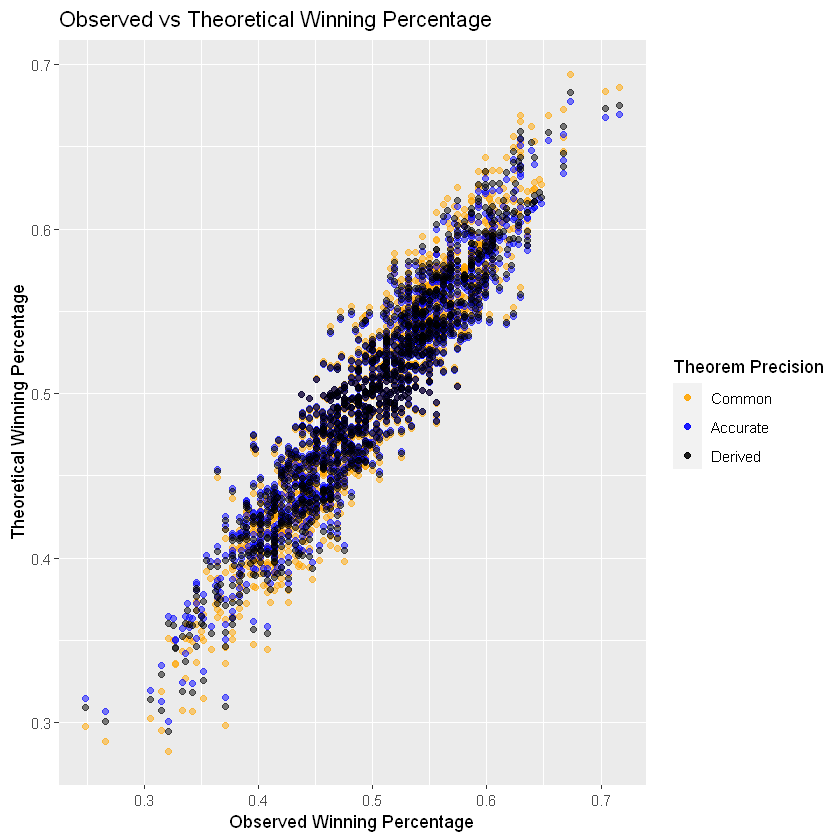

In [193]:
# plotting
ggplot(df_theorem) +
    geom_point(aes(WP, y=common, color='Common'), alpha=0.5) +
    geom_point(aes(WP, y=accurate, color='Accurate'), alpha=0.5) +
    geom_point(aes(WP, y=derived, color='Derived'), alpha=0.5) +
    xlab('Observed Winning Percentage') +
    ylab('Theoretical Winning Percentage') +
    ggtitle('Observed vs Theoretical Winning Percentage') +
    scale_color_manual(name='Theorem Precision',
                       breaks=c('Common', 'Accurate', 'Derived'),
                       values=c('Common'='orange', 'Accurate'='blue', 'Derived'='black'))

### Commentary - Theorem Model

Since this is a simple linear regression (single feature), we can confidently use the p-values from the t-tests and the $R^2$ metric to analyze the model itself.

We'll first note that the p-value associated with the intercept is $0.437$. Since this is the p-value associated with the t-test, using our standard significance level of $\alpha=0.05$, we don't have enough evidence to reject the null hypothesis that $\beta_0 = 0$. Therefore, there is some not enough statistical evidence that the intercept has an effect on the response variables (i.e. it may be equivalent to $0$), which is what we were expecting.

Next, noticing the $R^2$ value of $0.8812$, this tells us that the model explains approximately $88\%$ of variance in the data.

Additionally, notice that each of the **theorem's** factors result in a linear pattern when plotted agaisnt the actual data's winning percentage. Since each of the factors are *close* to one another, it's not surprising they're grouped together closely.

Overall, this indicates that the **Pythagorean Theorem of Baseball** does hold weight!

## Diagnostics

Although we've shown the results help confirm the **Pythagorean Theorem of Baseball**, we'll also examine validity of the model itself.

### Plotting

- Residuals vs. Fitted (constant variance assumption)
- QQ-Plot (normality assumption)
- Residuals vs. Leverage (outliers)
- Predicted vs. Observed (linearity assumption)
- Successive Residual Plot (independence assumption)

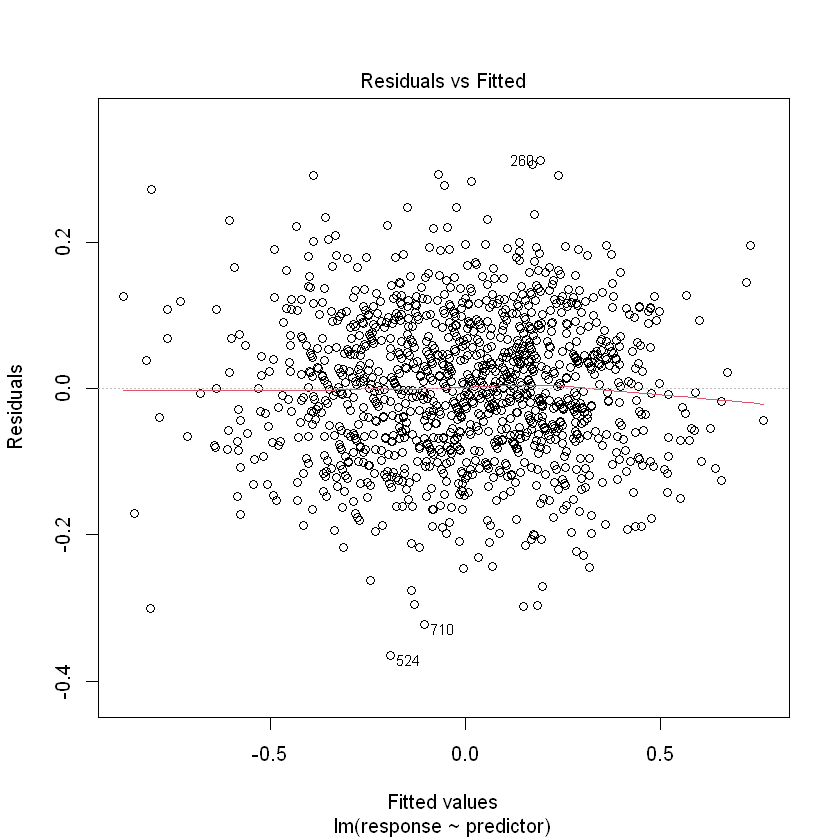

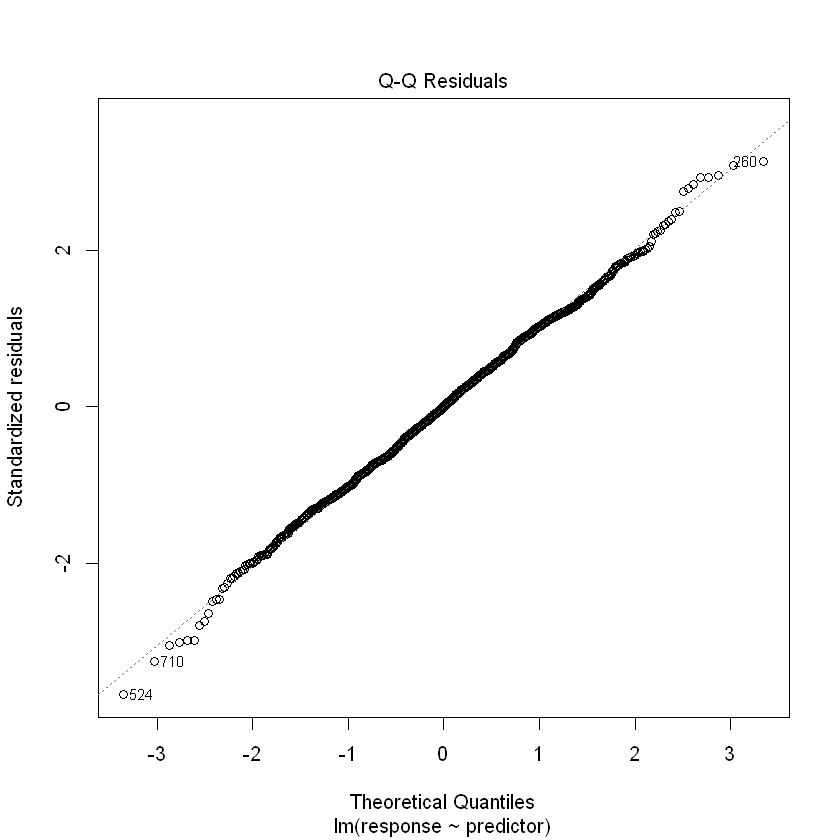

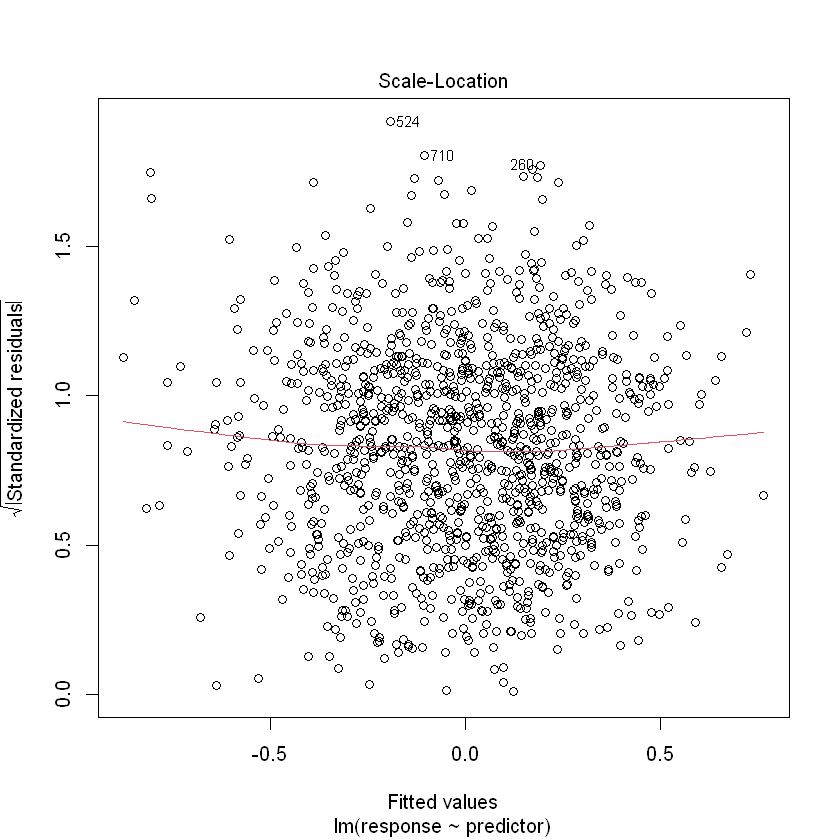

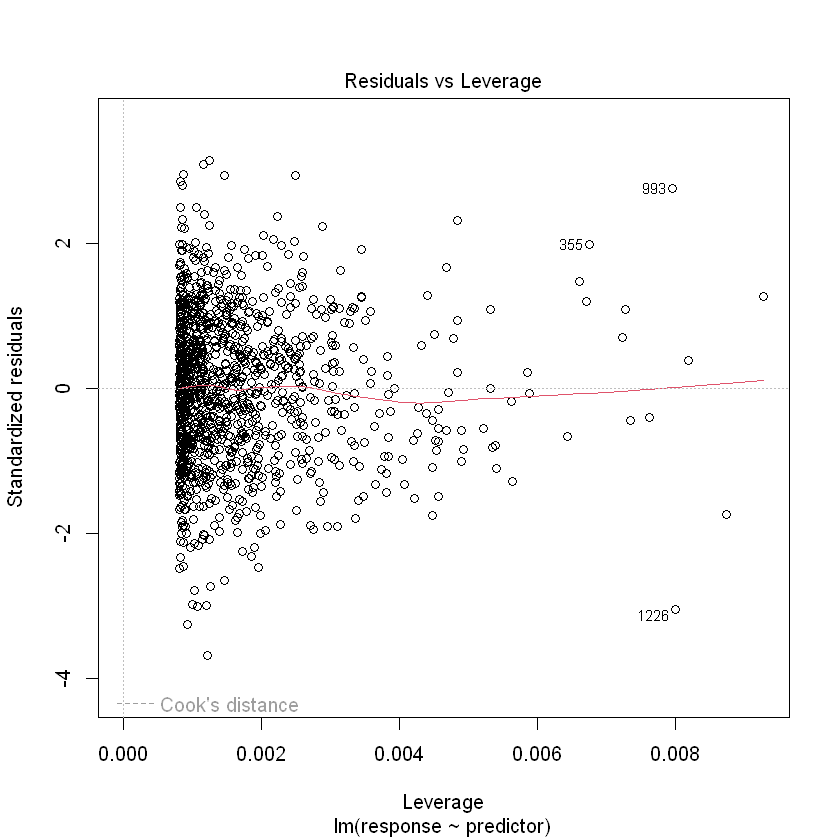

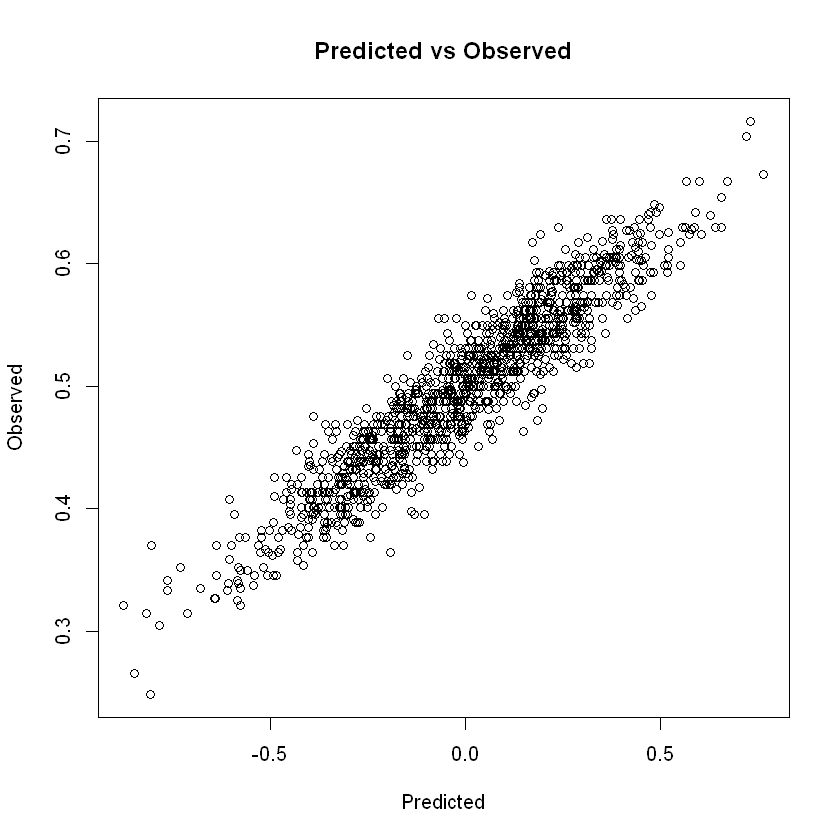

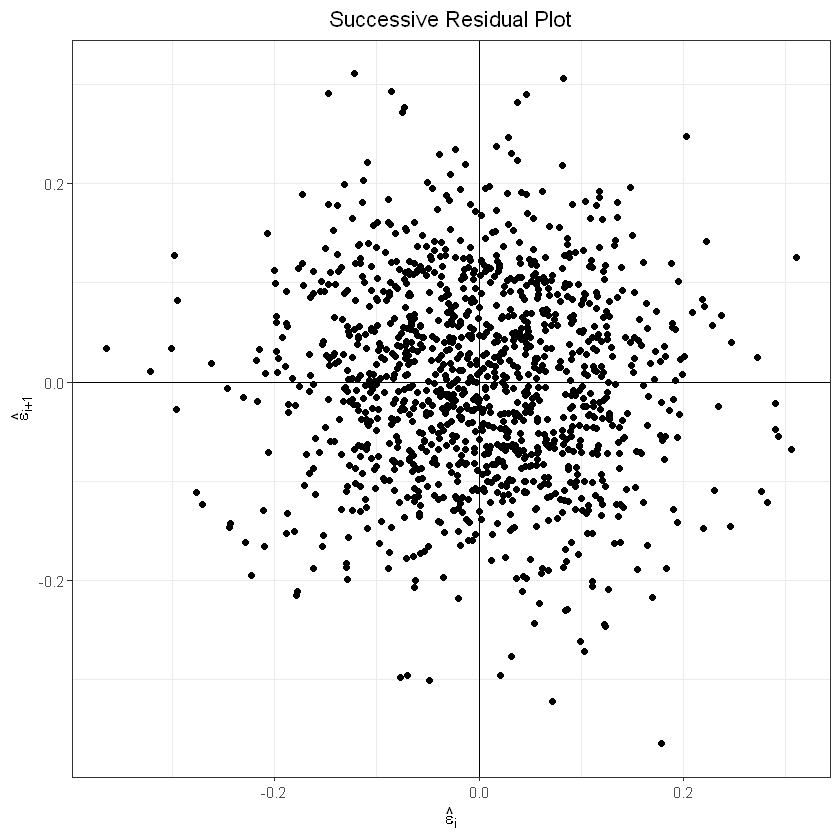

In [194]:
# plots
diagnostics_plots(df=df_theorem,
                  model=lmod,
                  response_var='WP',
                  type='linear')

### Commentary - Plotting

- **Linearity**: Looking at the observed vs. predicted plot, there is a general linear trend, so we can confirm linearity.
- **Independence**: Looking at the successive residual plot, we see constant variance around the origin, indicating independence.
- **Constant Variance (homoscedasticity)**: Looking at the Residuals vs. Fitted plot, what we want here is randomness about the x-axis without discerning patterns such as curvature or cone shapes. Although the plot does seem slightly spherical from the origin, there are no disernable patterns such as curvature or a cone shape. Therefore, we can confirm constant variance (homoscedasticity).
- **Normality**: Looking at the qq-plot, aside from some straying along the ends, the presents strong evidence of normality as it follows a general linear line in the qq-plots. 
- **Outliers (influential points)**: Looking at the residuals vs leverage chart, we don't see any points past the Cook's distance threshold, therefore we don't have evidence of the presence of influential points.

[Table of Contents](#toc)

[Conclusion](#part-viii)

---

# VIII - Conclusion <a id="part-viii"></a>

## 1. Introduction and Background

In this paper, we take our own swing at baseball analytics, exploring metrics that predict playoff appearances, World Series victories, and overall team performance [1](https://www.samford.edu/sports-analytics/fans/2022/MLB-Winning-Percentage-Breakdown-Which-Statistics-Help-Teams-Win-More-Games) [2](https://sarahesult.medium.com/common-mlb-statistics-which-stats-determine-a-teams-win-percentage-a6e0a83aa07c).

Bill James, a pioneer of baseball analytics, coined the term “Sabermetrics” to describe this overall field [4](https://en.wikipedia.org/wiki/Sabermetrics). One result we'll try to confirm within this paper is the **Pythagorean Theorem of Baseball** [3](https://www.baseball-reference.com/bullpen/Pythagorean_Theorem_of_Baseball).

Our **research goals** are:

1. Predict whether or not a team made the playoffs.
2. Predict whether or not a team won the series.
3. Predict performance metrics:
    - Winning Percentage
    - On-Base Percentage
    - Slugging Percentage
4. Confirm the Pythagorean Theorem of Baseball.
5. Explore the break between seasons tracking `OOBP` and `OSLG`.


## 2. Methods and Results

### Data Preparation

Our dataset spans 50 years of team statistics [6](https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012).

**Null Values**

- `RankSeason`, `RankPlayoffs`: change to booleans representing playoff appearances and World Series wins.
- `OOBP`, `OSLG`: weren't tracked prior to the 1999 season; use to perform comparative analysis.

**Data Transformation**

- Combine wins (`W`) and games (`G`) to compute winning percentage.
- Calculate run differential (`RD`) with runs scored (`RS`) and runs allowed (`RA`).
- Drop individual columns to prevent collinearity.

### Data Modeling

**Generalized Linear Models**: predict playoff appearances and World Series wins.

We created visuals to reveal any binary patterns. To select the best model, we used AIC, MSPE, chi-squared tests, and partial f-tests. Each model had AIC and MSPE created through backwards selection using p-values from individual t-tests. To evaluate the best model, we used contingency tables (and accuracy) and predicted vs. observed plots. In the standard diagnostic plots, we see the majority of our assumptions required, aside from influential points, violted. This suggests our models could be improved, possibly through transformations within the data. We tested for and confirmed the absence of collinearity through VIF.

**Multiple Linear Regression**: explore relationships between team stats.

We used forward selection, deciding the best fit for each size model with SSE. We created visuals to reveal any linear correlations, and then used a combination of AIC, BIC, MSPE, $R^2_a$, partial f-tests, and full f-tests for model selection. For each best model, we used diagnostic plots to confirm the assumptions required for linear regression. All assumptions available to confirm by those plots were confirmed for all models. We tested for collinearity through VIF. Two of our *best* models showed signs of collinearity.

**Simple Linear Regression**: validate the Pythagorean Theorem of Baseball.

We transformed the equation into a log-format, and then applied log-transformations with our data prior to building the model. The prediction was acceptable to confirm the theorem. Using diagnostic plots, we confirmed the model itself met the assumptions for linear regression.

**Historic vs. Recent**

There was evidence suggesting that either timeframe or new features could affect the model results.


## 3. Conclusion

In summary, our analysis sheds light on patterns that Sabermetrics was built upon, even with comparatively limited data. The historic vs. recent analysis suggests further subsetting the years could provide information on how the game has changed over the years. Furthermore, an attempt to predict how a team finishes the season or performs the following season would ultimately be more useful.




---

**Baseball Analytics**

**Carl Klein**

**May 1, 2024**

---

[Table of Contents](#toc)

[Conclusion](#part-viii)